# ML4Net - Lab 2

## Team members

Joel López (268823)| Julen Legido (268309) | Adrià Porta (268513) | Noel Pedrosa (269012)

## Description

In this lab, you will implement an ML model that detects congestion in Wi-Fi networks. In particular, you will desing and implement a supervised learning model (e.g., linear regression, multi-layer perceptron, neural network), which you will train using a dataset that was generated using the ns-3 simulator.

Each row in the dataset is organized as (x1, x2, ..., x26, y1, y2, ..., y26, s, r, l), where:

* `x1, x2..., x26, y1, y2, ..., y26` represent the histogram of the Inter-Frame Space (IFS) values for M frames that accessed the medium in a 60 seconds observation sample.
  * `x26` represents the maximum IFS duration (in ms) in the considered M frames whereas `x1` is `x26`/26
  * The remaining `xi` values are buckets at uniform spacing between `x1` and `x26`.
  * For i>1, the values of `yi` represent the IFS histogram count (in percentage) for a corresponding bucket interval between `xi`-1 and `xi`.
  * In the case of `y1`, the bucket interval is between 0 and `x1`
* `s` is the average IFS duration (in ms)
* `r` is the percentage of frame collisions
* `l` is the label, where 1 indicates that the network is saturated, and 0, that it is not

Original dataset: https://ieee-dataport.org/documents/dataset-identification-saturated-and-unsaturated-wi-fi-networks

## Instructions

*   Follow the steps from this Notebook and complete the proposed exercises.
*   Deliver the completed Notebook by uploading it to your Github repository.
*   Submission deadline: 1 June 2025 (EoB).

## Setting up the environment

In [1]:
# Core Python packages (should already be installed with Anaconda)
!pip install numpy pandas matplotlib seaborn scipy scikit-learn tqdm

# For Autoencoder (TensorFlow / Keras)
!pip install tensorflow

# For XGBoost model
!pip install xgboost

# For multivariate normality testing
!pip install pingouin

# For downloading and file handling
!pip install requests



In [2]:
# System / I/O
import os
import requests
from pathlib import Path
import zipfile

# Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats / Normality
import scipy.stats as stats
from scipy.stats import anderson, norm, probplot
import pingouin as pg

# Preprocessing
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler

# Distance / Outliers
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

# Dimensionality reduction
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, mean_squared_error
)
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
)

# Deep learning (for AE)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Misc
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [3]:
# 📍 Setup working paths
downloads = Path.home() / "Downloads"
mypath = downloads / "Lab2_dataset"
zip_path = mypath / "dataset_Lab2.zip"
extract_path = mypath / "extracted"

# 📁 Ensure the working directory exists
mypath.mkdir(parents=True, exist_ok=True)

# 🌐 Download ZIP if missing
url = "https://github.com/fwilhelmi/fwilhelmi.github.io/raw/refs/heads/master/files/dataset_Lab2.zip"

if not zip_path.exists():
    print("📦 Dataset not found. Downloading...")
    response = requests.get(url)
    with open(zip_path, 'wb') as f:
        f.write(response.content)
    print("✅ Download complete.")
else:
    print("✅ ZIP file already exists. Skipping download.")

# 📦 Unzip if not already extracted
if not extract_path.exists() or not any(extract_path.iterdir()):
    print("📂 Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Extraction complete.")
else:
    print("✅ Dataset already extracted. Skipping unzip.")

# 🔠 Define column names
x_cols = [f"x{i}" for i in range(1, 27)]
y_cols = [f"y{i}" for i in range(1, 27)]
other_cols = ["s", "r", "l"]
column_names = x_cols + y_cols + other_cols

# 📄 Load the CSV file
csv_files = list(extract_path.glob("*.csv"))

if csv_files:
    csv_path = csv_files[0]
    
    # Load dataset without assuming header
    df = pd.read_csv(csv_path, header=None, names=column_names)
    
    print(f"\n🧠 Loaded dataset: {csv_path.name}")
    print("📊 Shape:", df.shape)
else:
    print("❌ No CSV file found in extracted dataset.")

# 🔍 Display full DataFrame without truncation
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# 👀 Show the head of the dataset
display(df.head())



✅ ZIP file already exists. Skipping download.
✅ Dataset already extracted. Skipping unzip.

🧠 Loaded dataset: train_data.csv
📊 Shape: (20000, 55)


x1      x2      x3      x4      x5      x6      x7      x8      x9  \
0  0.0065  0.0130  0.0195  0.0260  0.0325  0.0390  0.0455  0.0520  0.0585   
1  0.0263  0.0526  0.0789  0.1052  0.1316  0.1579  0.1842  0.2105  0.2368   
2  0.0176  0.0352  0.0528  0.0704  0.0881  0.1057  0.1233  0.1409  0.1585   
3  0.0222  0.0444  0.0666  0.0888  0.1110  0.1332  0.1554  0.1776  0.1998   
4  0.0189  0.0379  0.0568  0.0758  0.0947  0.1137  0.1326  0.1516  0.1705   

      x10     x11     x12     x13     x14     x15     x16     x17     x18  \
0  0.0650  0.0715  0.0780  0.0845  0.0910  0.0975  0.1040  0.1105  0.1170   
1  0.2631  0.2894  0.3157  0.3421  0.3684  0.3947  0.4210  0.4473  0.4736   
2  0.1761  0.1937  0.2113  0.2289  0.2466  0.2642  0.2818  0.2994  0.3170   
3  0.2220  0.2442  0.2664  0.2886  0.3108  0.3330  0.3552  0.3773  0.3995   
4  0.1895  0.2084  0.2274  0.2463  0.2653  0.2842  0.3032  0.3221  0.3411   

      x19     x20     x21     x22     x23     x24     x25     x26      y1  \
0  0.1235  0.1300  0.1365  0.1430  0.1495  0.1560  0.1625  0.1691  0.0000   
1  0.4999  0.5262  0.5526  0.5789  0.6052  0.6315  0.6578  0.1691  0.0001   
2  0.3346  0.3522  0.3698  0.3874  0.4051  0.4227  0.4403  0.1691  0.0000   
3  0.4217  0.4439  0.4661  0.4883  0.5105  0.5327  0.5549  0.1691  0.0000   
4  0.3600  0.3790  0.3979  0.4169  0.4358  0.4548  0.4737  0.1691  0.0000   

    y2      y3      y4      y5      y6      y7      y8      y9     y10  \
0  0.0  0.4992  0.0020  0.0000  0.0012  0.0368  0.0404  0.0000  0.0312   
1  0.0  0.0012  0.0006  0.0000  0.0012  0.0368  0.0404  0.0000  0.0278   
2  0.0  0.4992  0.0020  0.0000  0.0012  0.0368  0.0404  0.0000  0.0281   
3  0.0  0.4992  0.0020  0.0000  0.0012  0.0368  0.0404  0.0305  0.0312   
4  0.0  0.0013  0.0020  0.0008  0.0012  0.0368  0.0404  0.0000  0.0277   

      y11  y12     y13     y14     y15     y16     y17     y18     y19  \
0  0.0284  0.0  0.0296  0.0368  0.0344  0.0000  0.0312  0.0304  0.0000   
1  0.0284  0.0  0.0296  0.0368  0.0344  0.0000  0.0312  0.0304  0.0000   
2  0.0284  0.0  0.0296  0.0368  0.0344  0.0308  0.0312  0.0304  0.0307   
3  0.0284  0.0  0.0296  0.0339  0.0344  0.0000  0.0312  0.0304  0.0000   
4  0.0000  0.0  0.0296  0.0368  0.0344  0.0000  0.0312  0.0304  0.0000   

      y20     y21     y22     y23     y24     y25     y26       s       r  l  
0  0.0316  0.0368  0.0312  0.0000  0.0316  0.0364  0.0304  0.0604  0.9960  1  
1  0.0316  0.0368  0.0312  0.0000  0.0316  0.0364  0.0304  0.0604  0.9960  1  
2  0.0316  0.0368  0.0312  0.0312  0.0316  0.0299  0.0304  0.0604  0.9957  1  
3  0.0316  0.0307  0.0312  0.0000  0.0360  0.0364  0.0304  0.0604  0.9900  1  
4  0.0316  0.0368  0.0312  0.0000  0.0316  0.0364  0.0304  0.0604  0.9862  1

## Visualizing the data




## 🧹 Data Cleaning: Missing & Invalid Values

Before starting analysis, we ensure the dataset is clean. This includes:

- Checking for **missing values** (`NaN` or `None`)
- Detecting **invalid values** in feature `r` (which represents a percentage and must be ≤ 100)
- Removing any rows that contain either issue


In [4]:
# Step 1: Identify rows with any missing values
missing_rows_mask = df.isnull().any(axis=1)
num_missing_rows = missing_rows_mask.sum()

# Step 2: Identify rows where 'r' (collision %) is over 100, which is invalid
invalid_r_mask = df["r"] > 100
num_invalid_r = invalid_r_mask.sum()

# Step 3: Combine both masks to find all invalid rows
combined_invalid_mask = missing_rows_mask | invalid_r_mask
num_total_invalid = combined_invalid_mask.sum()

# Step 4: Report and remove if needed
if num_total_invalid > 0:
    print(f"⚠️ Found {num_missing_rows} rows with missing values.")
    print(f"⚠️ Found {num_invalid_r} rows where 'r' > 100%.")
    print(f"🧹 Removing {num_total_invalid} total invalid rows...")
    
    # Remove invalid rows and reset index
    df = df[~combined_invalid_mask].reset_index(drop=True)
    print(f"✅ Cleaned dataset. New shape: {df.shape}")
else:
    print("✅ No missing values or invalid 'r' values found. Dataset is clean.")


✅ No missing values or invalid 'r' values found. Dataset is clean.


## 📏 Verifying Uniformity of `x1` to `x26`

Each sample contains 26 `x` values representing bucket edges for IFS durations.  
These are expected to be **uniformly spaced** (i.e., difference between consecutive `x` values should be constant).

In this cell:
- We extract the `x1`–`x26` features
- Check if the spacing between them is uniform (within a small tolerance)
- Report how many rows meet this assumption

As almost none of the rows accomplish the uniformity, we assume it is because of noise and keep the df the same.

In [5]:
# Extract only the x columns representing histogram bucket edges
x_cols = [f"x{i}" for i in range(1, 27)]
x_data = df[x_cols].to_numpy()

# Compute the difference between each consecutive x-value in every row
x_diffs = np.diff(x_data, axis=1)  # Shape: (n_rows, 25)

# Compute the standard deviation of those differences per row
# If spacing is perfectly uniform, std should be close to 0
row_std = x_diffs.std(axis=1)

# Define a small tolerance to allow for floating point noise
tolerance = 1e-6

# Count how many rows have uniform spacing (std < tolerance)
uniform_count = np.sum(row_std < tolerance)
total_rows = x_data.shape[0]

# Report uniformity stats
print(f"✅ Uniform spacing in x1...x26 detected in {uniform_count}/{total_rows} rows.")
print(f"📉 Max deviation in any row: {row_std.max():.6f}")
print(f"📊 Mean deviation: {row_std.mean():.6f}")

# If non-uniform rows exist, show the 5 worst examples
if uniform_count < total_rows:
    worst_rows = np.argsort(row_std)[-5:]
    print("\n🚨 Top 5 non-uniform rows (std of spacing):")
    for idx in worst_rows:
        print(f"Row {idx}: std = {row_std[idx]:.8f}")



✅ Uniform spacing in x1...x26 detected in 3/20000 rows.
📉 Max deviation in any row: 0.744488
📊 Mean deviation: 0.088334

🚨 Top 5 non-uniform rows (std of spacing):
Row 3967: std = 0.19593632
Row 17251: std = 0.19594449
Row 19039: std = 0.19596245
Row 19470: std = 0.74448812
Row 14670: std = 0.74448812


## 🧾 Class Distribution Check — Label `l`

We inspect the distribution of the target variable `l`:
- `l = 1` means **network is saturated**
- `l = 0` means **not saturated**

This helps us verify class balance and determine if **data augmentation or resampling** is needed during training.

As we have exactly 50/50, no balance is needed.

In [6]:
# Absolute count of each label (0 or 1)
label_counts = df["l"].value_counts()

# Relative percentage of each label class
label_percentages = df["l"].value_counts(normalize=True) * 100

# Combine into a DataFrame for better presentation
label_summary = pd.DataFrame({
    "Count": label_counts,
    "Percentage (%)": label_percentages.round(2)
})

# Display summary
print("🧾 Label distribution ('l'):")
display(label_summary)


🧾 Label distribution ('l'):


Count  Percentage (%)
0  10001            50.0
1   9999            50.0

## 📐 Validating the Average IFS (`s`) via Histogram Approximation

We estimate the average IFS using two methods:

- **Midpoint Method**: Uses midpoints of histogram bins.
- **Edge Method**: Uses upper edges of histogram bins.

Each estimate is compared to the actual `s` value using:
- **RMSE** (Root Mean Squared Error)
- **RRMSE** (Relative RMSE in %)
- **Median RRMSE** (for robustness against outliers)

This helps verify how well `s` aligns with the `(x, y)` histogram features.

We do this to check if there's, just in case, a direct linear dependance.

In [7]:
# Define x and y feature column names
x_cols = [f"x{i}" for i in range(1, 27)]
y_cols = [f"y{i}" for i in range(1, 27)]

# Extract data arrays for efficiency
x_vals = df[x_cols].to_numpy()      # Bin edges
y_vals = df[y_cols].to_numpy()      # Histogram frequencies (%)
s_actual = df["s"].to_numpy()       # Ground truth average IFS

# ==== Midpoint method ====
# First, add a zero to the beginning of the x-axis to define the lower edge of x1
x_edges = np.concatenate([np.zeros((x_vals.shape[0], 1)), x_vals], axis=1)
# Compute the midpoint of each bin: average of its edges
midpoints = (x_edges[:, :-1] + x_edges[:, 1:]) / 2
# Estimate s as sum of midpoints weighted by histogram percentages
s_est_mid = np.sum(y_vals * midpoints, axis=1)

# ==== Edge method ====
# Estimate s using upper bin edges instead (less precise)
s_est_edge = np.sum(y_vals * x_vals, axis=1)

# ==== RMSE (Root Mean Squared Error) ====
rmse_mid = np.sqrt(mean_squared_error(s_actual, s_est_mid))
rmse_edge = np.sqrt(mean_squared_error(s_actual, s_est_edge))

# ==== RRMSE (Relative RMSE as %) ====
mean_s = np.mean(s_actual)
rrmse_mid = (rmse_mid / mean_s) * 100
rrmse_edge = (rmse_edge / mean_s) * 100

# ==== Median RRMSE (per-row) ====
rrmse_mid_per_row = np.sqrt((s_est_mid - s_actual)**2) / s_actual * 100
rrmse_edge_per_row = np.sqrt((s_est_edge - s_actual)**2) / s_actual * 100
median_rrmse_mid = np.median(rrmse_mid_per_row)
median_rrmse_edge = np.median(rrmse_edge_per_row)

# ==== Report Results ====
print(f"📊 MIDPOINT method:")
print(f"   - Mean RRMSE:   {rrmse_mid:.4f}%")
print(f"   - Median RRMSE: {median_rrmse_mid:.4f}%")

print(f"\n📊 EDGE method:")
print(f"   - Mean RRMSE:   {rrmse_edge:.4f}%")
print(f"   - Median RRMSE: {median_rrmse_edge:.4f}%")



📊 MIDPOINT method:
   - Mean RRMSE:   106.2725%
   - Median RRMSE: 67.5310%

📊 EDGE method:
   - Mean RRMSE:   129.9474%
   - Median RRMSE: 89.2908%


## 🔍 Univariate Normality Check: Anderson-Darling Test + Visuals

This step evaluates the distribution of each feature to assess whether it follows a **normal distribution**.

- We use the **Anderson-Darling test** for statistical testing (more powerful than Shapiro on large samples).
- A **Q-Q plot** and **histogram with KDE** are shown for each feature.
- Results are summarized with `✅` (normal) or `❌` (non-normal) based on a 5% significance level.

We also store the Anderson test statistic `A²` for each feature to compare improvements later after transformations.


❌ x1: A² = 2399.787, critical @5% = 0.787


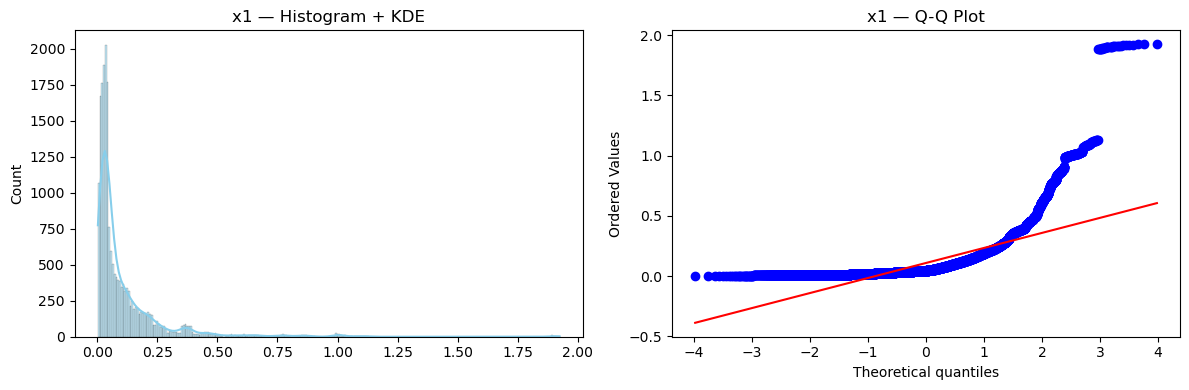

❌ x2: A² = 2399.801, critical @5% = 0.787


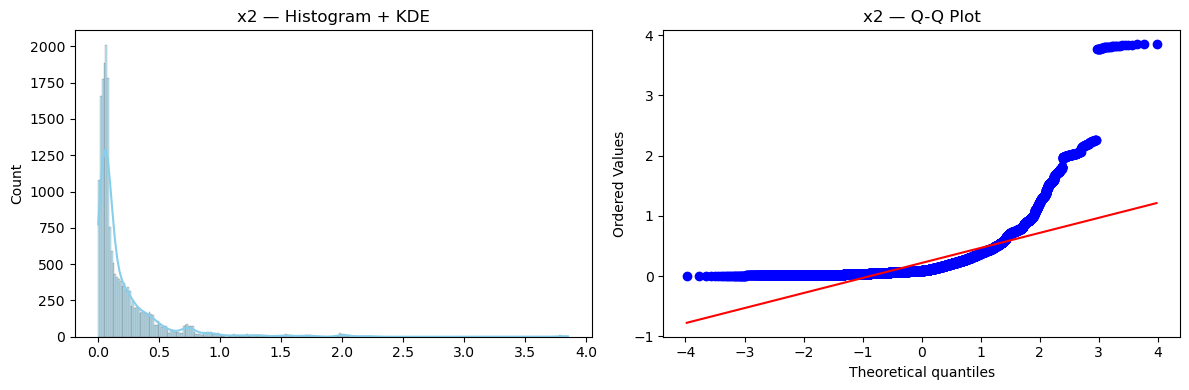

❌ x3: A² = 2399.799, critical @5% = 0.787


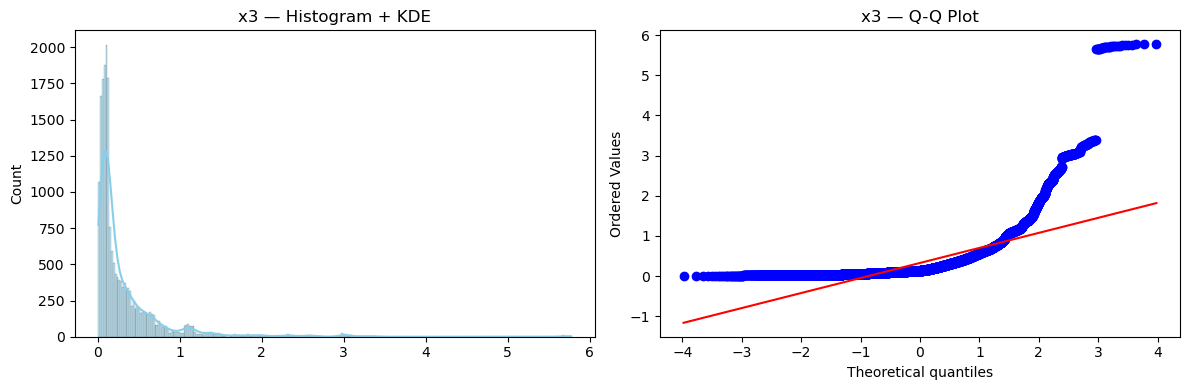

❌ x4: A² = 2399.806, critical @5% = 0.787


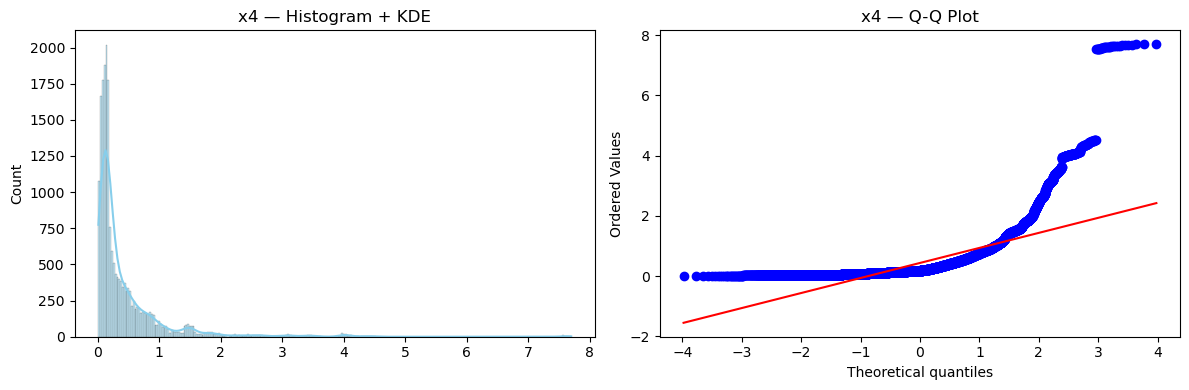

❌ x5: A² = 2399.800, critical @5% = 0.787


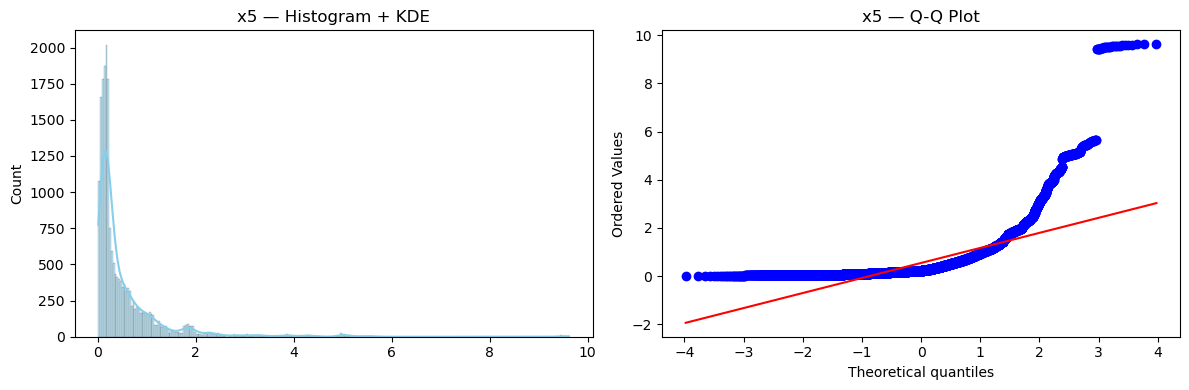

❌ x6: A² = 2399.804, critical @5% = 0.787


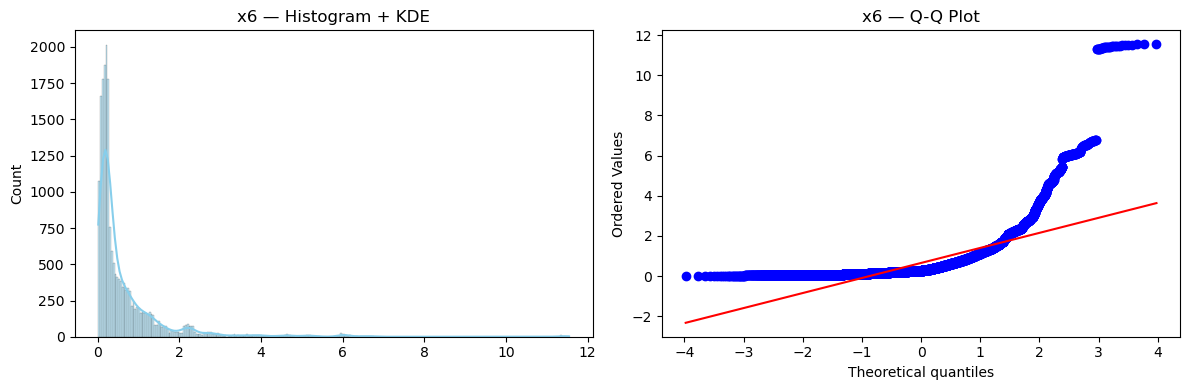

❌ x7: A² = 2399.803, critical @5% = 0.787


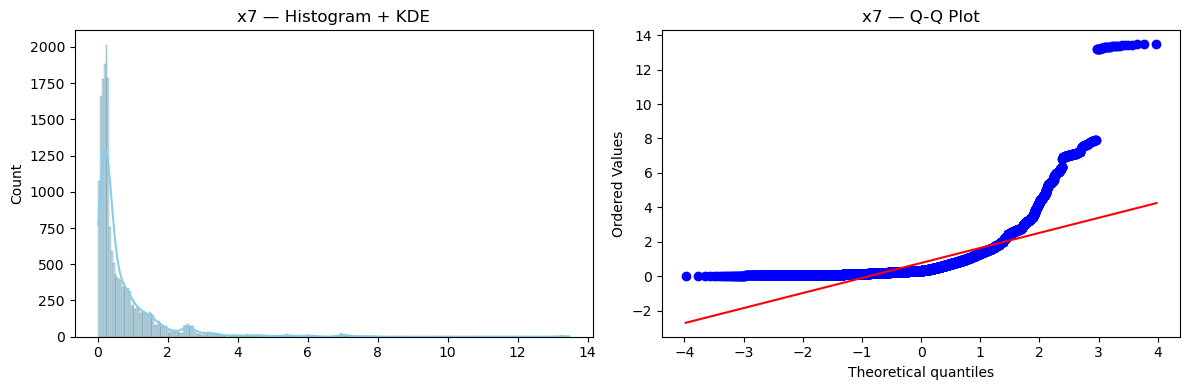

❌ x8: A² = 2399.799, critical @5% = 0.787


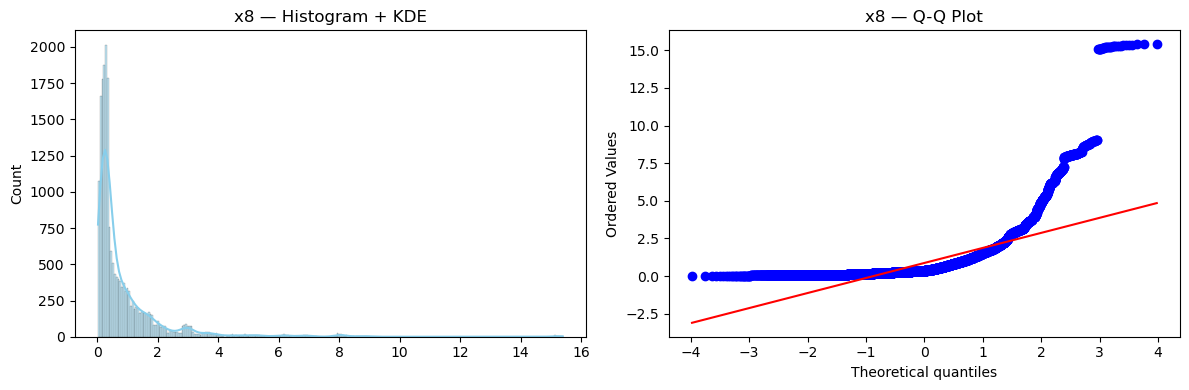

❌ x9: A² = 2399.801, critical @5% = 0.787


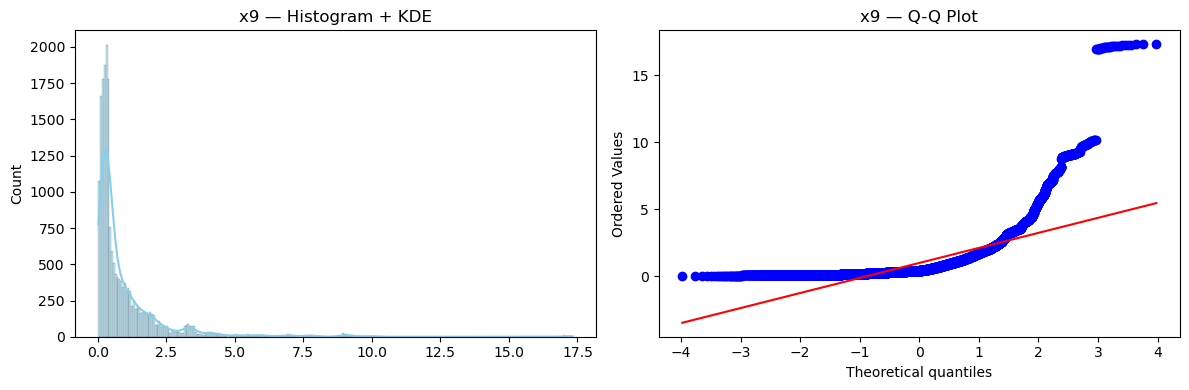

❌ x10: A² = 2399.801, critical @5% = 0.787


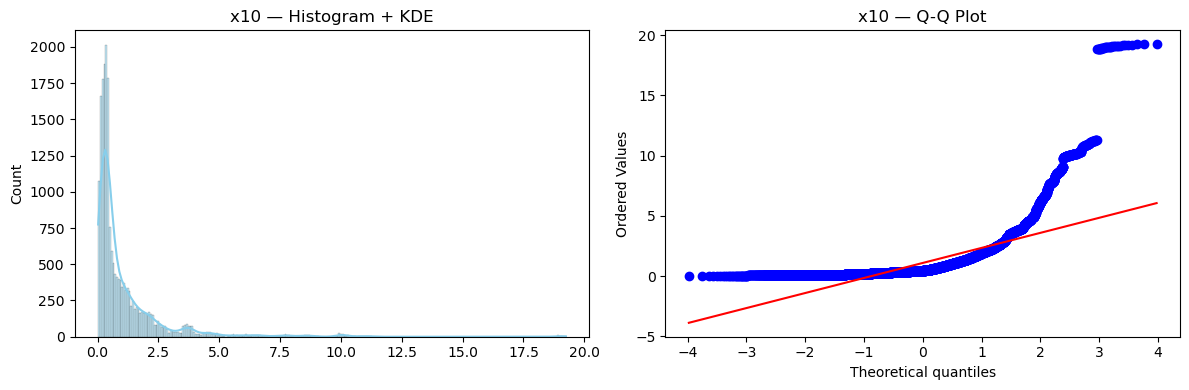

❌ x11: A² = 2399.805, critical @5% = 0.787


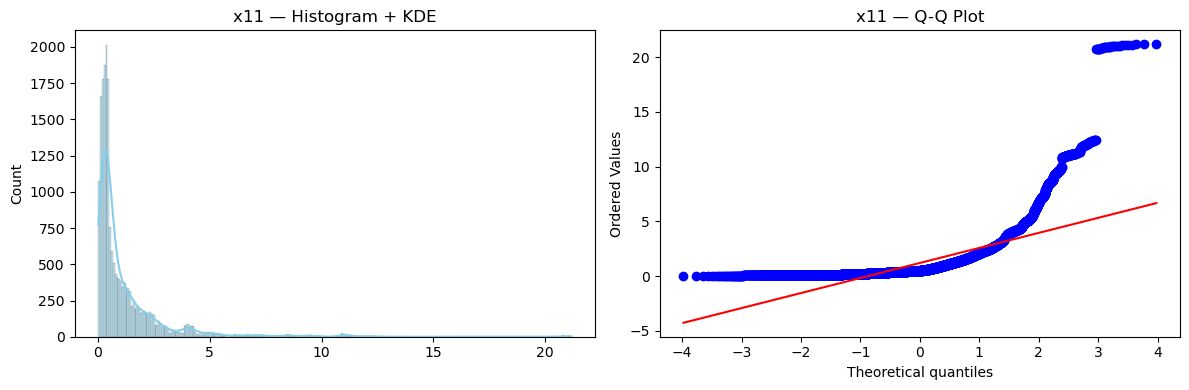

❌ x12: A² = 2399.803, critical @5% = 0.787


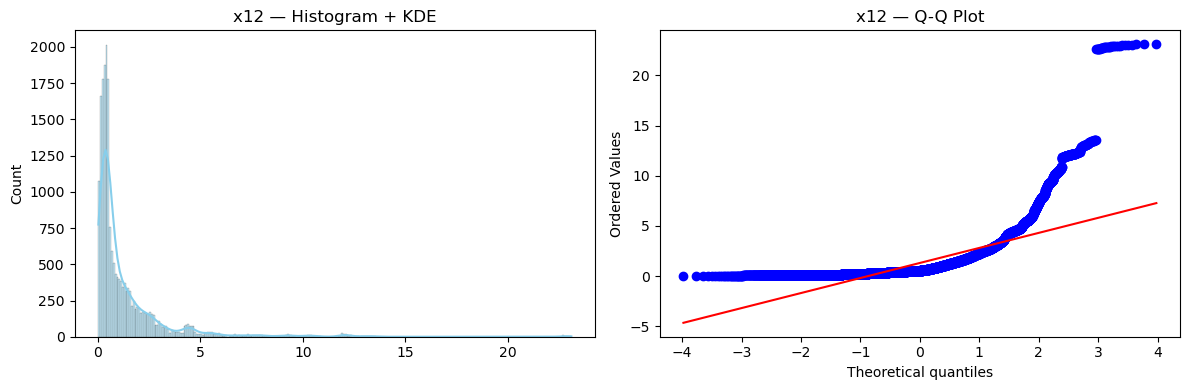

❌ x13: A² = 2399.803, critical @5% = 0.787


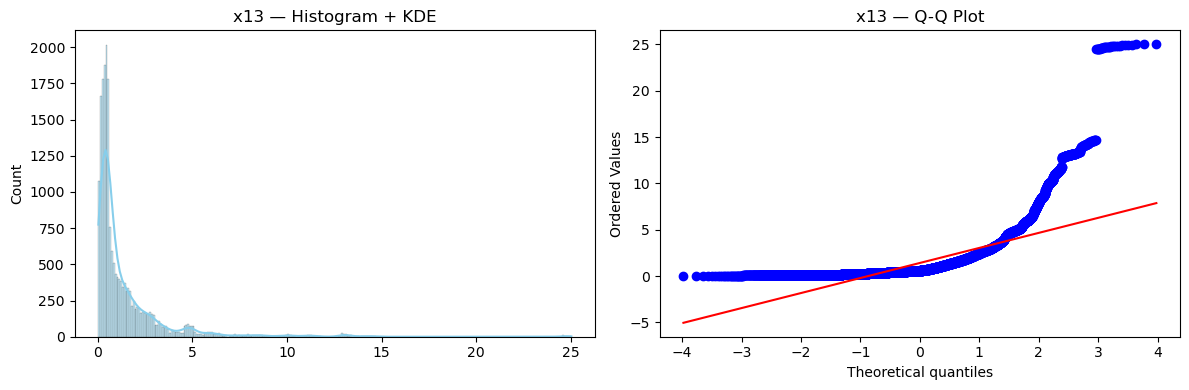

❌ x14: A² = 2399.799, critical @5% = 0.787


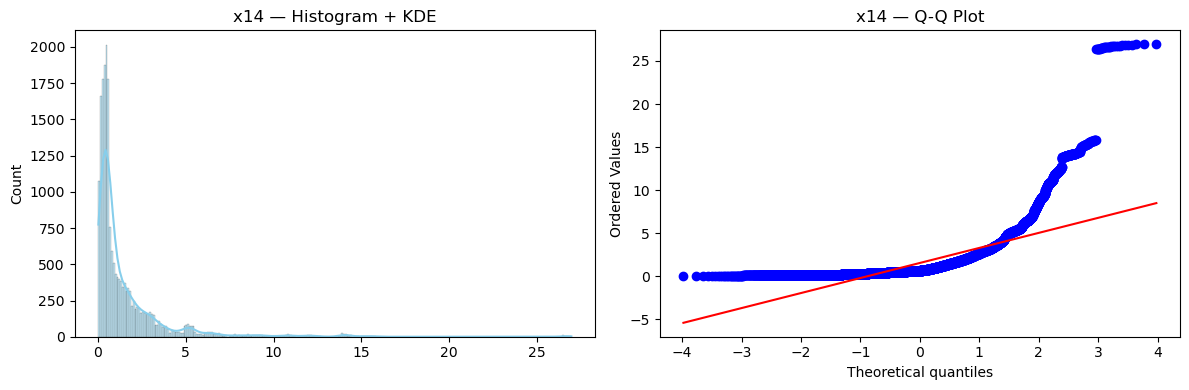

❌ x15: A² = 2399.800, critical @5% = 0.787


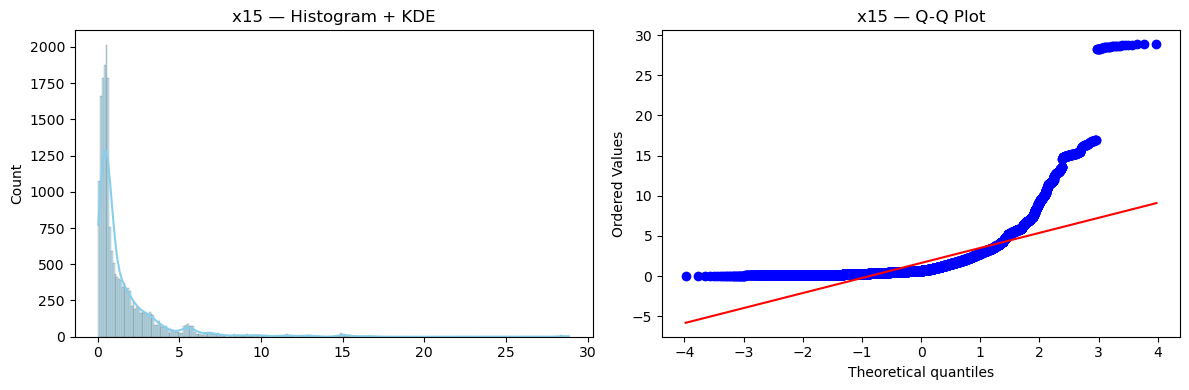

❌ x16: A² = 2399.803, critical @5% = 0.787


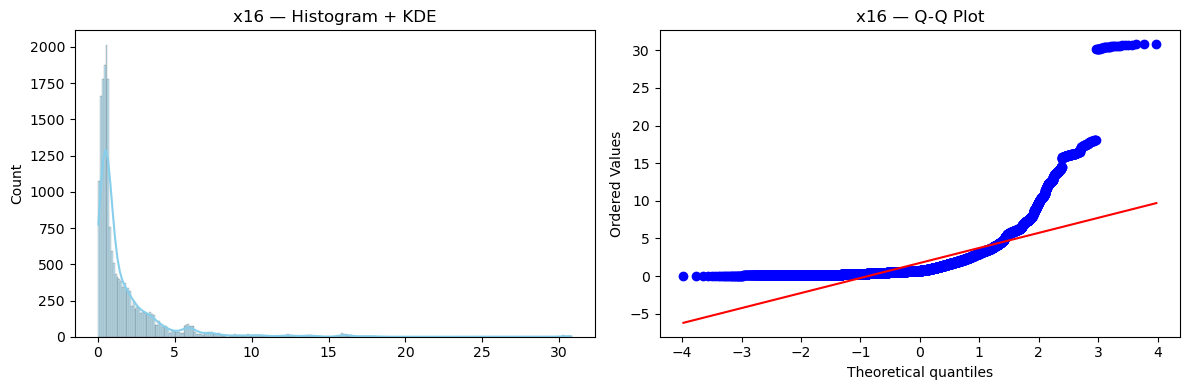

❌ x17: A² = 2399.800, critical @5% = 0.787


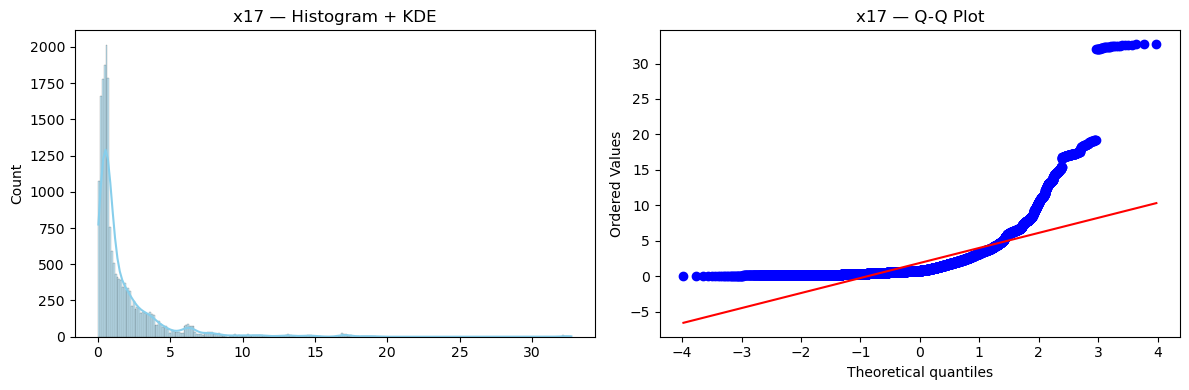

❌ x18: A² = 2399.801, critical @5% = 0.787


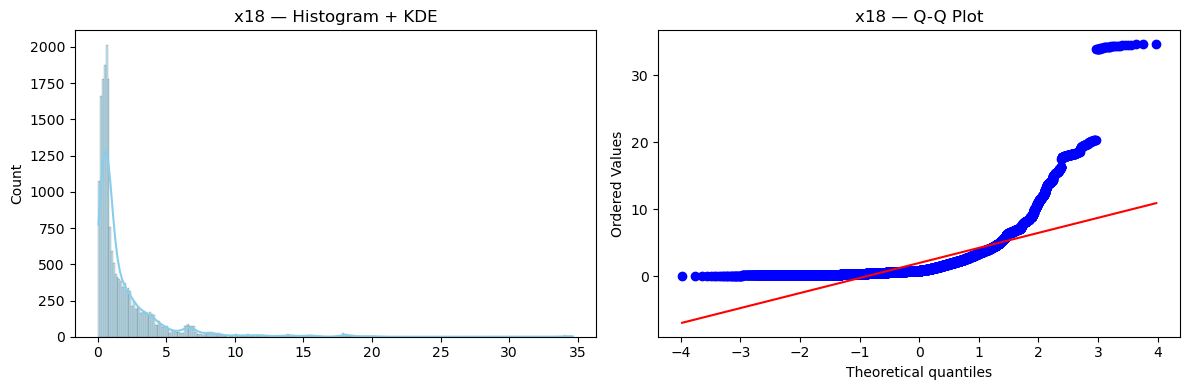

❌ x19: A² = 2399.802, critical @5% = 0.787


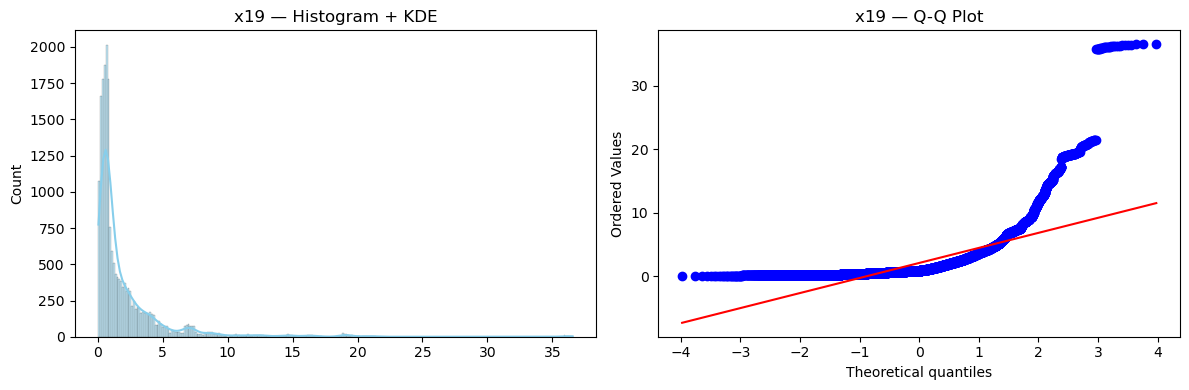

❌ x20: A² = 2399.801, critical @5% = 0.787


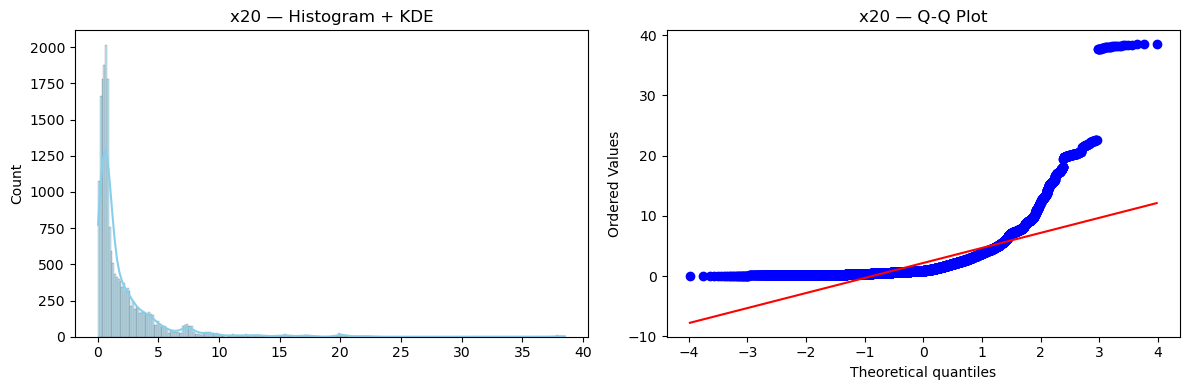

❌ x21: A² = 2399.803, critical @5% = 0.787


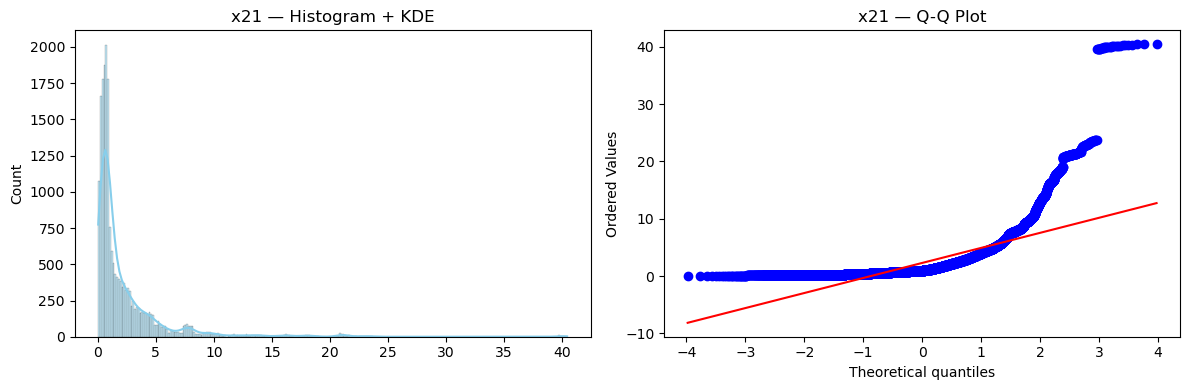

❌ x22: A² = 2399.802, critical @5% = 0.787


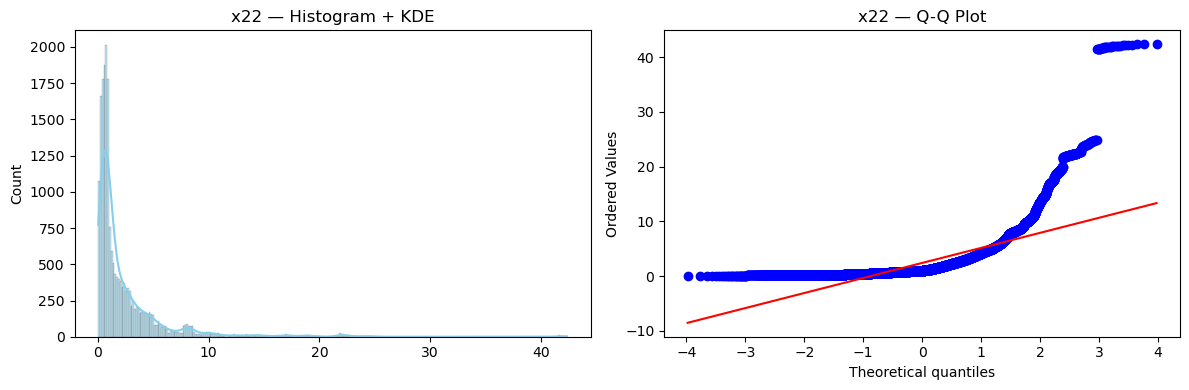

❌ x23: A² = 2399.802, critical @5% = 0.787


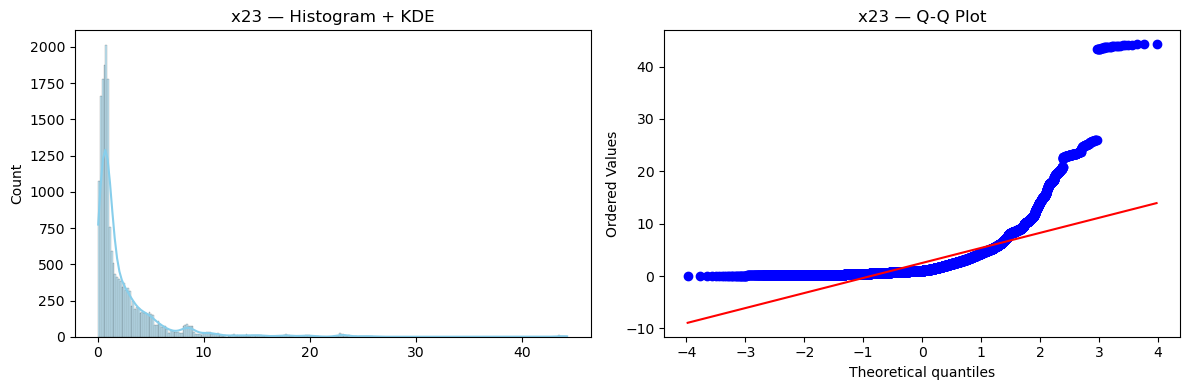

❌ x24: A² = 2399.802, critical @5% = 0.787


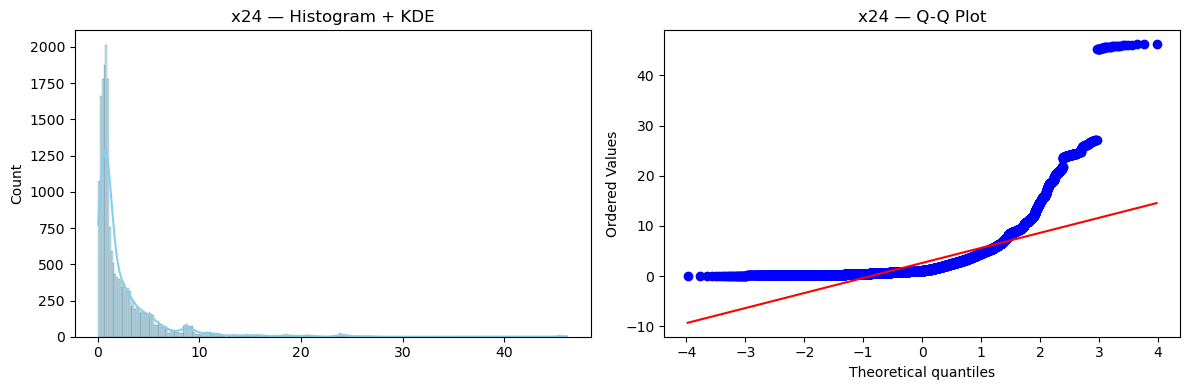

❌ x25: A² = 2399.803, critical @5% = 0.787


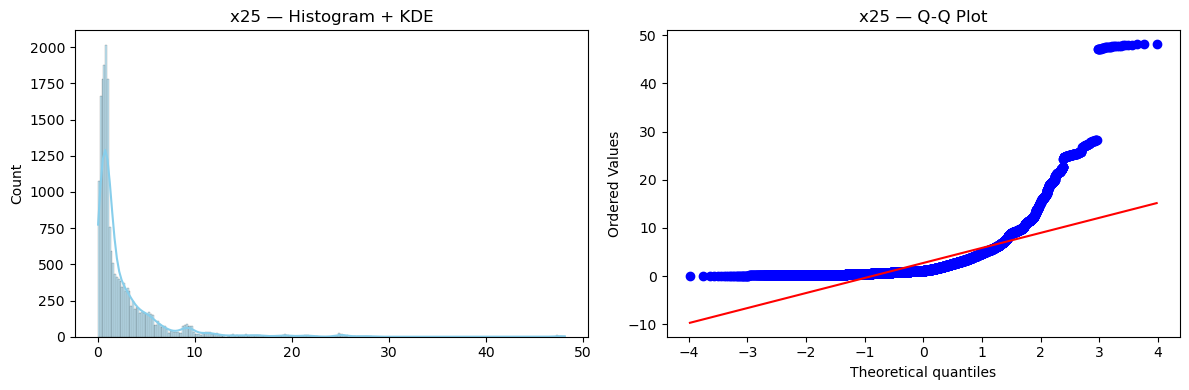

❌ x26: A² = 2638.713, critical @5% = 0.787


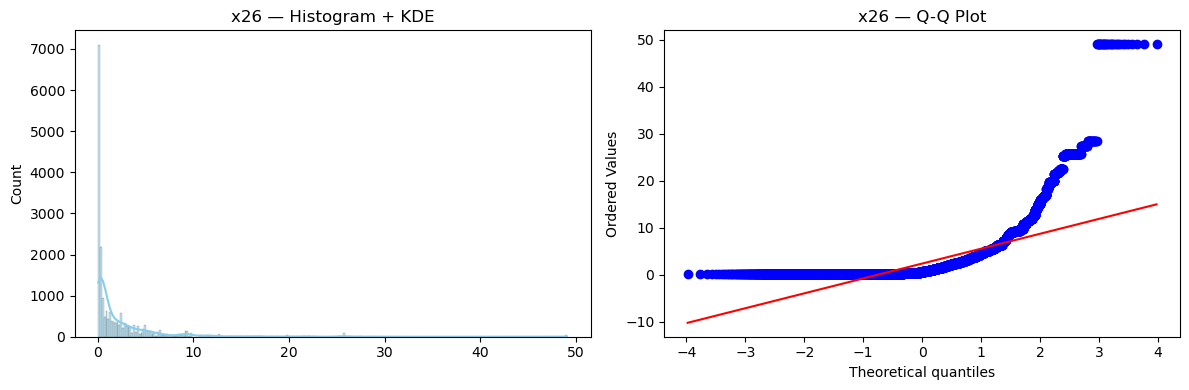

❌ y1: A² = 1780.528, critical @5% = 0.787


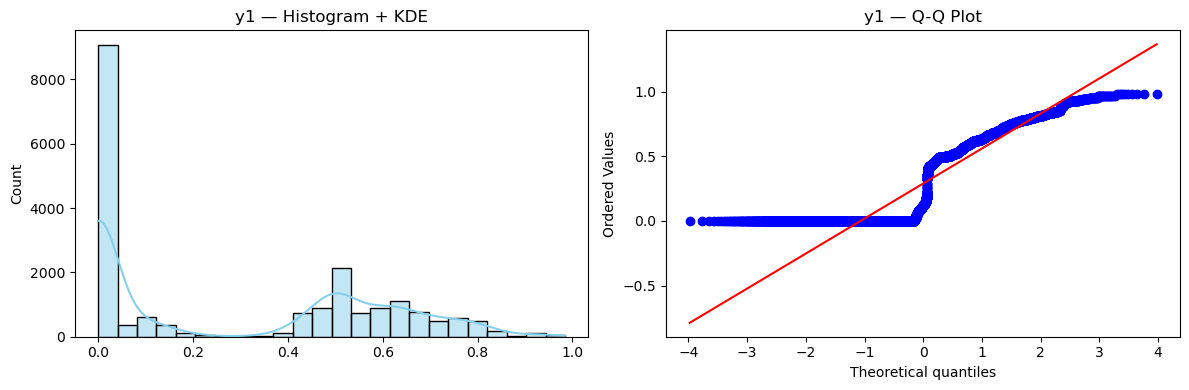

❌ y2: A² = 1933.873, critical @5% = 0.787


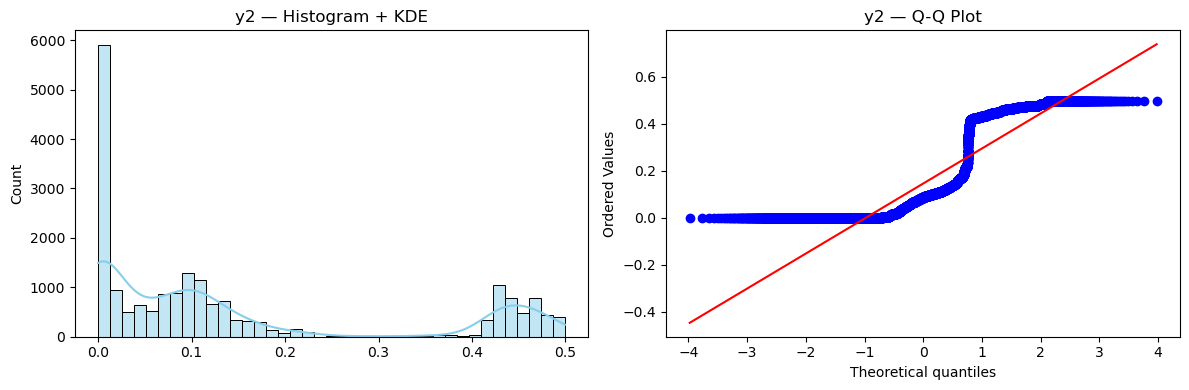

❌ y3: A² = 2433.326, critical @5% = 0.787


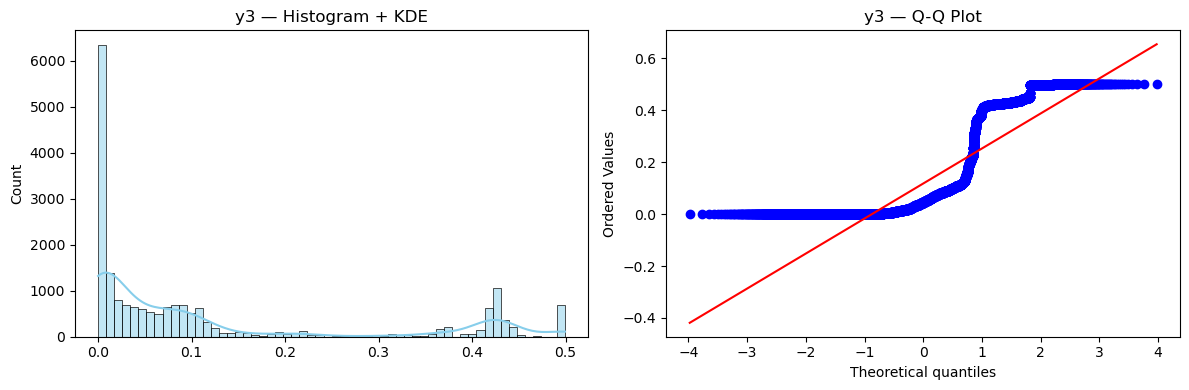

❌ y4: A² = 2040.810, critical @5% = 0.787


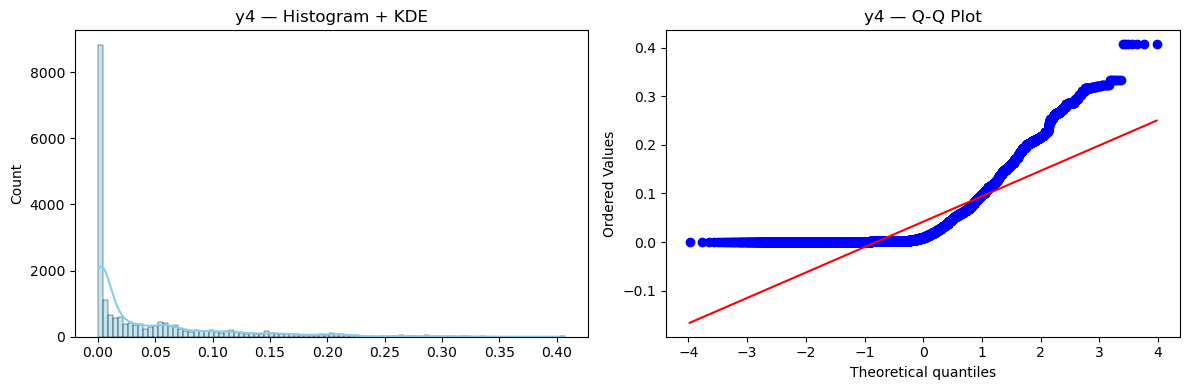

❌ y5: A² = 2158.020, critical @5% = 0.787


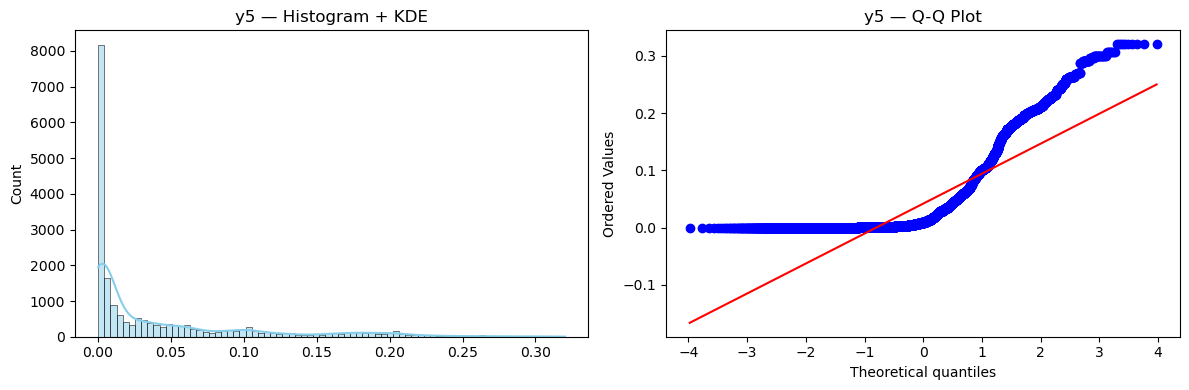

❌ y6: A² = 1866.132, critical @5% = 0.787


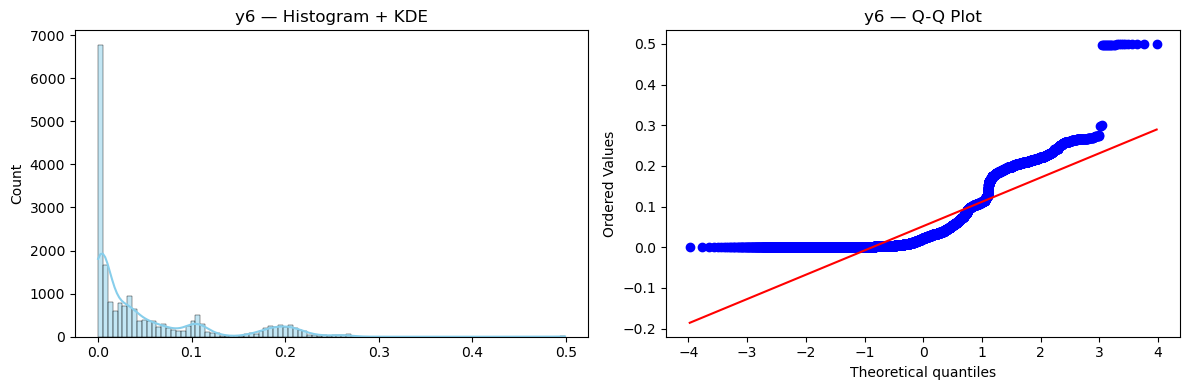

❌ y7: A² = 1932.839, critical @5% = 0.787


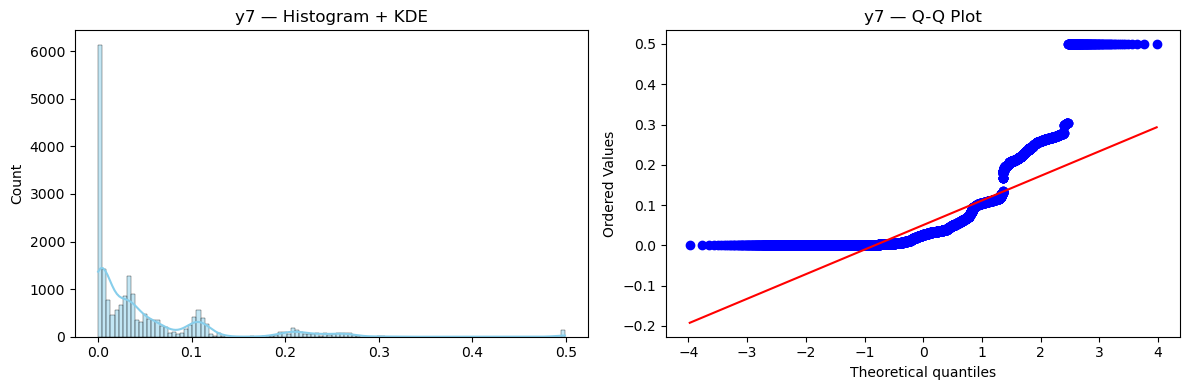

❌ y8: A² = 1529.941, critical @5% = 0.787


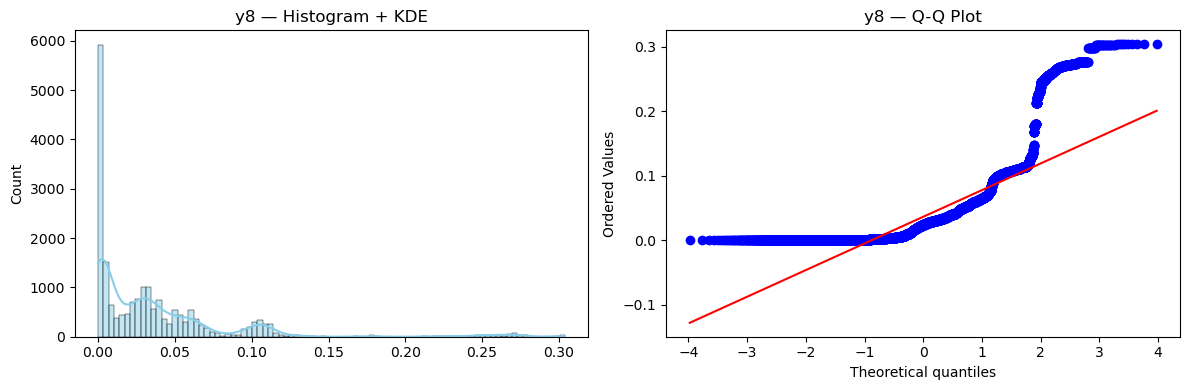

❌ y9: A² = 1392.197, critical @5% = 0.787


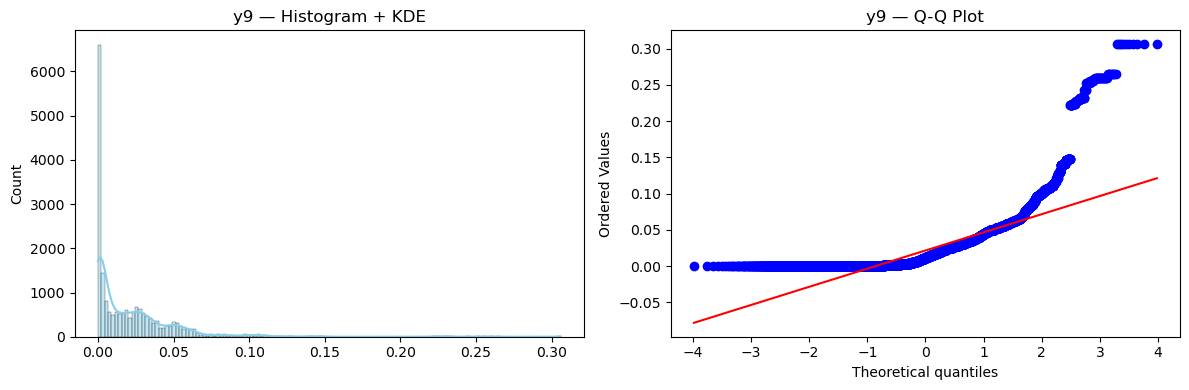

❌ y10: A² = 1405.653, critical @5% = 0.787


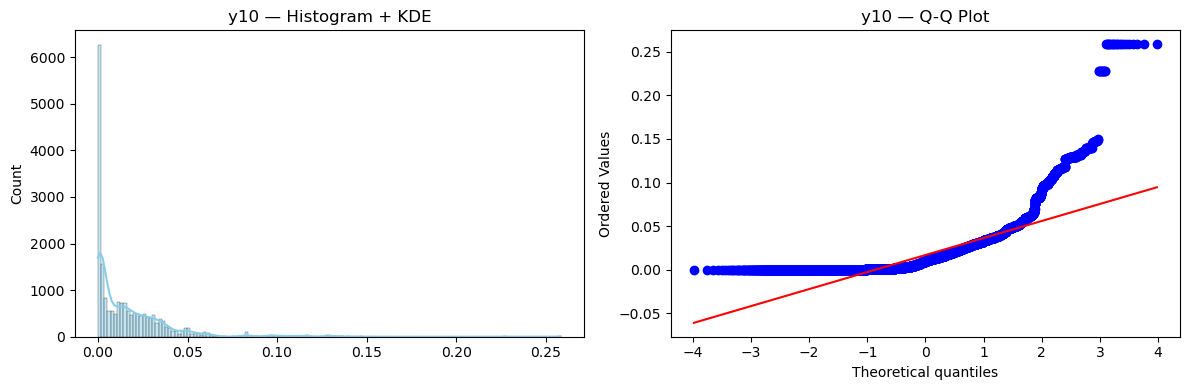

❌ y11: A² = 1738.646, critical @5% = 0.787


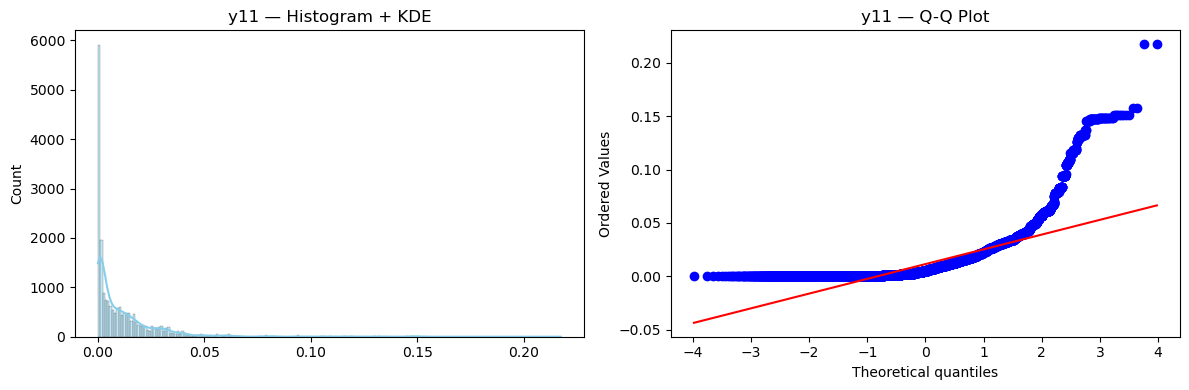

❌ y12: A² = 2402.063, critical @5% = 0.787


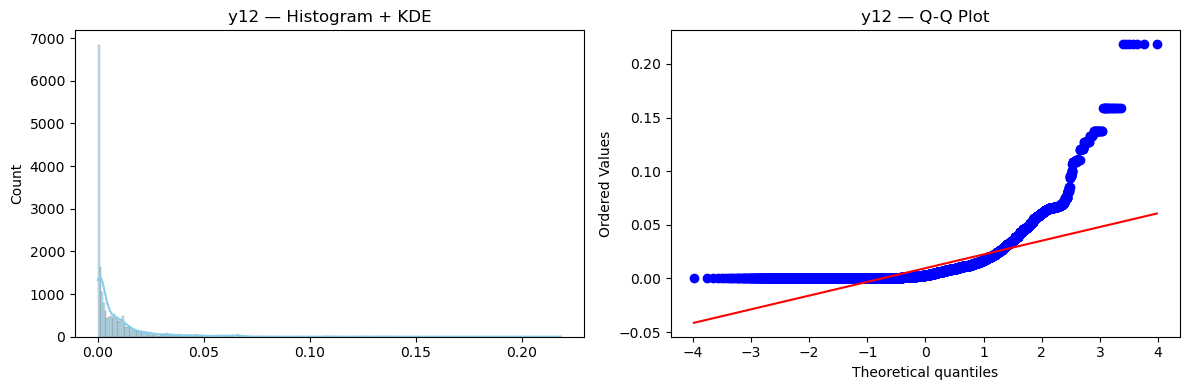

❌ y13: A² = 2340.767, critical @5% = 0.787


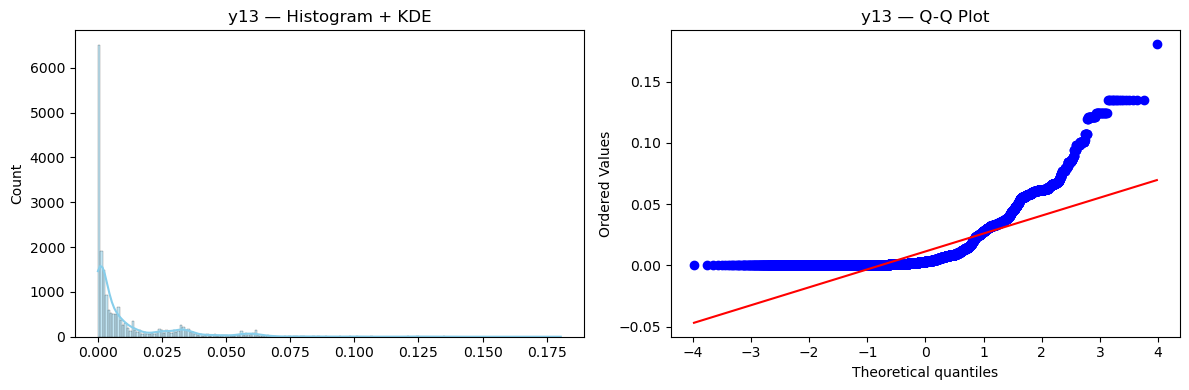

❌ y14: A² = 2314.062, critical @5% = 0.787


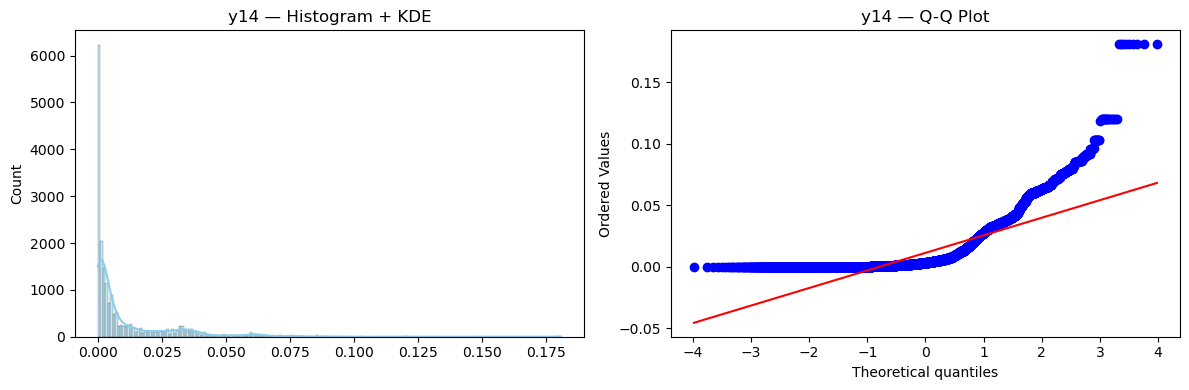

❌ y15: A² = 2399.470, critical @5% = 0.787


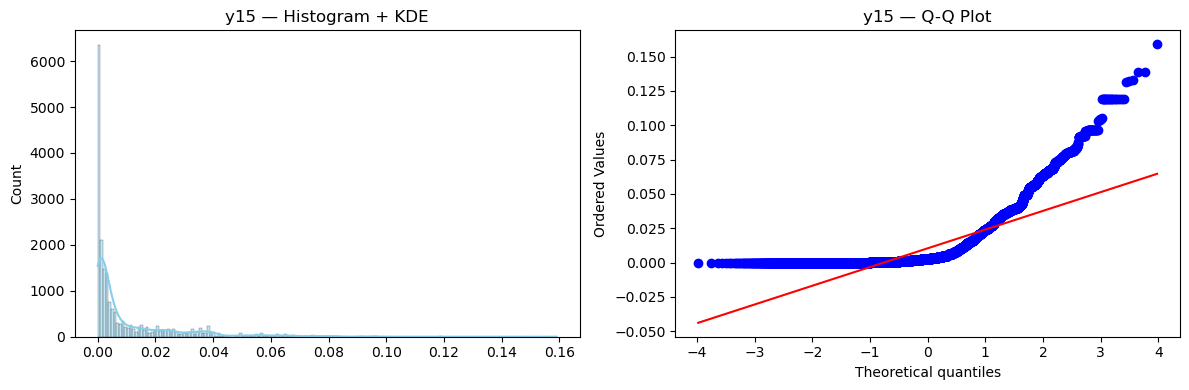

❌ y16: A² = 2875.268, critical @5% = 0.787


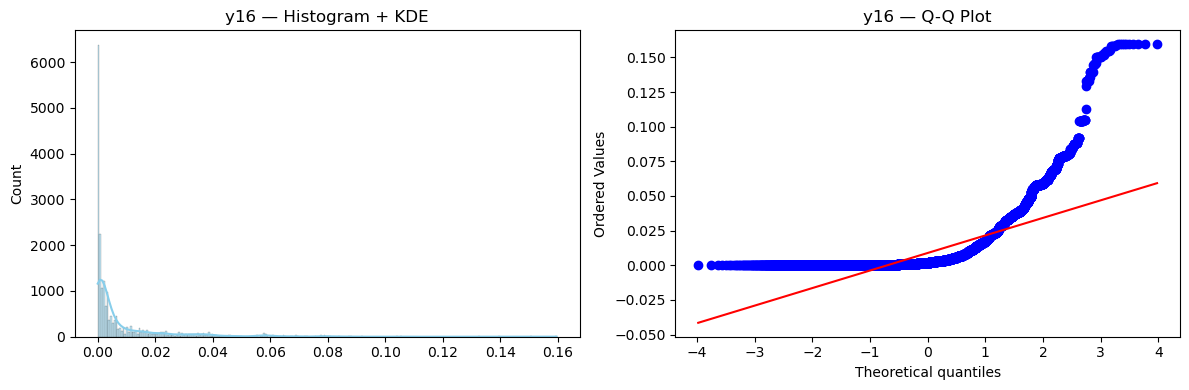

❌ y17: A² = 3013.267, critical @5% = 0.787


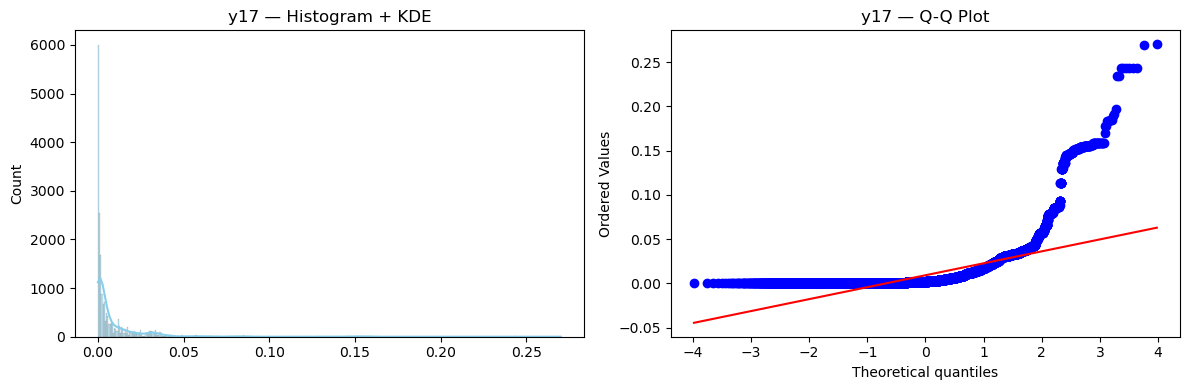

❌ y18: A² = 3856.151, critical @5% = 0.787


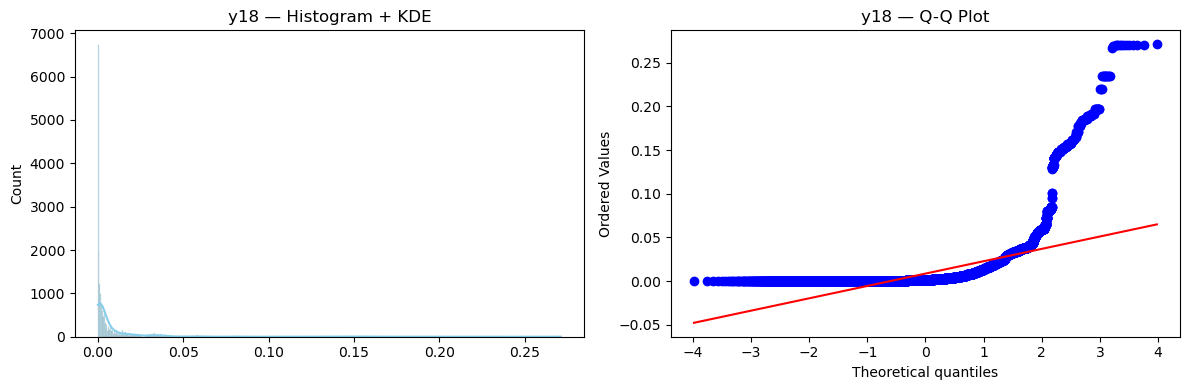

❌ y19: A² = 4659.507, critical @5% = 0.787


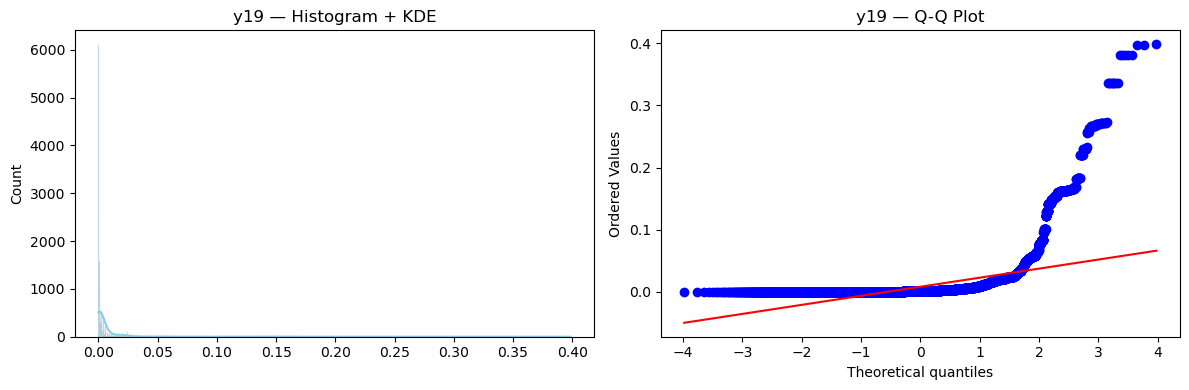

❌ y20: A² = 4438.247, critical @5% = 0.787


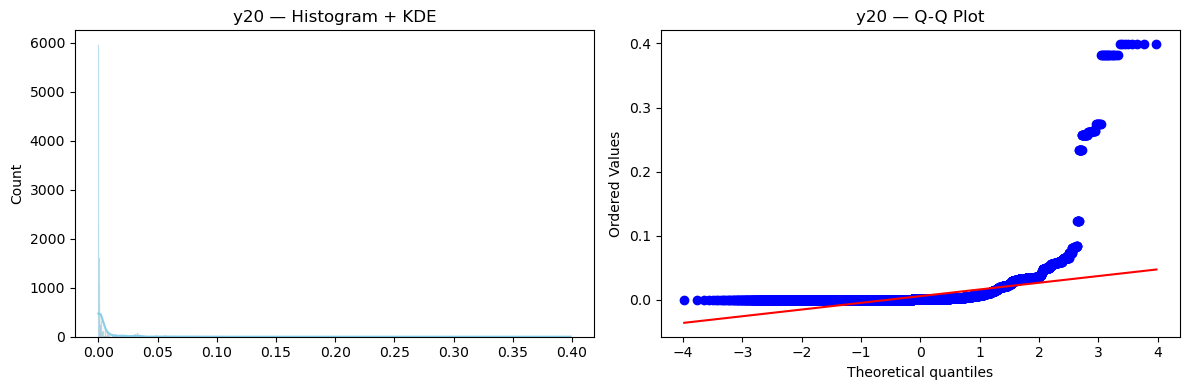

❌ y21: A² = 4845.180, critical @5% = 0.787


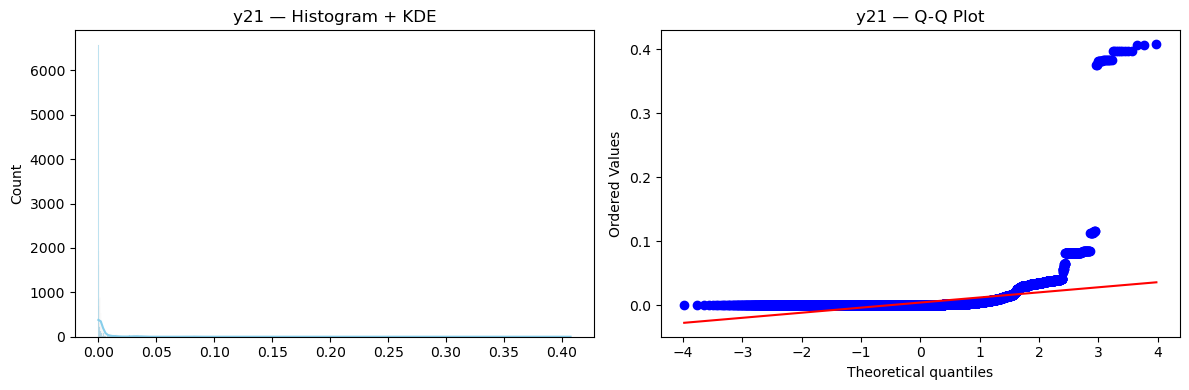

❌ y22: A² = 5018.962, critical @5% = 0.787


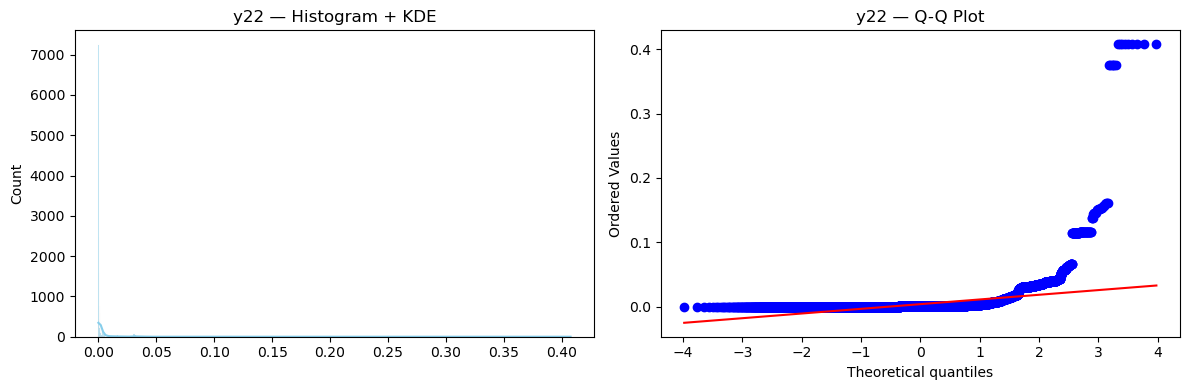

❌ y23: A² = 5581.577, critical @5% = 0.787


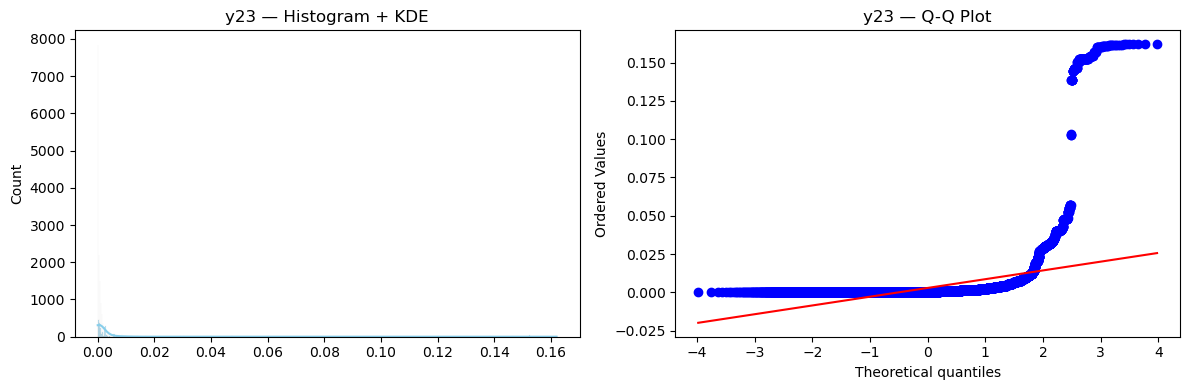

❌ y24: A² = 4922.101, critical @5% = 0.787


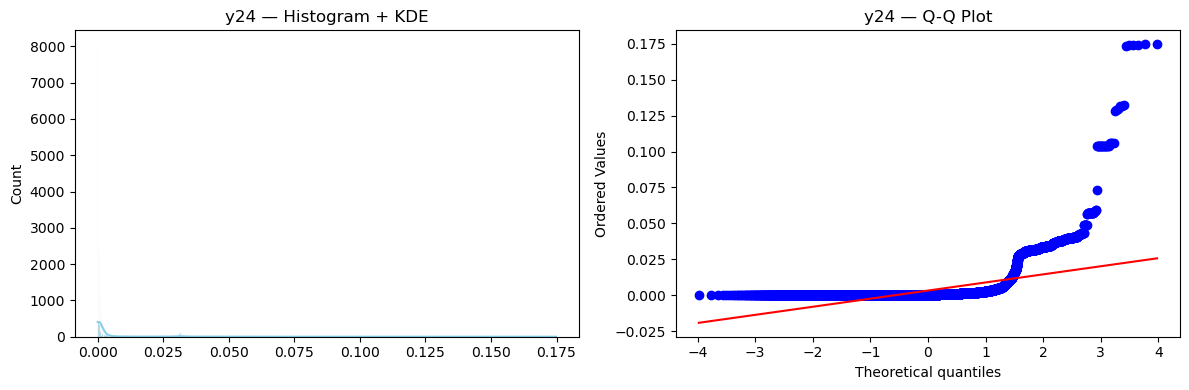

❌ y25: A² = 5187.805, critical @5% = 0.787


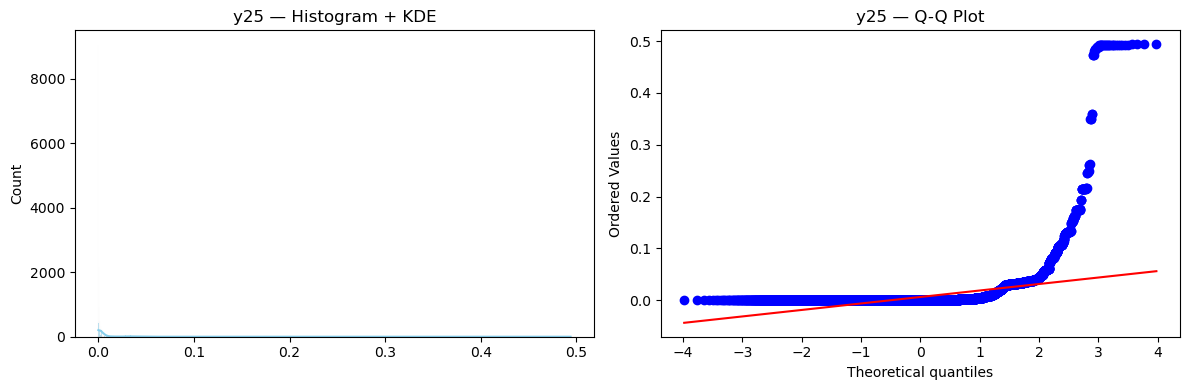

❌ y26: A² = 4447.064, critical @5% = 0.787


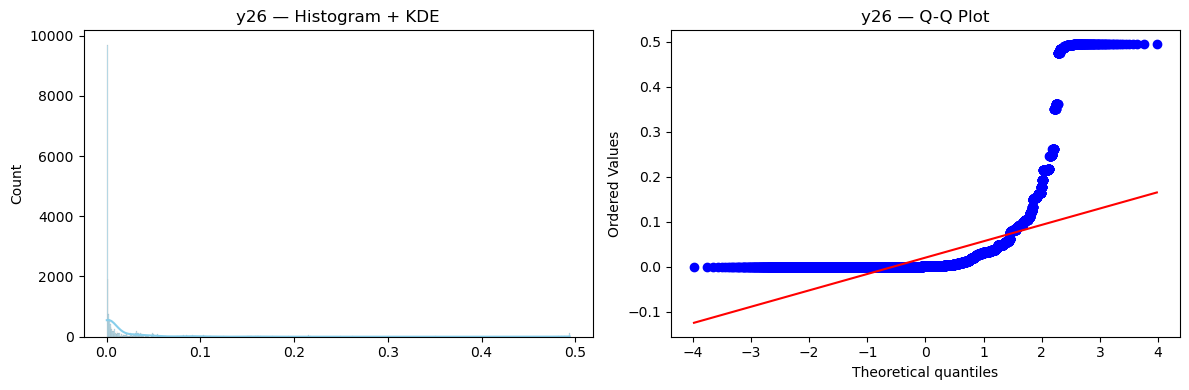

❌ s: A² = 3489.549, critical @5% = 0.787


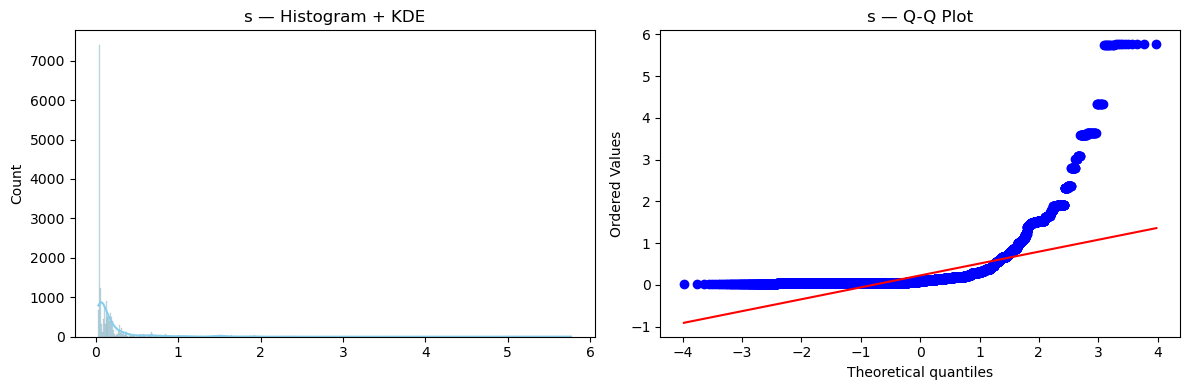

❌ r: A² = 1635.516, critical @5% = 0.787


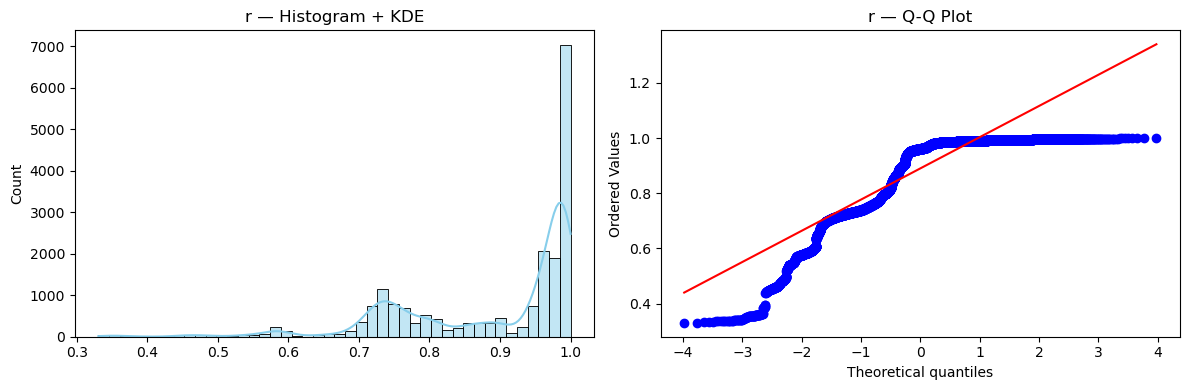

In [8]:
# Extract all feature columns (excluding the label)
features = df.drop(columns="l").columns
raw_a2_stats = {}  # Store A² values per feature for later comparison

def plot_feature_normality(df, features, alpha=0.05):
    for feature in features:
        data = df[feature].dropna().values  # Remove NaNs if any

        # === Anderson-Darling test for normality ===
        ad_result = anderson(data, dist='norm')
        stat = ad_result.statistic                      # A² statistic
        crit_val_5 = ad_result.critical_values[2]       # Critical value at 5% level
        is_normal = stat < crit_val_5                   # Normal if A² < critical value
        status = "✅" if is_normal else "❌"             # For printout display

        # Save test statistic for analysis/comparison
        raw_a2_stats[feature] = stat

        # Print result for this feature
        print(f"{status} {feature}: A² = {stat:.3f}, critical @5% = {crit_val_5:.3f}")

        # === Plot histograms and Q-Q plot ===
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        # Histogram with KDE curve
        sns.histplot(data, kde=True, ax=axs[0], color='skyblue')
        axs[0].set_title(f"{feature} — Histogram + KDE")

        # Q-Q Plot vs normal distribution
        stats.probplot(data, dist="norm", plot=axs[1])
        axs[1].set_title(f"{feature} — Q-Q Plot")

        plt.tight_layout()
        plt.show()

# Execute the analysis
plot_feature_normality(df, features)


## 🔄 Feature Normalization: Search for Best Normalizing Transformation

To improve the performance of machine learning models, we aim to **normalize** each feature's distribution as much as possible.

We try multiple transformations per feature and choose the one that produces the **lowest Anderson-Darling statistic (A²)**:

### 🔧 Transformations Tried:
- **Box-Cox** (only if x > 0)
- **Log** and **log1p** (only if x ≥ 0)
- **Yeo-Johnson** (always safe)
- **Quantile-based transformation** using best-fitting theoretical distribution (e.g., gamma, beta, etc.)

For each feature:
- We select the best transformation
- Plot its histogram + KDE and Q-Q plot
- Print the normality result with A² and critical value at 5%

The final result is a transformed DataFrame `df_best_normalized` that retains the label column.


Selecting best transform:   0%|                          | 0/54 [00:00<?, ?it/s]

❌ x1: best = boxcox, A² = 45.798, crit @5% = 0.787


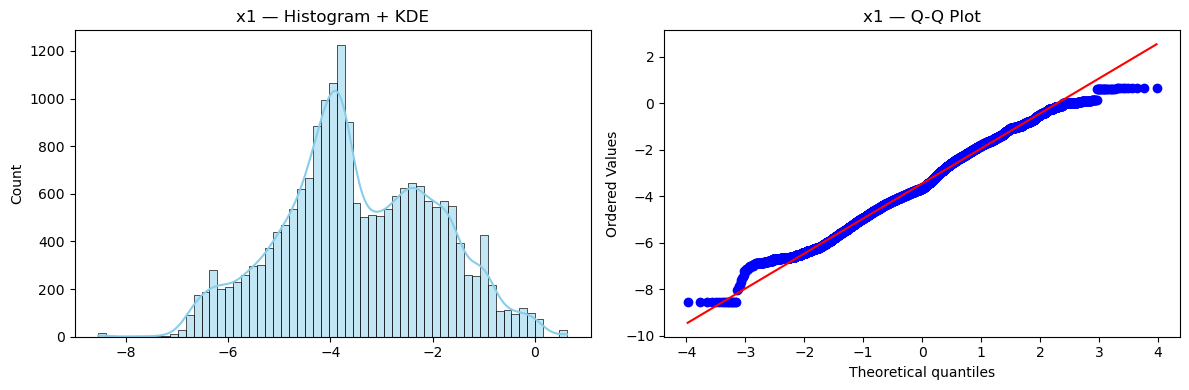

Selecting best transform:   2%|▎                 | 1/54 [00:01<01:16,  1.44s/it]

❌ x2: best = boxcox, A² = 45.785, crit @5% = 0.787


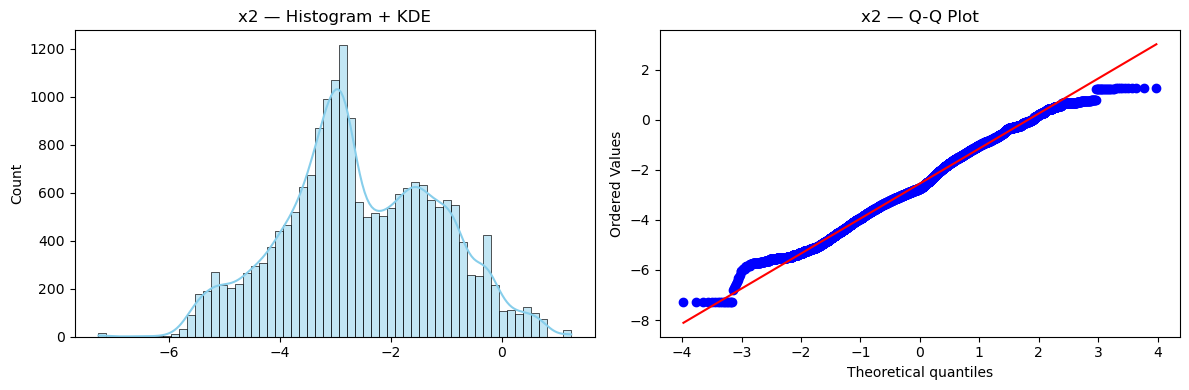

Selecting best transform:   4%|▋                 | 2/54 [00:02<01:06,  1.28s/it]

❌ x3: best = boxcox, A² = 45.784, crit @5% = 0.787


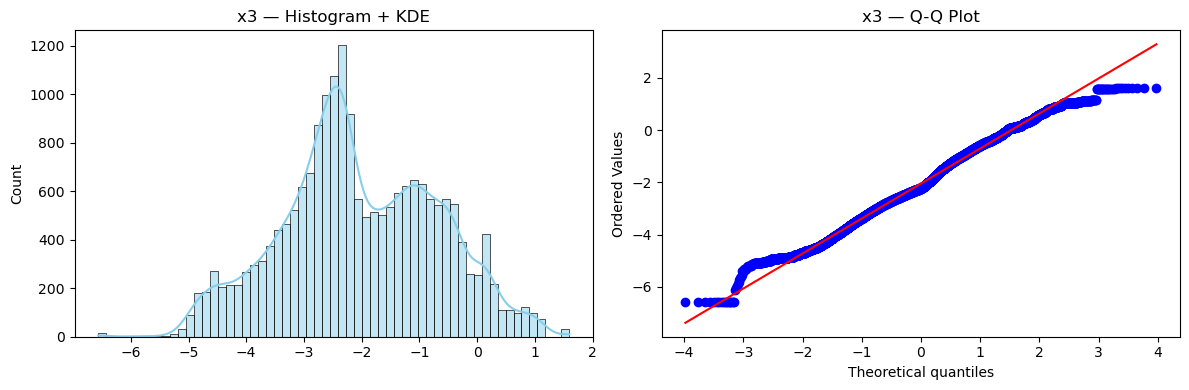

Selecting best transform:   6%|█                 | 3/54 [00:03<01:04,  1.25s/it]

❌ x4: best = boxcox, A² = 45.785, crit @5% = 0.787


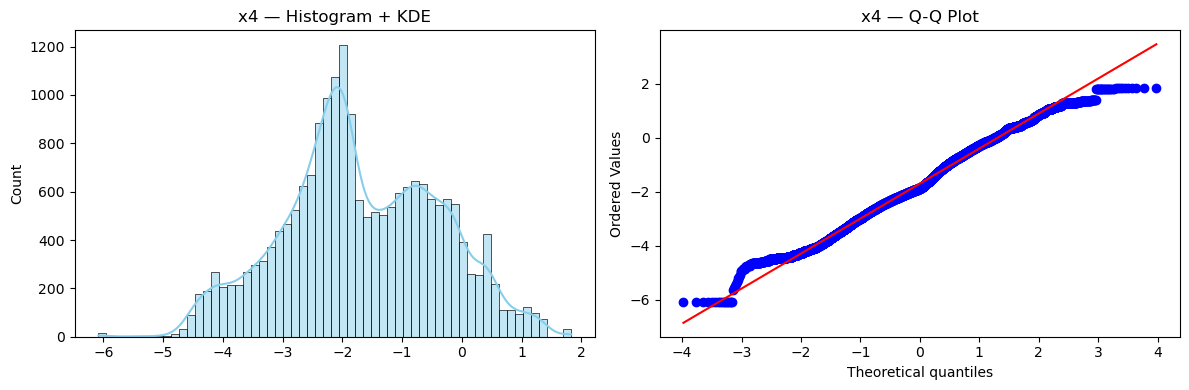

Selecting best transform:   7%|█▎                | 4/54 [00:05<01:02,  1.25s/it]

❌ x5: best = boxcox, A² = 45.783, crit @5% = 0.787


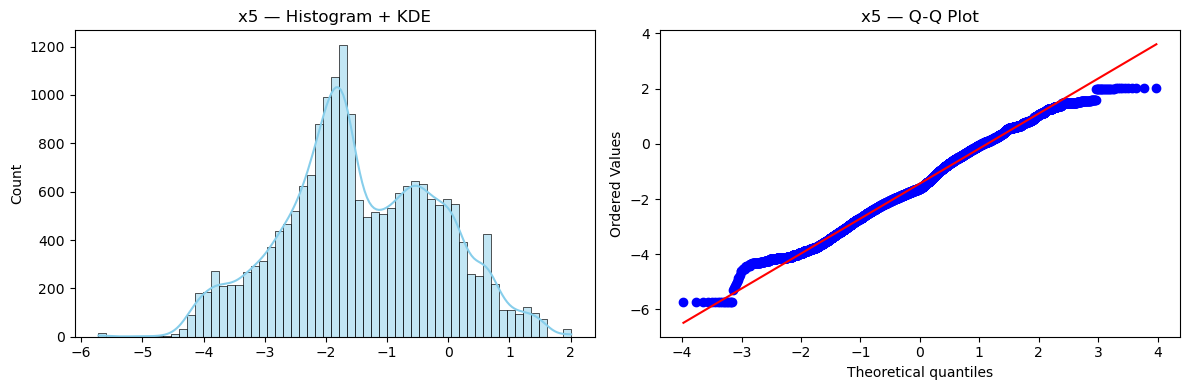

Selecting best transform:   9%|█▋                | 5/54 [00:06<01:00,  1.23s/it]

❌ x6: best = boxcox, A² = 45.783, crit @5% = 0.787


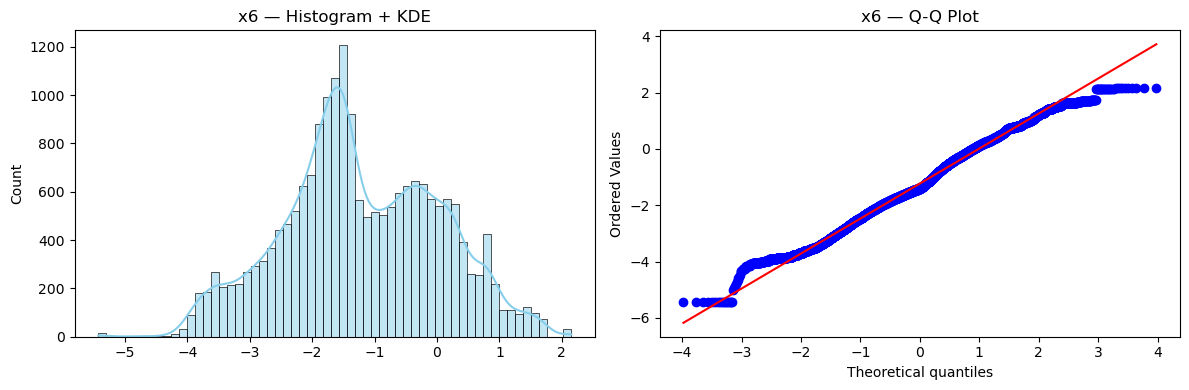

Selecting best transform:  11%|██                | 6/54 [00:07<00:57,  1.20s/it]

❌ x7: best = boxcox, A² = 45.784, crit @5% = 0.787


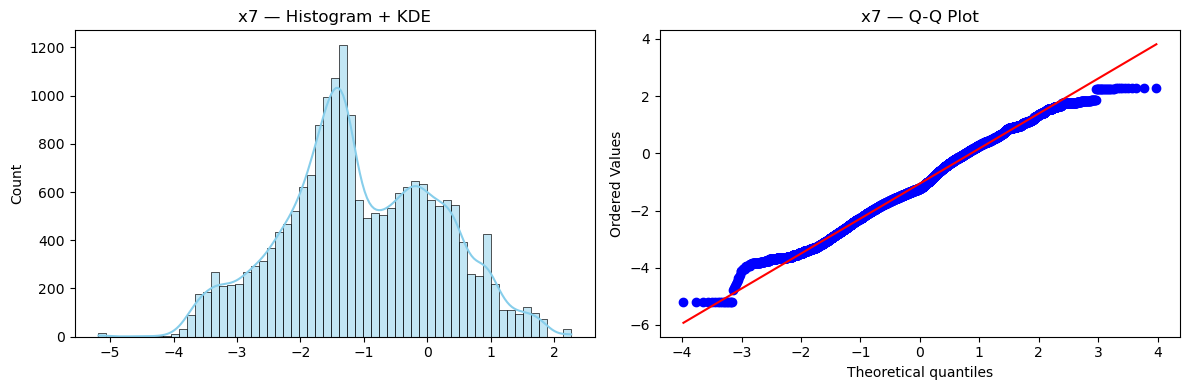

Selecting best transform:  13%|██▎               | 7/54 [00:08<00:53,  1.13s/it]

❌ x8: best = boxcox, A² = 45.785, crit @5% = 0.787


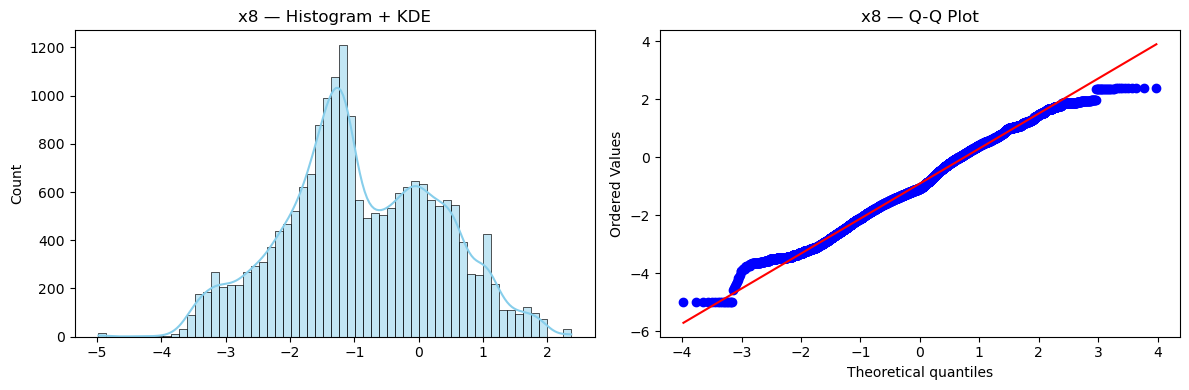

Selecting best transform:  15%|██▋               | 8/54 [00:09<00:51,  1.12s/it]

❌ x9: best = boxcox, A² = 45.786, crit @5% = 0.787


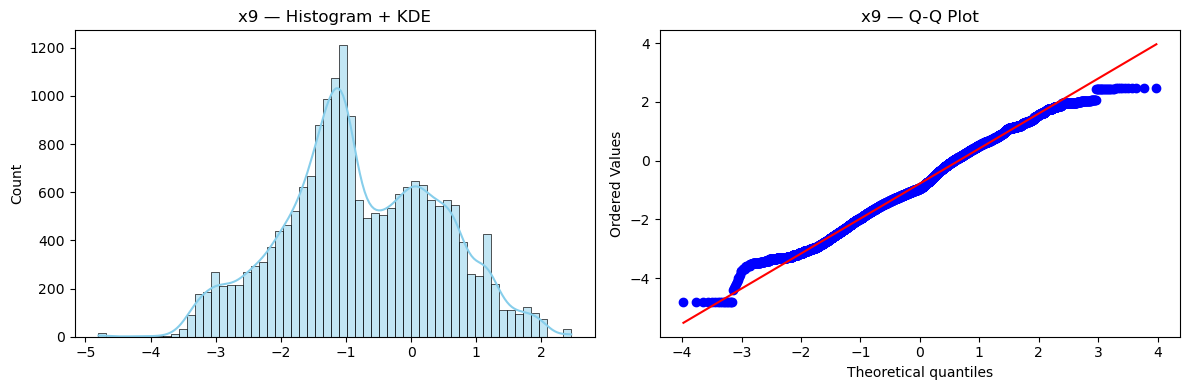

Selecting best transform:  17%|███               | 9/54 [00:10<00:49,  1.11s/it]

❌ x10: best = boxcox, A² = 45.784, crit @5% = 0.787


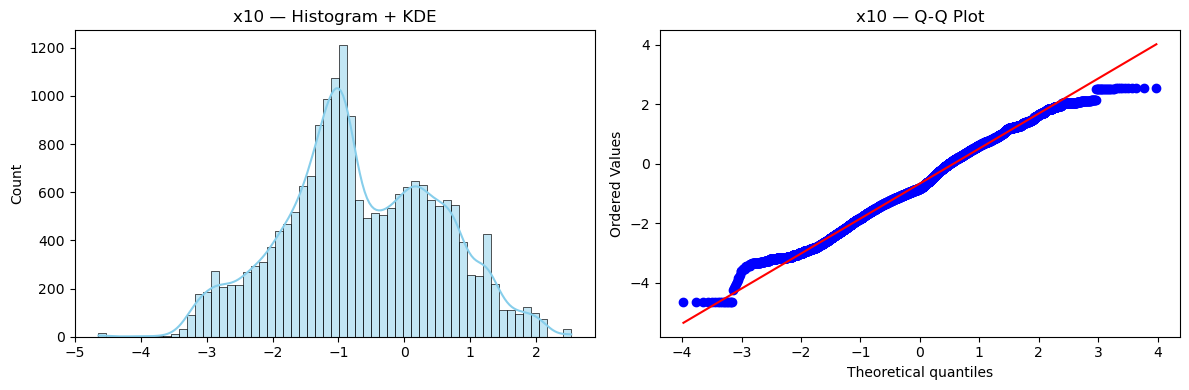

Selecting best transform:  19%|███▏             | 10/54 [00:11<00:48,  1.09s/it]

❌ x11: best = boxcox, A² = 45.785, crit @5% = 0.787


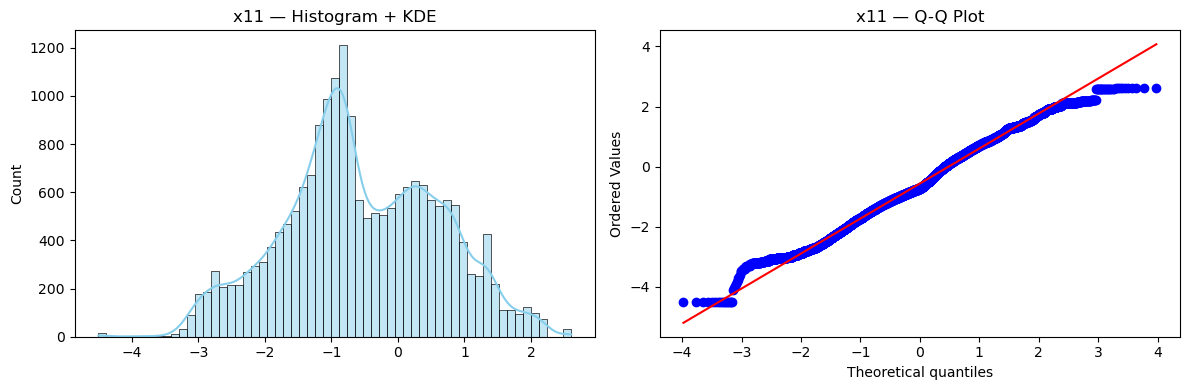

Selecting best transform:  20%|███▍             | 11/54 [00:12<00:45,  1.06s/it]

❌ x12: best = boxcox, A² = 45.784, crit @5% = 0.787


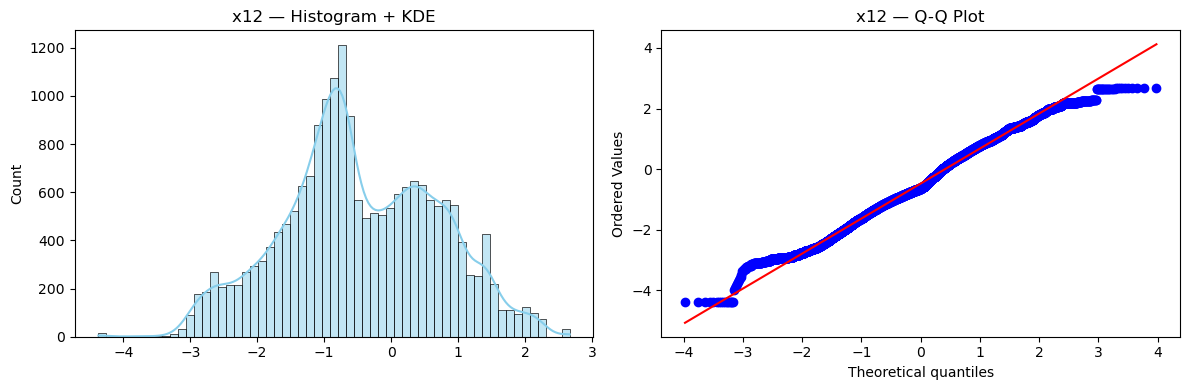

Selecting best transform:  22%|███▊             | 12/54 [00:13<00:44,  1.07s/it]

❌ x13: best = boxcox, A² = 45.784, crit @5% = 0.787


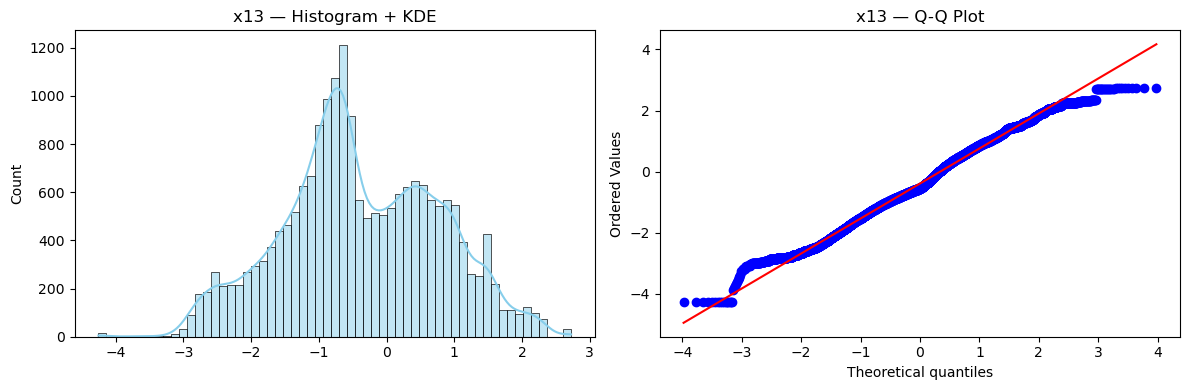

Selecting best transform:  24%|████             | 13/54 [00:14<00:43,  1.05s/it]

❌ x14: best = boxcox, A² = 45.784, crit @5% = 0.787


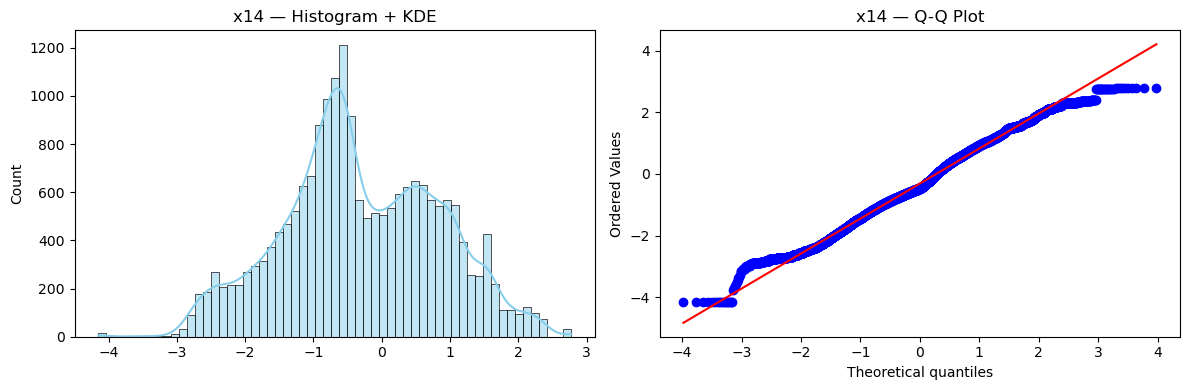

Selecting best transform:  26%|████▍            | 14/54 [00:15<00:41,  1.03s/it]

❌ x15: best = boxcox, A² = 45.784, crit @5% = 0.787


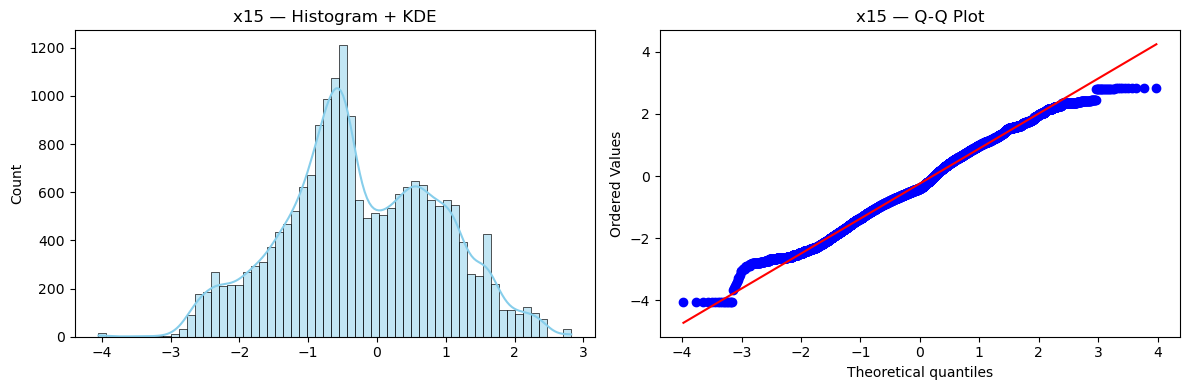

Selecting best transform:  28%|████▋            | 15/54 [00:16<00:41,  1.05s/it]

❌ x16: best = boxcox, A² = 45.784, crit @5% = 0.787


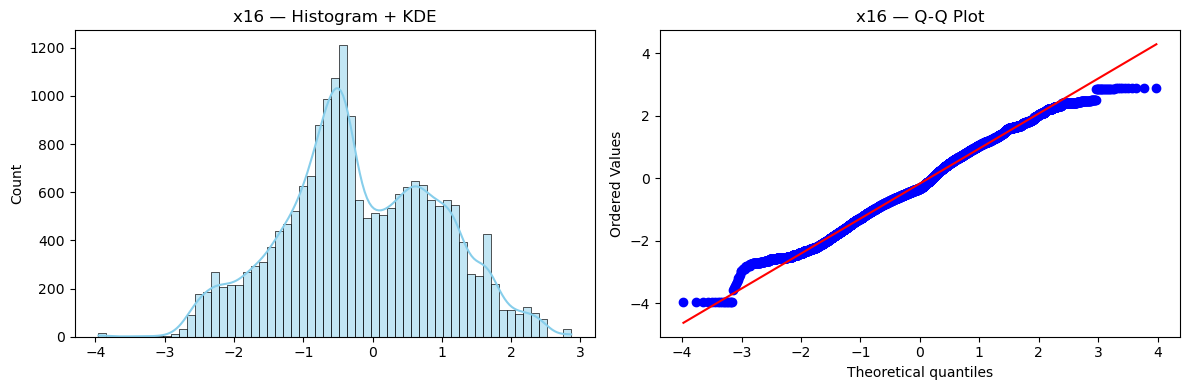

Selecting best transform:  30%|█████            | 16/54 [00:17<00:40,  1.06s/it]

❌ x17: best = boxcox, A² = 45.785, crit @5% = 0.787


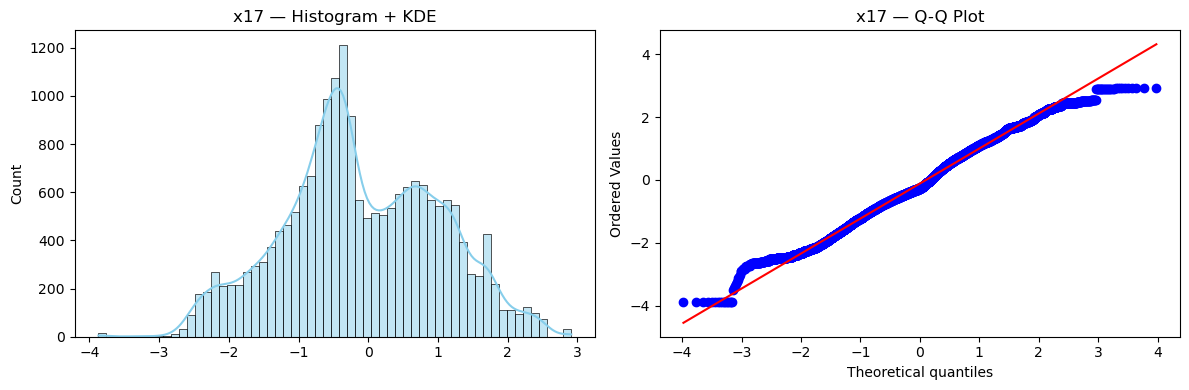

Selecting best transform:  31%|█████▎           | 17/54 [00:18<00:38,  1.05s/it]

❌ x18: best = boxcox, A² = 45.784, crit @5% = 0.787


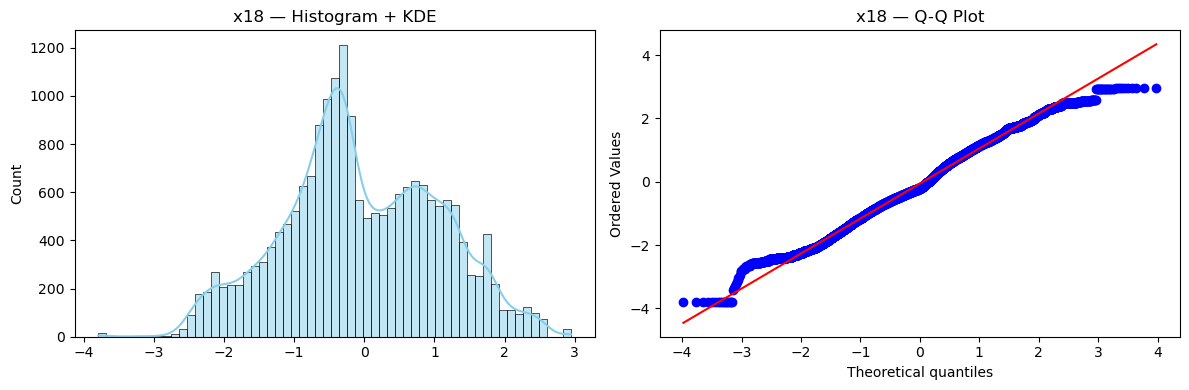

Selecting best transform:  33%|█████▋           | 18/54 [00:19<00:37,  1.03s/it]

❌ x19: best = boxcox, A² = 45.784, crit @5% = 0.787


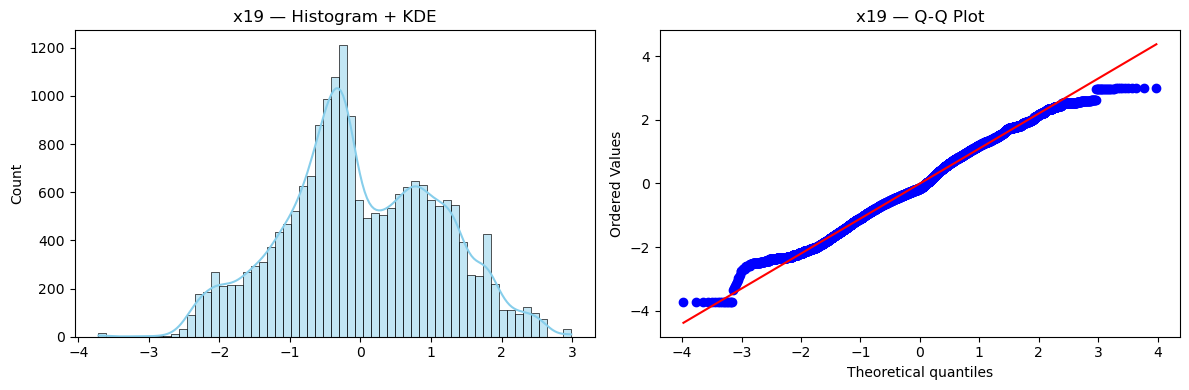

Selecting best transform:  35%|█████▉           | 19/54 [00:20<00:35,  1.02s/it]

❌ x20: best = boxcox, A² = 45.784, crit @5% = 0.787


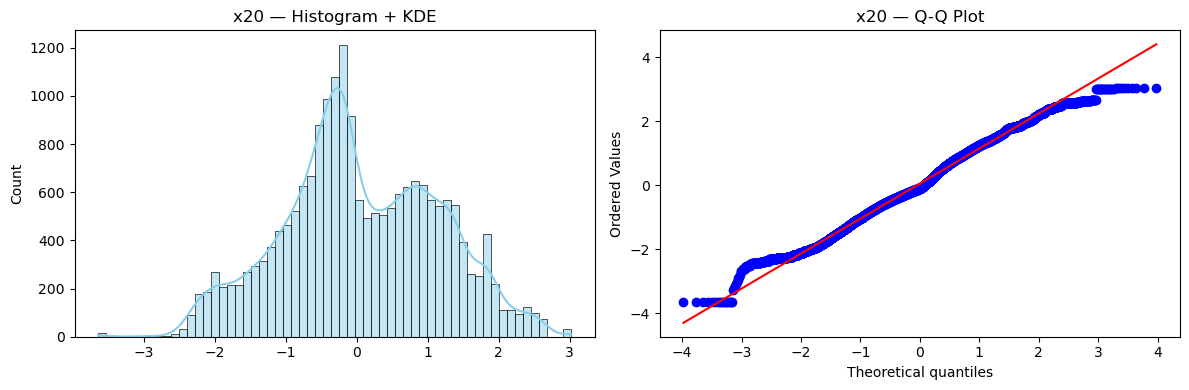

Selecting best transform:  37%|██████▎          | 20/54 [00:22<00:35,  1.05s/it]

❌ x21: best = boxcox, A² = 45.784, crit @5% = 0.787


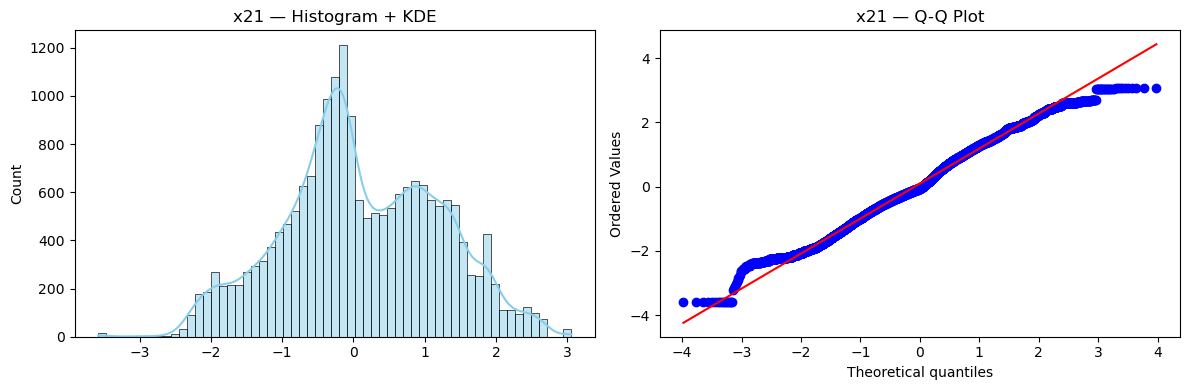

Selecting best transform:  39%|██████▌          | 21/54 [00:23<00:36,  1.12s/it]

❌ x22: best = boxcox, A² = 45.784, crit @5% = 0.787


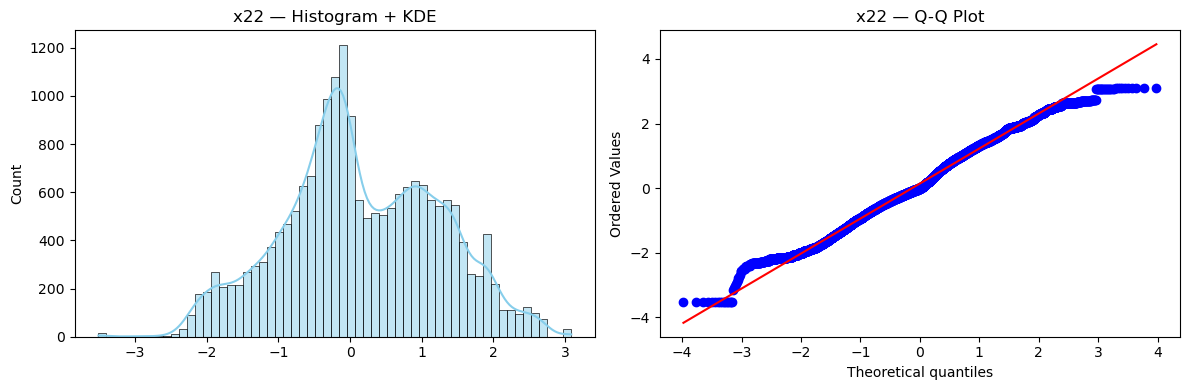

Selecting best transform:  41%|██████▉          | 22/54 [00:24<00:34,  1.08s/it]

❌ x23: best = boxcox, A² = 45.784, crit @5% = 0.787


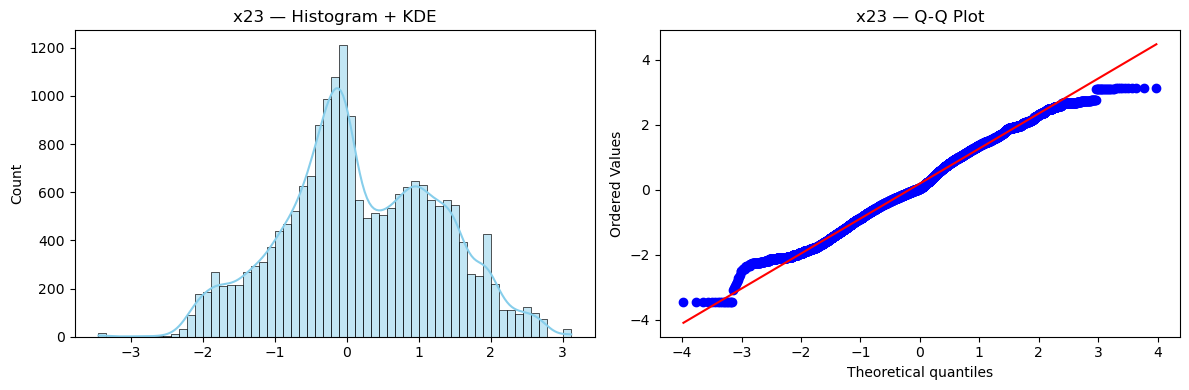

Selecting best transform:  43%|███████▏         | 23/54 [00:25<00:32,  1.06s/it]

❌ x24: best = boxcox, A² = 45.785, crit @5% = 0.787


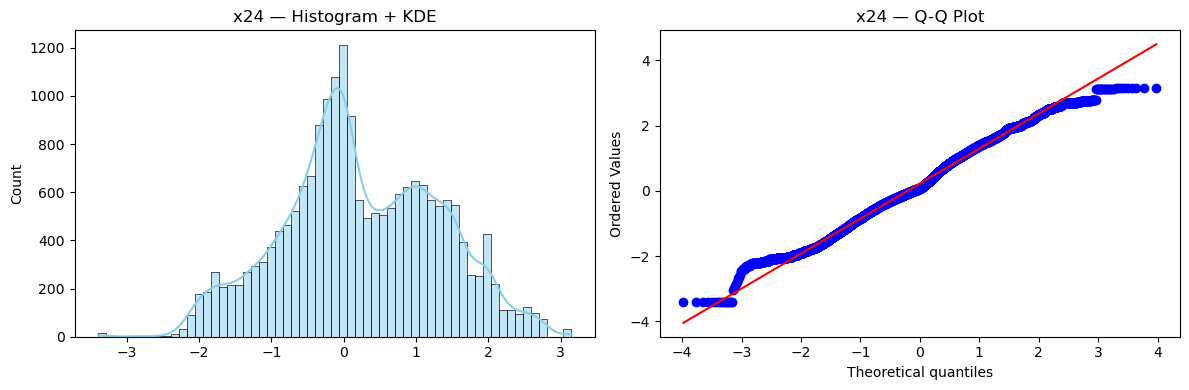

Selecting best transform:  44%|███████▌         | 24/54 [00:26<00:31,  1.05s/it]

❌ x25: best = boxcox, A² = 45.784, crit @5% = 0.787


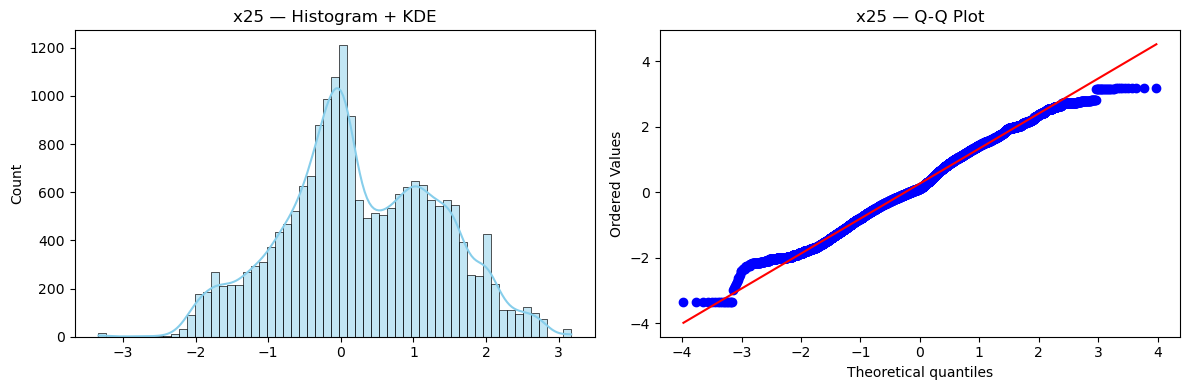

Selecting best transform:  46%|███████▊         | 25/54 [00:27<00:29,  1.02s/it]

❌ x26: best = quantile(pareto), A² = 527.018, crit @5% = 0.787


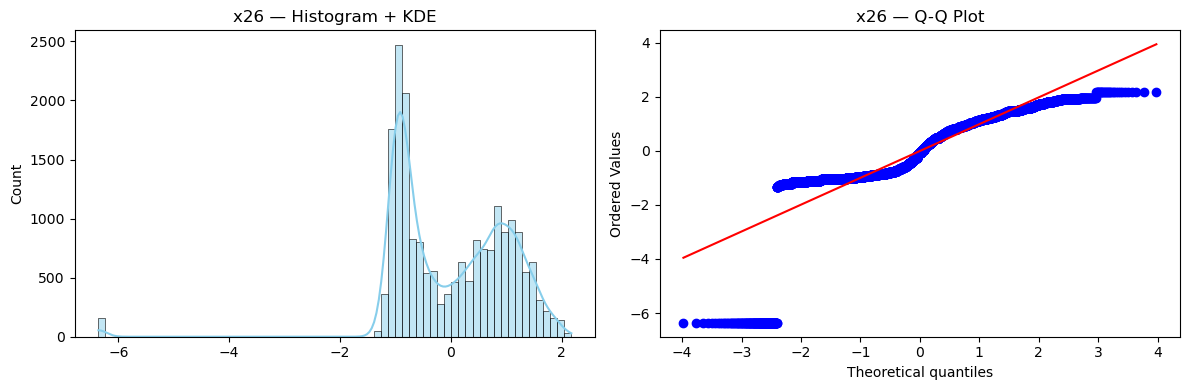

Selecting best transform:  48%|████████▏        | 26/54 [00:28<00:29,  1.06s/it]

❌ y1: best = quantile(norm), A² = 1780.528, crit @5% = 0.787


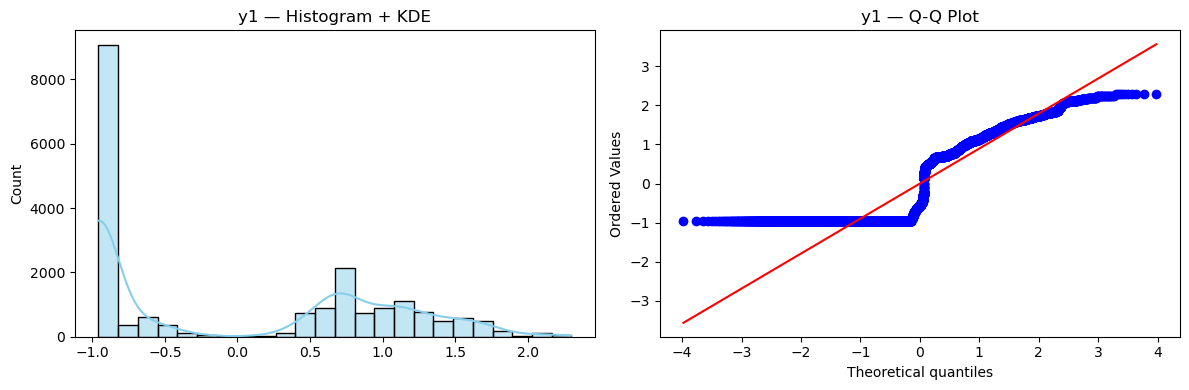

Selecting best transform:  50%|████████▌        | 27/54 [00:29<00:29,  1.10s/it]

❌ y2: best = yeojohnson, A² = 827.174, crit @5% = 0.787


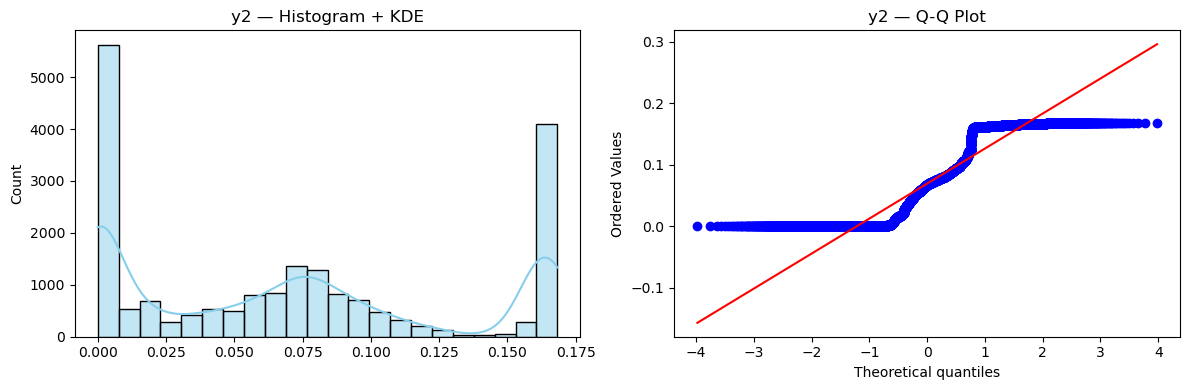

Selecting best transform:  52%|████████▊        | 28/54 [00:30<00:29,  1.14s/it]

❌ y3: best = quantile(expon), A² = 431.008, crit @5% = 0.787


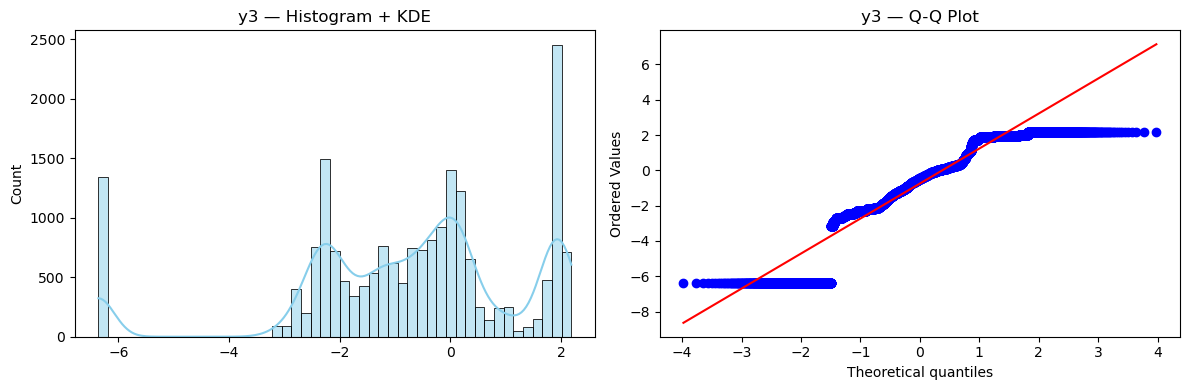

Selecting best transform:  54%|█████████▏       | 29/54 [00:32<00:30,  1.21s/it]

❌ y4: best = quantile(lognorm), A² = 410.205, crit @5% = 0.787


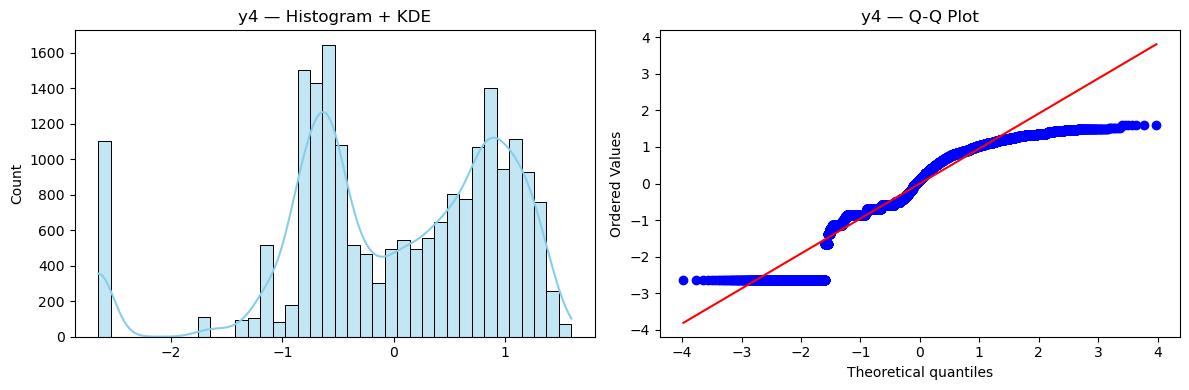

Selecting best transform:  56%|█████████▍       | 30/54 [00:33<00:28,  1.20s/it]

❌ y5: best = quantile(expon), A² = 706.010, crit @5% = 0.787


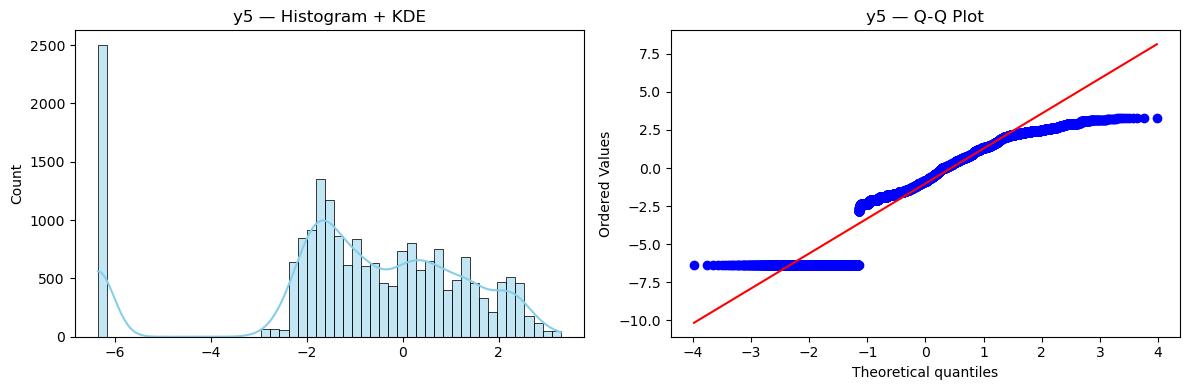

Selecting best transform:  57%|█████████▊       | 31/54 [00:34<00:28,  1.23s/it]

❌ y6: best = quantile(expon), A² = 525.468, crit @5% = 0.787


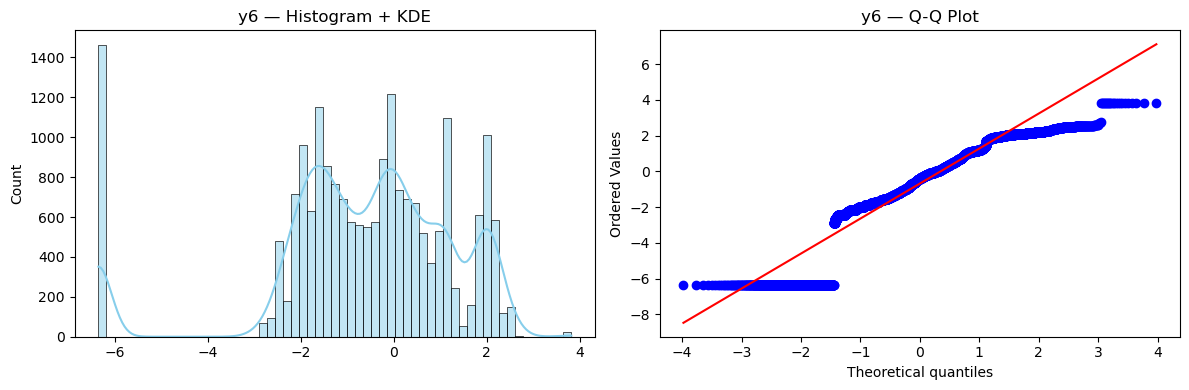

Selecting best transform:  59%|██████████       | 32/54 [00:35<00:27,  1.23s/it]

❌ y7: best = yeojohnson, A² = 714.095, crit @5% = 0.787


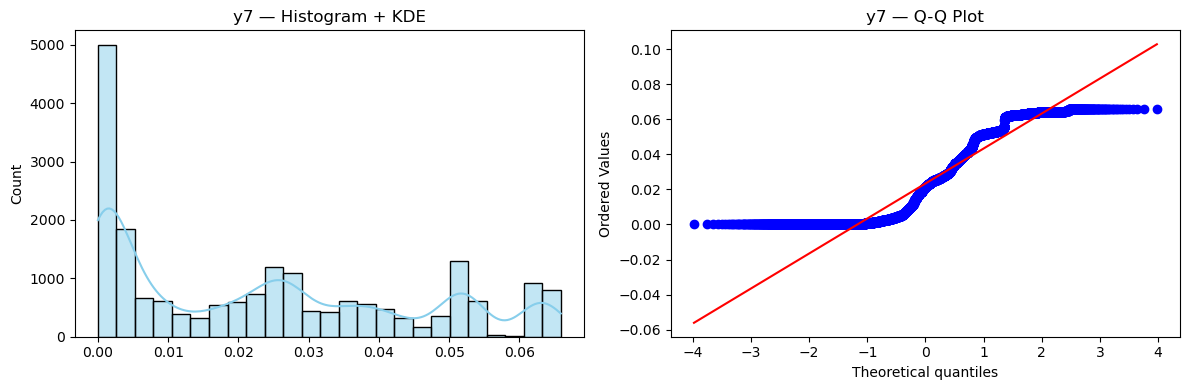

Selecting best transform:  61%|██████████▍      | 33/54 [00:37<00:25,  1.22s/it]

❌ y8: best = yeojohnson, A² = 617.591, crit @5% = 0.787


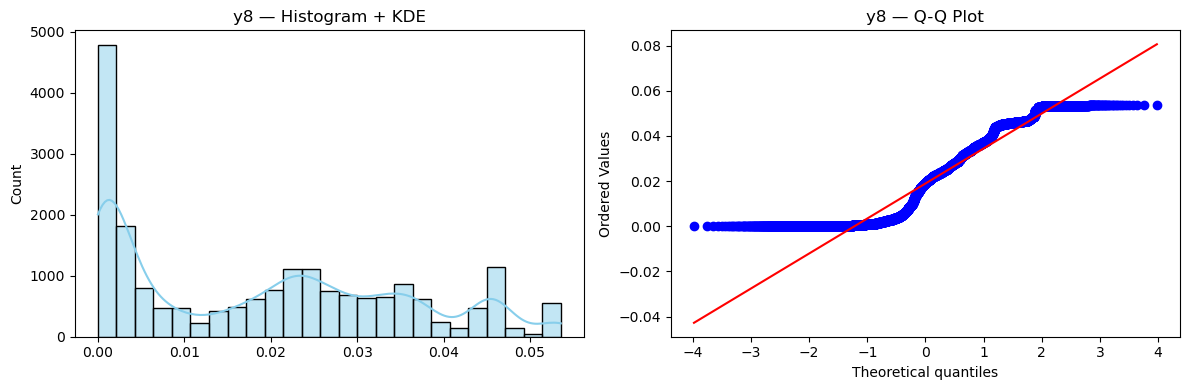

Selecting best transform:  63%|██████████▋      | 34/54 [00:38<00:24,  1.24s/it]

❌ y9: best = quantile(weibull_max), A² = 791.036, crit @5% = 0.787


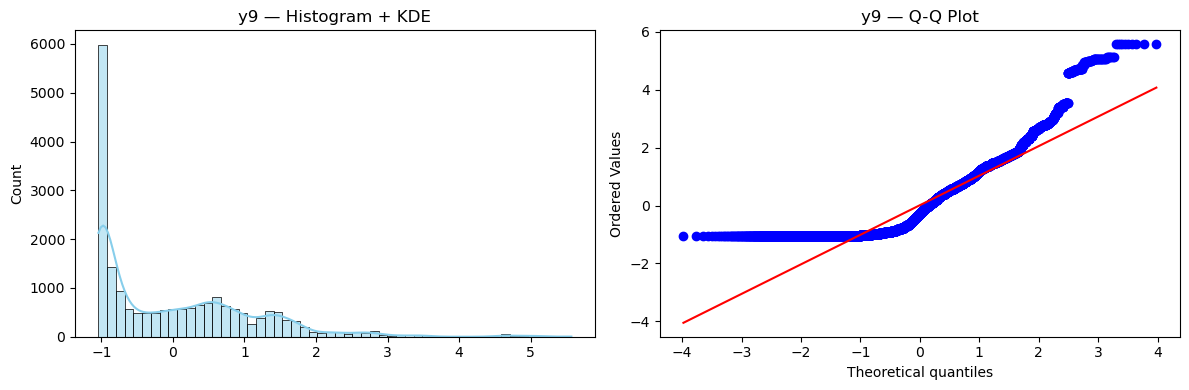

Selecting best transform:  65%|███████████      | 35/54 [00:39<00:23,  1.21s/it]

❌ y10: best = quantile(weibull_max), A² = 726.259, crit @5% = 0.787


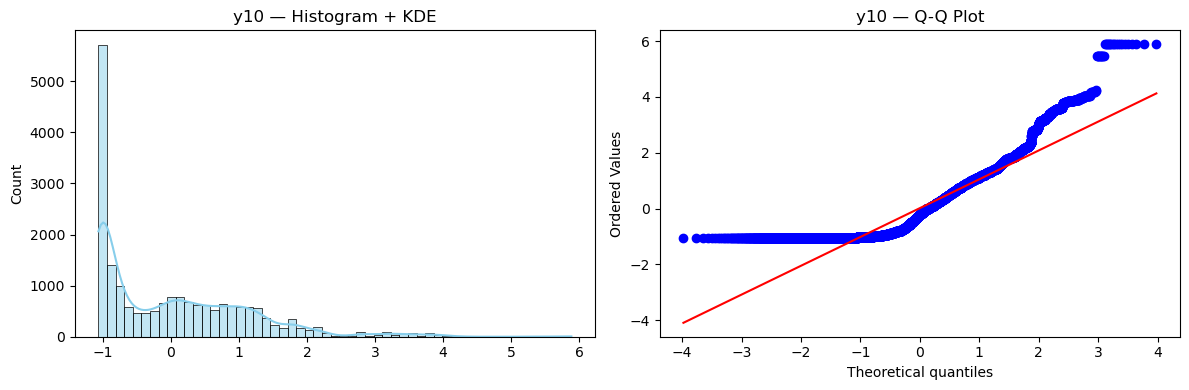

Selecting best transform:  67%|███████████▎     | 36/54 [00:40<00:21,  1.21s/it]

❌ y11: best = yeojohnson, A² = 772.737, crit @5% = 0.787


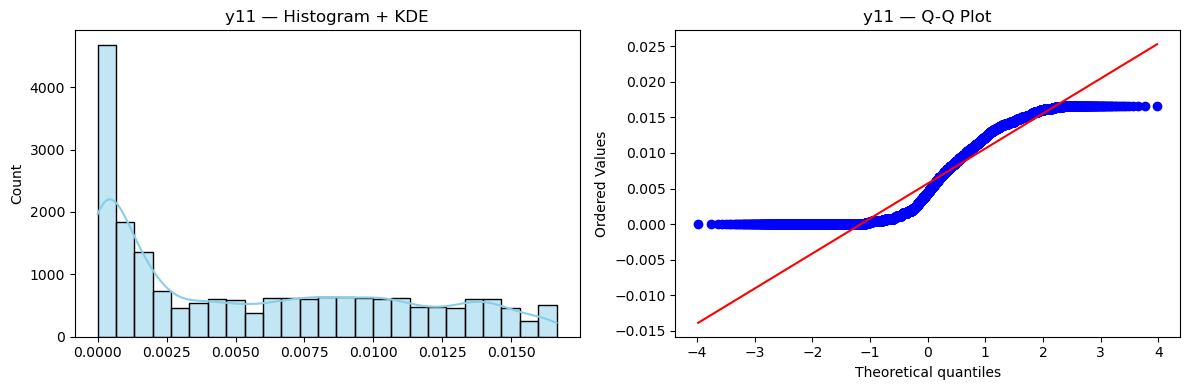

Selecting best transform:  69%|███████████▋     | 37/54 [00:41<00:20,  1.20s/it]

❌ y12: best = yeojohnson, A² = 952.953, crit @5% = 0.787


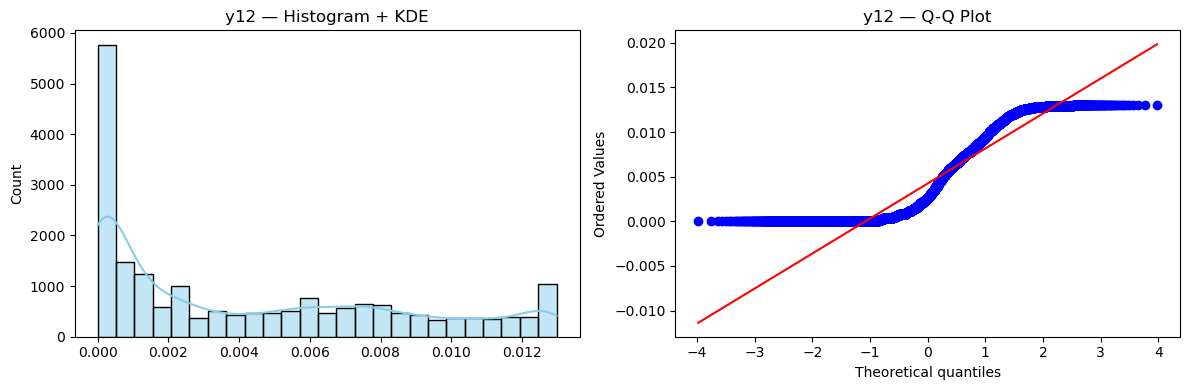

Selecting best transform:  70%|███████████▉     | 38/54 [00:43<00:19,  1.20s/it]

❌ y13: best = quantile(beta), A² = 1048.797, crit @5% = 0.787


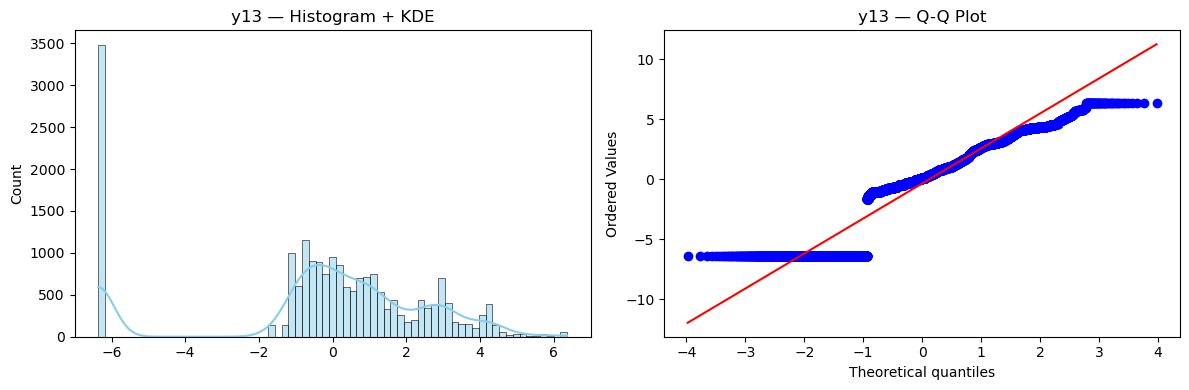

Selecting best transform:  72%|████████████▎    | 39/54 [00:44<00:18,  1.26s/it]

❌ y14: best = quantile(expon), A² = 1144.938, crit @5% = 0.787


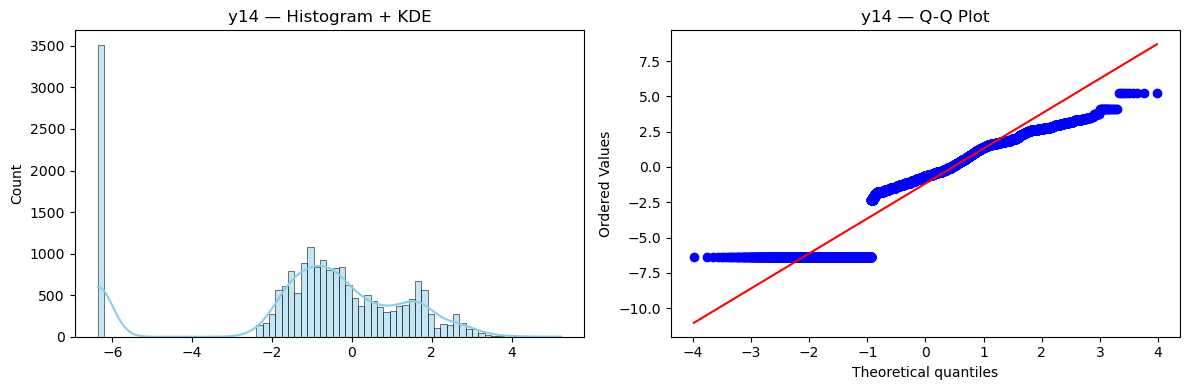

Selecting best transform:  74%|████████████▌    | 40/54 [00:45<00:17,  1.25s/it]

❌ y15: best = quantile(expon), A² = 1045.486, crit @5% = 0.787


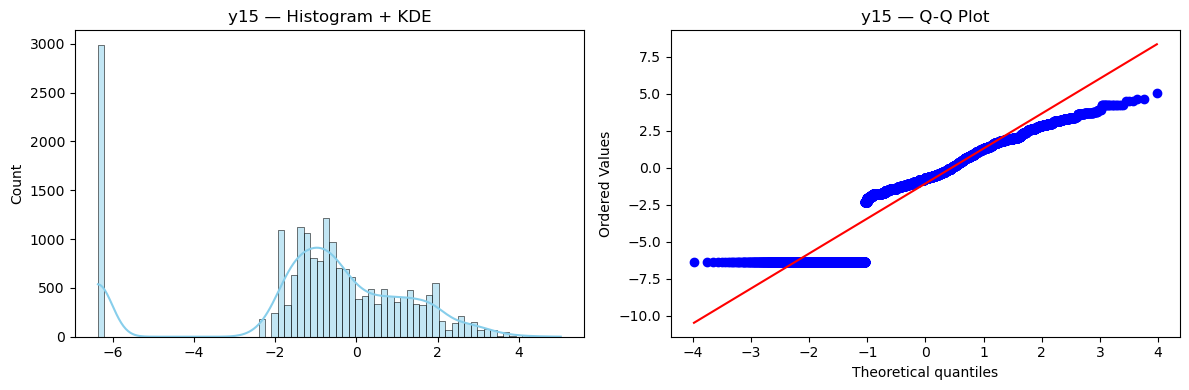

Selecting best transform:  76%|████████████▉    | 41/54 [00:47<00:16,  1.25s/it]

❌ y16: best = quantile(pareto), A² = 804.313, crit @5% = 0.787


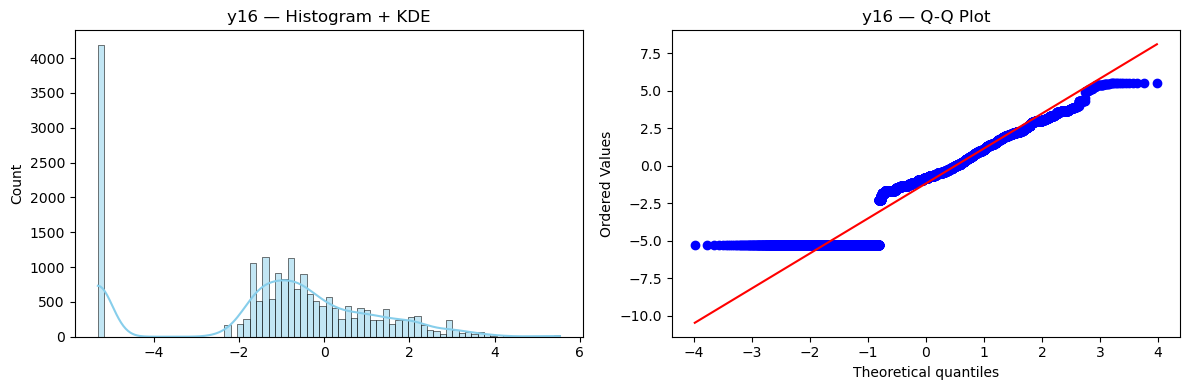

Selecting best transform:  78%|█████████████▏   | 42/54 [00:48<00:14,  1.23s/it]

❌ y17: best = quantile(expon), A² = 1115.552, crit @5% = 0.787


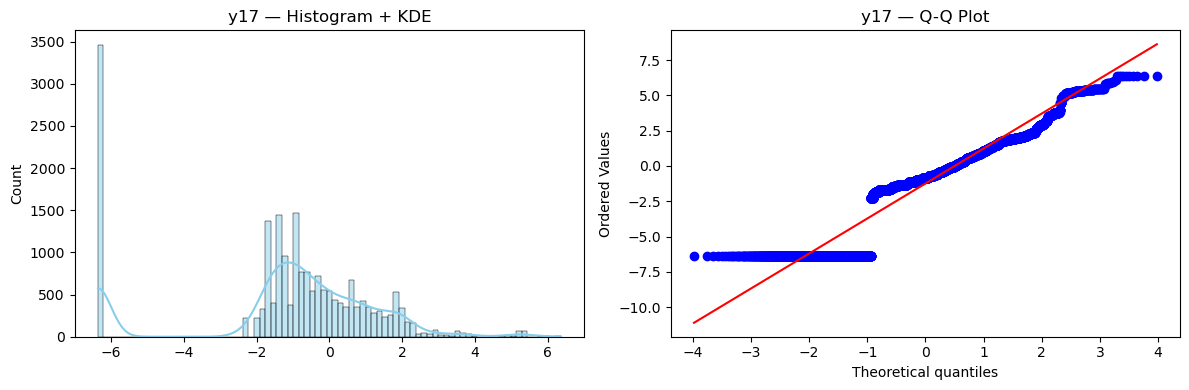

Selecting best transform:  80%|█████████████▌   | 43/54 [00:49<00:13,  1.23s/it]

❌ y18: best = quantile(pareto), A² = 789.607, crit @5% = 0.787


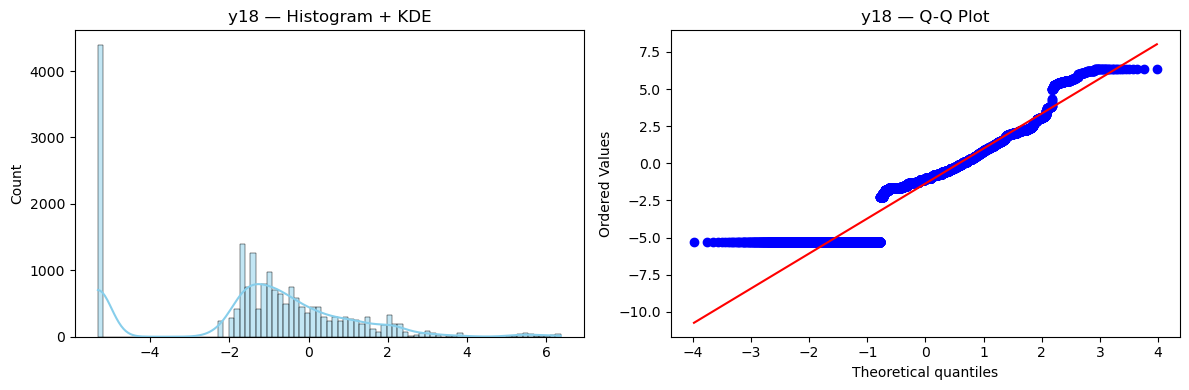

Selecting best transform:  81%|█████████████▊   | 44/54 [00:50<00:12,  1.23s/it]

❌ y19: best = quantile(pareto), A² = 874.869, crit @5% = 0.787


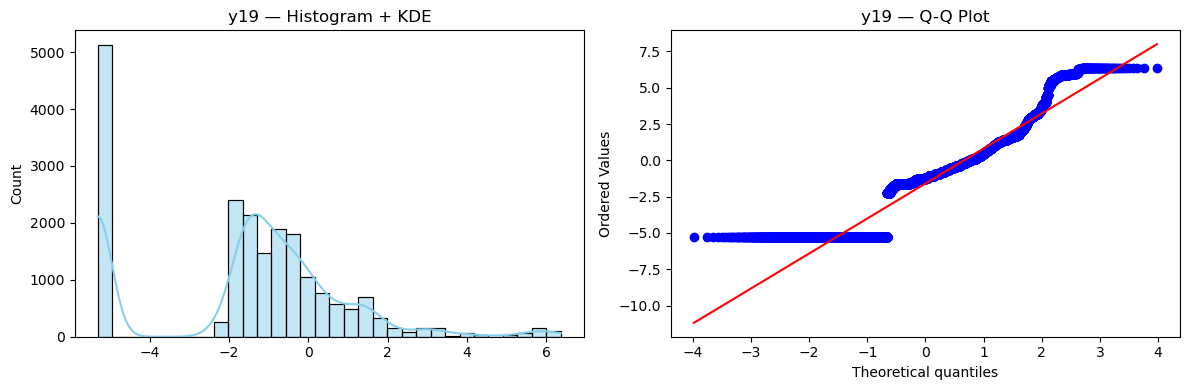

Selecting best transform:  83%|██████████████▏  | 45/54 [00:51<00:10,  1.21s/it]

❌ y20: best = quantile(pareto), A² = 860.725, crit @5% = 0.787


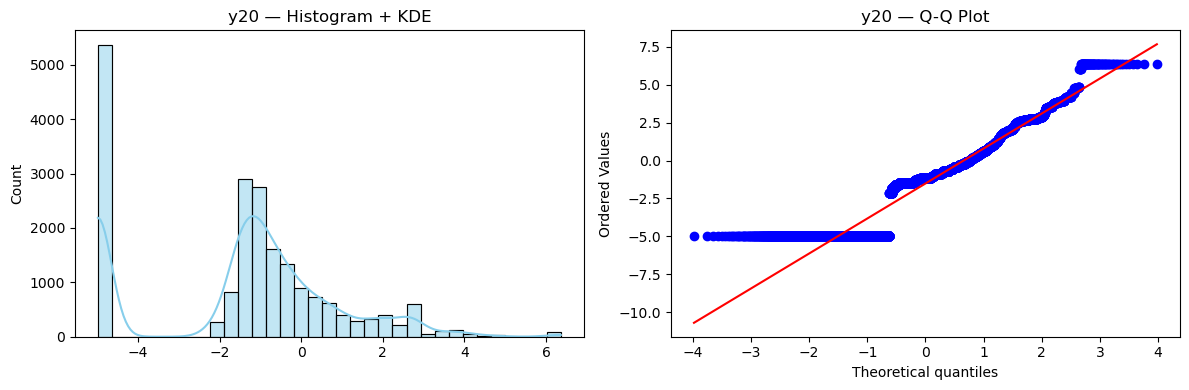

Selecting best transform:  85%|██████████████▍  | 46/54 [00:53<00:09,  1.21s/it]

❌ y21: best = quantile(pareto), A² = 1085.604, crit @5% = 0.787


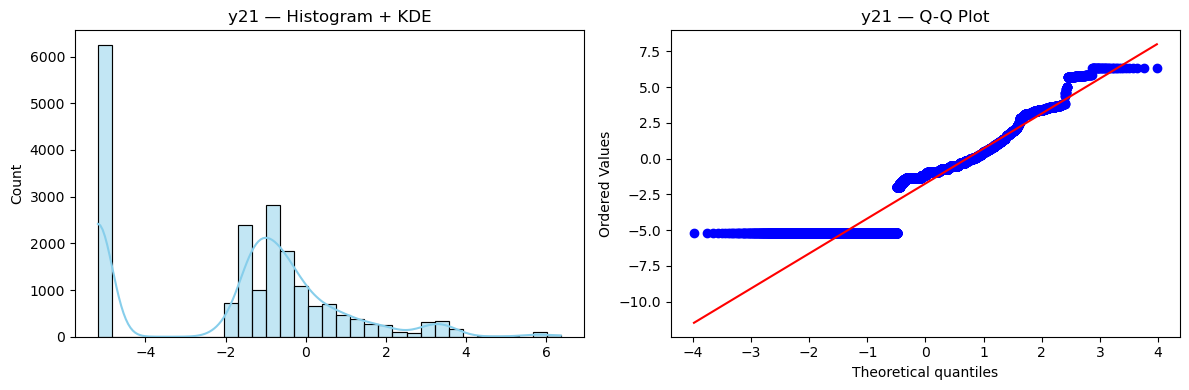

Selecting best transform:  87%|██████████████▊  | 47/54 [00:54<00:08,  1.19s/it]

❌ y22: best = quantile(pareto), A² = 1215.949, crit @5% = 0.787


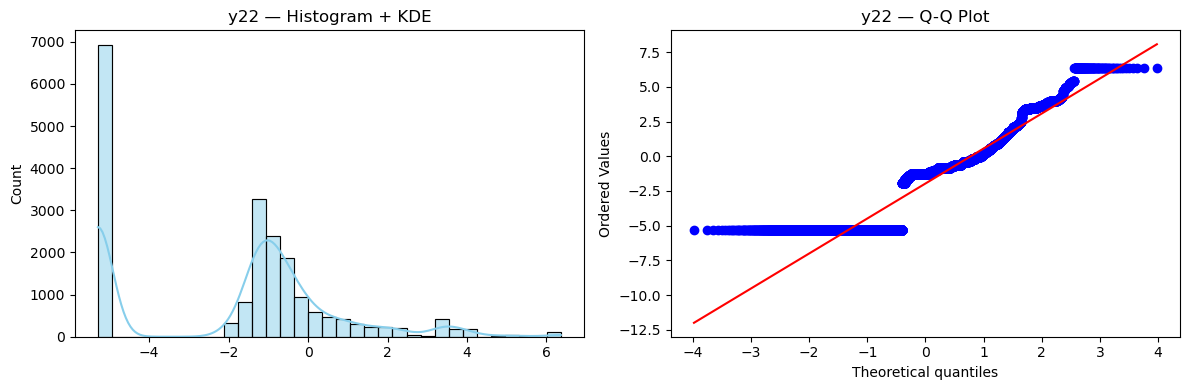

Selecting best transform:  89%|███████████████  | 48/54 [00:55<00:07,  1.17s/it]

❌ y23: best = quantile(pareto), A² = 1475.143, crit @5% = 0.787


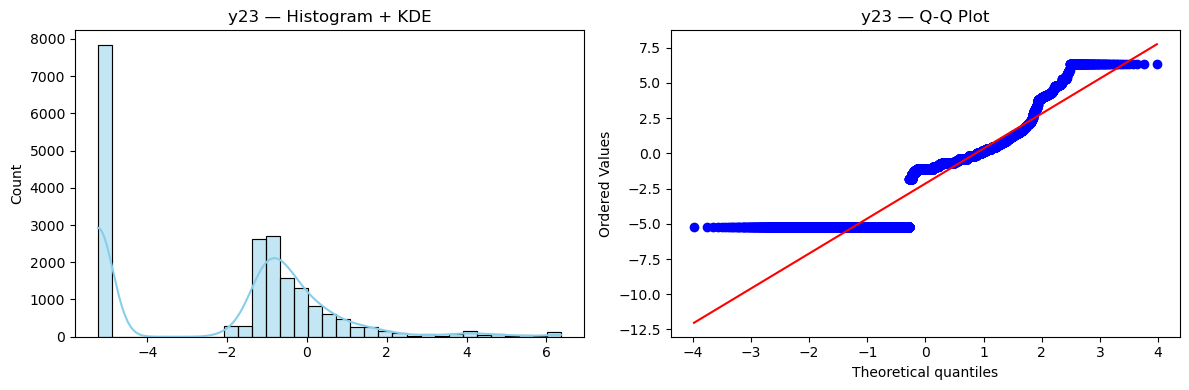

Selecting best transform:  91%|███████████████▍ | 49/54 [00:56<00:05,  1.16s/it]

❌ y24: best = quantile(pareto), A² = 1366.956, crit @5% = 0.787


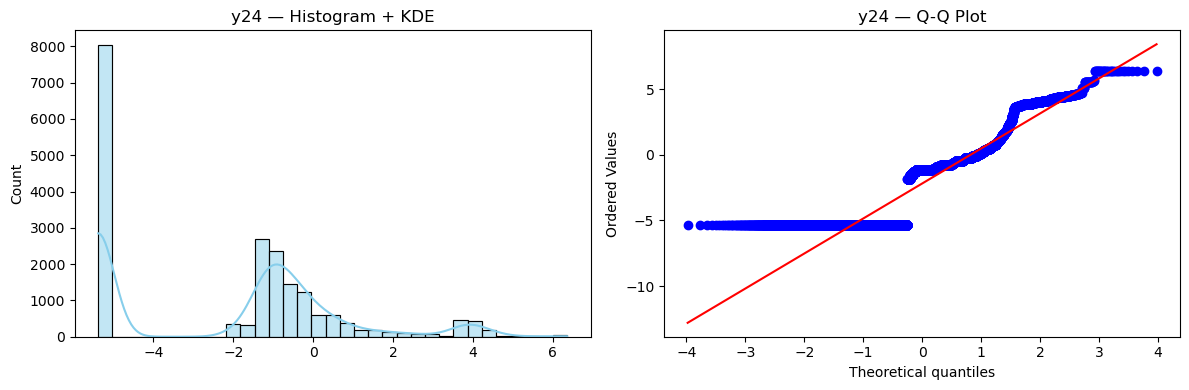

Selecting best transform:  93%|███████████████▋ | 50/54 [00:57<00:04,  1.15s/it]

❌ y25: best = quantile(pareto), A² = 1280.566, crit @5% = 0.787


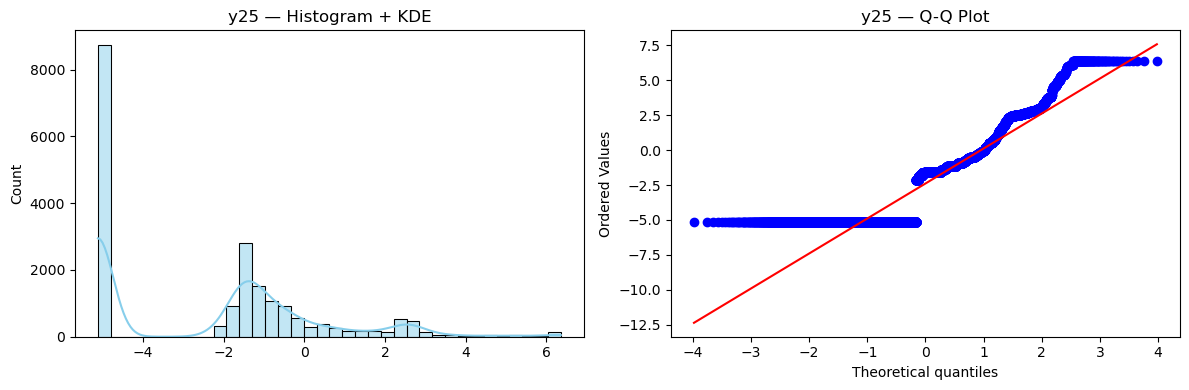

Selecting best transform:  94%|████████████████ | 51/54 [00:58<00:03,  1.14s/it]

❌ y26: best = quantile(pareto), A² = 651.606, crit @5% = 0.787


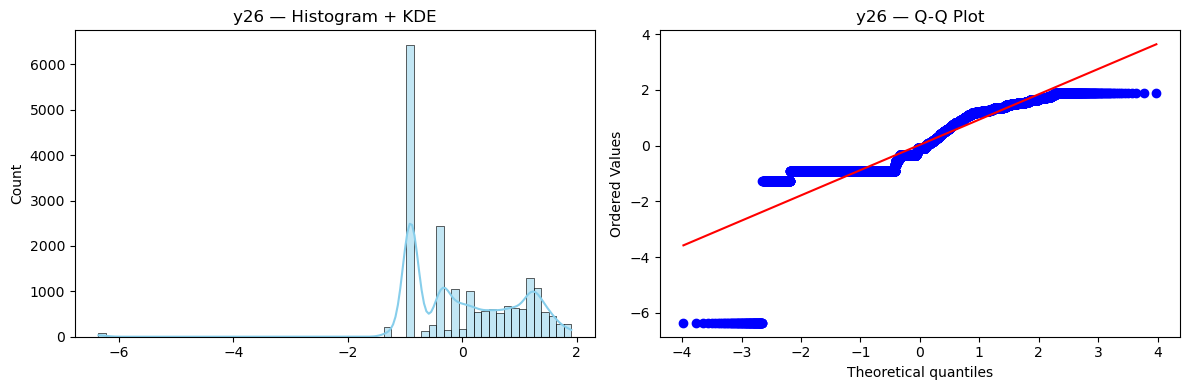

Selecting best transform:  96%|████████████████▎| 52/54 [00:59<00:02,  1.10s/it]

❌ s: best = quantile(lognorm), A² = 637.640, crit @5% = 0.787


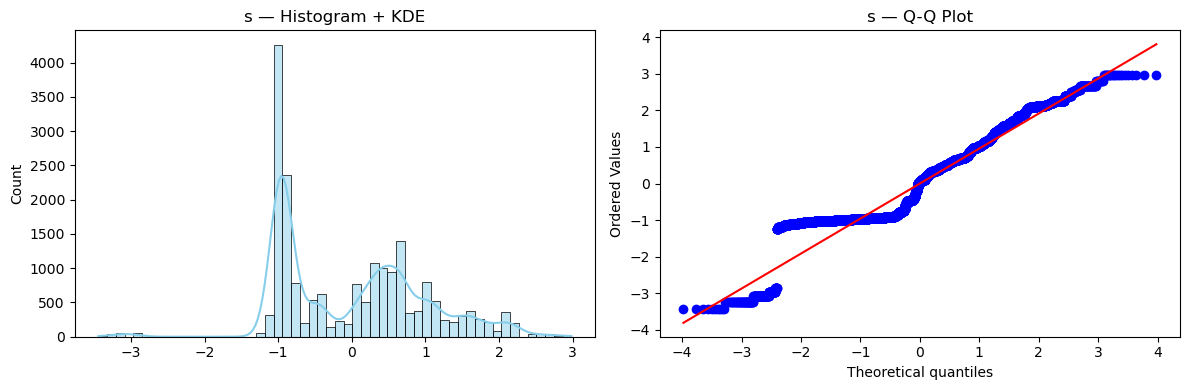

Selecting best transform:  98%|████████████████▋| 53/54 [01:00<00:01,  1.06s/it]

❌ r: best = quantile(beta), A² = 817.633, crit @5% = 0.787


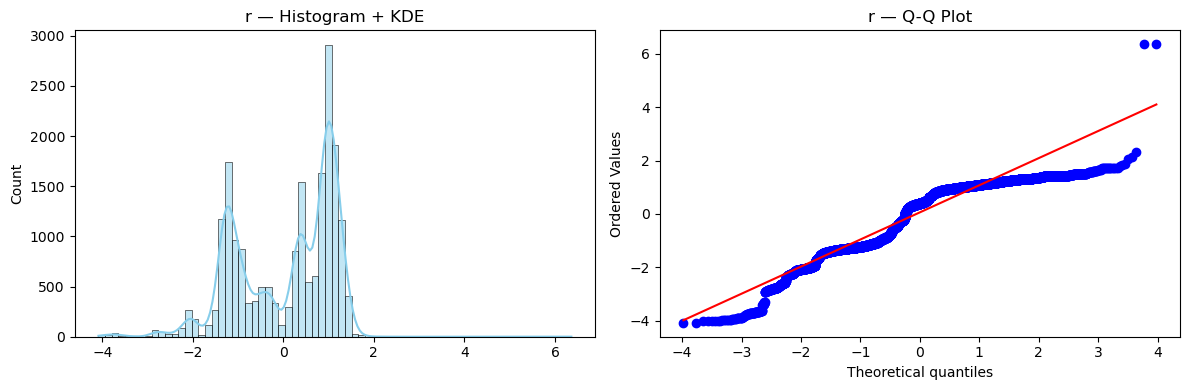

Selecting best transform: 100%|█████████████████| 54/54 [01:01<00:00,  1.15s/it]


In [9]:
# ==== Step 0: Candidate distributions used for quantile normalization ====
distribution_list = [
    "norm", "lognorm", "expon", "gamma", "beta", "chi2",
    "weibull_min", "weibull_max", "pareto", "rayleigh"
]

# ==== Step 1: Try quantile normalization based on best-fitting distribution ====
def get_quantile_transform(x, distributions=distribution_list):
    best_stat = np.inf
    best_fit_name = None
    best_transformed = None

    for dist_name in distributions:
        dist = getattr(stats, dist_name)
        try:
            params = dist.fit(x)  # Fit distribution parameters
            cdf_vals = dist.cdf(x, *params)
            cdf_vals = np.clip(cdf_vals, 1e-10, 1 - 1e-10)
            transformed = norm.ppf(cdf_vals)  # Apply probit transform
            stat = anderson(transformed, dist='norm').statistic

            if stat < best_stat:
                best_stat = stat
                best_fit_name = dist_name
                best_transformed = transformed
        except:
            continue

    return f"quantile({best_fit_name})", best_transformed, best_stat

# ==== Step 2: Try all possible transformations on a single feature ====
def try_all_transformations(x):
    transformations = {}

    # Case 1: x > 0 → eligible for log and Box-Cox
    if (x > 0).all():
        try:
            x_box = PowerTransformer(method='box-cox', standardize=False).fit_transform(x.reshape(-1, 1)).flatten()
            stat_box = anderson(x_box, dist='norm').statistic
            transformations["boxcox"] = (x_box, stat_box)
        except:
            pass

        try:
            x_log = np.log(x)
            stat_log = anderson(x_log, dist='norm').statistic
            transformations["log"] = (x_log, stat_log)
        except:
            pass

    # Case 2: x ≥ 0 → eligible for log1p
    if (x >= 0).all():
        try:
            x_log1p = np.log1p(x)
            stat_log1p = anderson(x_log1p, dist='norm').statistic
            transformations["log1p"] = (x_log1p, stat_log1p)
        except:
            pass

    # Case 3: Yeo-Johnson is safe for all real values
    try:
        x_yeo = PowerTransformer(method='yeo-johnson', standardize=False).fit_transform(x.reshape(-1, 1)).flatten()
        stat_yeo = anderson(x_yeo, dist='norm').statistic
        transformations["yeojohnson"] = (x_yeo, stat_yeo)
    except:
        pass

    # Case 4: Quantile normalization using best theoretical distribution
    try:
        name_q, x_q, stat_q = get_quantile_transform(x)
        transformations[name_q] = (x_q, stat_q)
    except:
        pass

    if not transformations:
        return "none", x, float("inf")

    # Return the transformation with the lowest A² statistic
    best_method = min(transformations, key=lambda k: transformations[k][1])
    best_x, best_stat = transformations[best_method]
    return best_method, best_x, best_stat

# ==== Step 3: Apply to all features ====
features = df.drop(columns="l")
labels = df["l"]
df_best_normalized = pd.DataFrame(index=df.index)
best_transform_map = {}  # Stores best transformation per feature

for feature in tqdm(features.columns, desc="Selecting best transform"):
    x = features[feature].dropna().values
    method, transformed, stat = try_all_transformations(x)

    best_transform_map[feature] = method
    df_best_normalized[feature] = transformed

    # Print verdict
    crit_val_5 = anderson(transformed, dist='norm').critical_values[2]
    status = "✅" if stat < crit_val_5 else "❌"
    print(f"{status} {feature}: best = {method}, A² = {stat:.3f}, crit @5% = {crit_val_5:.3f}")

    # Plot histogram + Q-Q plot for visual inspection
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(transformed, kde=True, ax=axs[0], color='skyblue')
    axs[0].set_title(f"{feature} — Histogram + KDE")

    stats.probplot(transformed, dist="norm", plot=axs[1])
    axs[1].set_title(f"{feature} — Q-Q Plot")
    plt.tight_layout()
    plt.show()

# ==== Step 4: Reattach the label to final normalized df ====
df_best_normalized["l"] = labels.values


## ✅ Final Feature Selection: Keep Raw or Transformed Based on Normality

In this step, we compare each feature’s raw and transformed versions using their **Anderson-Darling (A²) statistic**.

For each feature:
- If the transformation **reduces the A² value** (i.e., brings the distribution closer to normal), we keep the transformed version.
- Otherwise, we keep the original (raw) version.

This allows us to build a balanced dataset `df_final_transformed` that selectively keeps only useful transformations.


In [10]:
# Initialize final DataFrame to hold best features
df_final_transformed = pd.DataFrame(index=df.index)

# Will log the decision and stats for each feature
comparison_log = {}

# Loop through each feature
for feature in features:
    raw_a2 = raw_a2_stats[feature]                     # A² from raw data
    best_method = best_transform_map[feature]          # Best method selected
    transformed_vals = df_best_normalized[feature].values
    transformed_a2 = anderson(transformed_vals, dist='norm').statistic  # A² from transformed

    # Compare raw vs. transformed normality
    if transformed_a2 < raw_a2:
        df_final_transformed[feature] = transformed_vals
        kept = "transformed"
        status = "✅"
    else:
        df_final_transformed[feature] = df[feature].values
        kept = "raw"
        status = "❌"

    # Save comparison info
    comparison_log[feature] = {
        "raw_A2": raw_a2,
        "trans_A2": transformed_a2,
        "method": best_method,
        "kept": kept
    }

    # Print result for the feature
    print(f"{status} {feature}: raw A² = {raw_a2:.2f} → trans A² = {transformed_a2:.2f} | method: {best_method} | kept: {kept}")

# Add the label column to the final DataFrame
df_final_transformed["l"] = df["l"]



✅ x1: raw A² = 2399.79 → trans A² = 45.80 | method: boxcox | kept: transformed
✅ x2: raw A² = 2399.80 → trans A² = 45.78 | method: boxcox | kept: transformed
✅ x3: raw A² = 2399.80 → trans A² = 45.78 | method: boxcox | kept: transformed
✅ x4: raw A² = 2399.81 → trans A² = 45.78 | method: boxcox | kept: transformed
✅ x5: raw A² = 2399.80 → trans A² = 45.78 | method: boxcox | kept: transformed
✅ x6: raw A² = 2399.80 → trans A² = 45.78 | method: boxcox | kept: transformed
✅ x7: raw A² = 2399.80 → trans A² = 45.78 | method: boxcox | kept: transformed
✅ x8: raw A² = 2399.80 → trans A² = 45.79 | method: boxcox | kept: transformed
✅ x9: raw A² = 2399.80 → trans A² = 45.79 | method: boxcox | kept: transformed
✅ x10: raw A² = 2399.80 → trans A² = 45.78 | method: boxcox | kept: transformed
✅ x11: raw A² = 2399.80 → trans A² = 45.78 | method: boxcox | kept: transformed
✅ x12: raw A² = 2399.80 → trans A² = 45.78 | method: boxcox | kept: transformed
✅ x13: raw A² = 2399.80 → trans A² = 45.78 | meth

## 🔬 Multivariate Normality Check (Mardia Test + Q-Q Plots)

While univariate normality is useful, many ML techniques benefit from or assume **multivariate normality** across features.

We use:
- **Mardia’s test (HZ)** to assess multivariate normality (via `pingouin`)
- **Mahalanobis Q-Q plots** to visually check multivariate normality
- A comparison rule to choose whether to keep the **raw** or **transformed** dataset, based on:
  1. Larger p-value (closer to MVN)
  2. If tied, smaller HZ statistic wins

We keep the df most MVN or nearest to it.

🔍 Mardia Test — Raw Data
HZResults(hz=5.587101237413894, pval=0.0, normal=False)

🔍 Mardia Test — Transformed Data
HZResults(hz=1.8937694061731312, pval=0.0, normal=False)


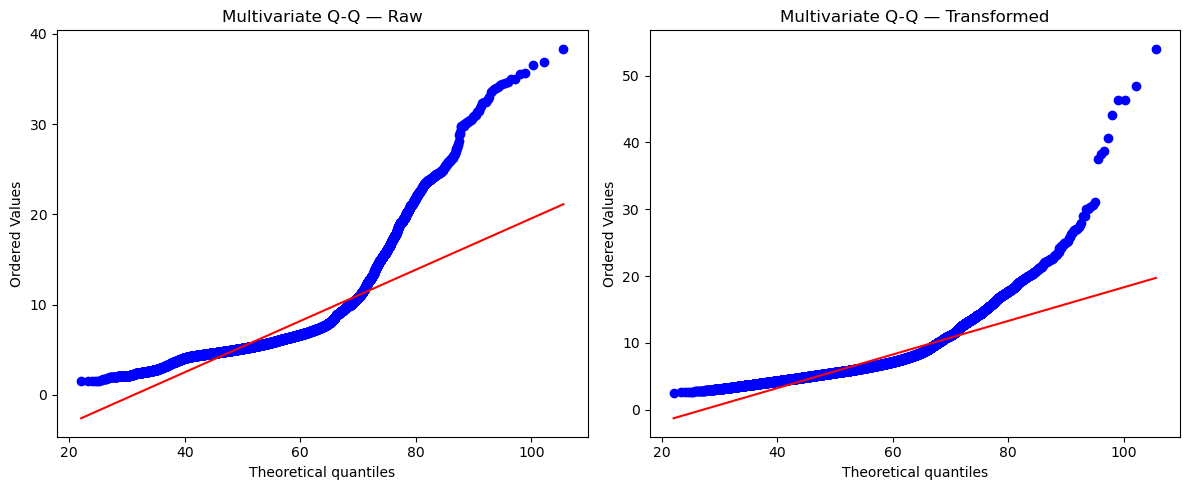


🧠 Final Verdict:
- Raw MVN: {'hz': 5.587101237413894, 'pval': 0.0, 'is_normal': False}
- Transformed MVN: {'hz': 1.8937694061731312, 'pval': 0.0, 'is_normal': False}
✅ Transformed data is closer to MVN. Keeping it.


In [11]:
# === Step 1: Remove label column to work with features only ===
X_raw = df.drop(columns="l")
X_trans = df_final_transformed.drop(columns="l")

# === Step 2: Run Mardia’s test from pingouin ===
print("🔍 Mardia Test — Raw Data")
mvn_raw = pg.multivariate_normality(X_raw, alpha=0.05)
print(mvn_raw)

print("\n🔍 Mardia Test — Transformed Data")
mvn_trans = pg.multivariate_normality(X_trans, alpha=0.05)
print(mvn_trans)

# === Step 3: Multivariate Q-Q Plots using Mahalanobis distance ===
def plot_qq_multivariate(X, title):
    mean_vec = X.mean(axis=0).values  # Mean vector
    cov_inv = inv(np.cov(X.values, rowvar=False))  # Inverse of covariance matrix
    dists = [mahalanobis(x, mean_vec, cov_inv) for x in X.values]  # Mahalanobis distance
    probplot(dists, dist="chi2", sparams=(X.shape[1],), plot=plt)  # Q-Q plot against chi2
    plt.title(title)

# Plot side-by-side for raw vs transformed
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_qq_multivariate(X_raw, "Multivariate Q-Q — Raw")

plt.subplot(1, 2, 2)
plot_qq_multivariate(X_trans, "Multivariate Q-Q — Transformed")
plt.tight_layout()
plt.show()

# === Step 4: Decide which dataset is closer to multivariate normal ===

# Helper function to unpack pingouin output
def interpret_hz(result):
    hz, pval, normal = result
    return {"hz": hz, "pval": pval, "is_normal": normal}

# Interpret both tests
stats_raw  = interpret_hz(mvn_raw)
stats_tran = interpret_hz(mvn_trans)

# Print summary
print("\n🧠 Final Verdict:")
print(f"- Raw MVN: {stats_raw}")
print(f"- Transformed MVN: {stats_tran}")

# Choose best dataset:
# Prefer the one with higher p-value. If tied, prefer lower HZ statistic.
if (stats_tran["pval"] > stats_raw["pval"]) or (
        np.isclose(stats_tran["pval"], stats_raw["pval"]) and
        stats_tran["hz"] < stats_raw["hz"]):
    df_final_prefilter = df_final_transformed.copy()
    print("✅ Transformed data is closer to MVN. Keeping it.")
else:
    df_final_prefilter = df.copy()
    print("✅ Raw data is closer to MVN. Keeping it.")



## 📦 Visual Outlier Detection: Boxplots (Raw vs Transformed)

Before applying outlier filtering, we visualize each feature’s distribution using **boxplots**:

- The left plot shows the feature in its **raw** form
- The right plot shows the **transformed** version (if transformations were selected)

This helps us:
- Understand the **skewness** and **spread**
- Observe **outlier behavior**
- Choose an appropriate **univariate outlier detection method**  
  (→ In this case, we choose **IQR filtering**, as data is non-normal)


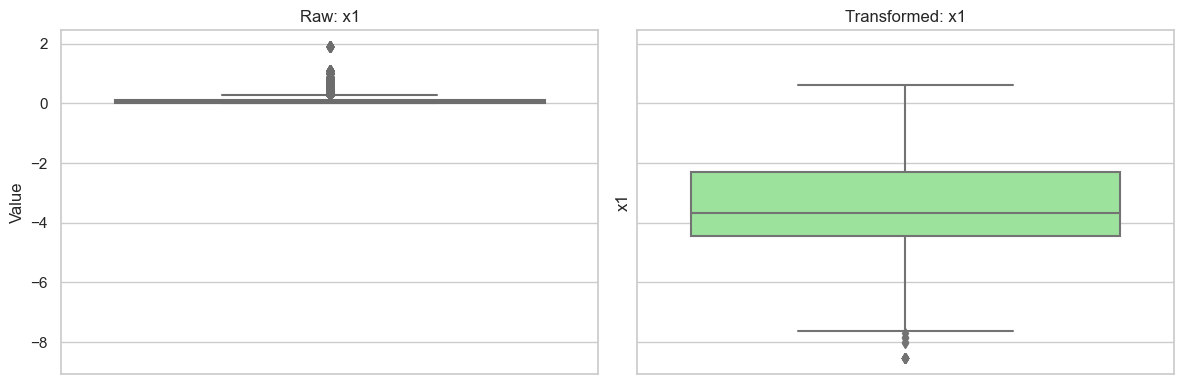

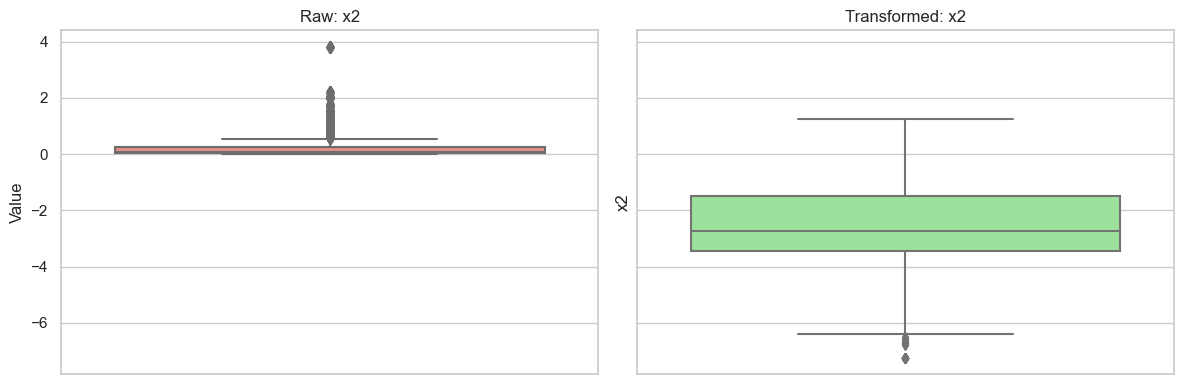

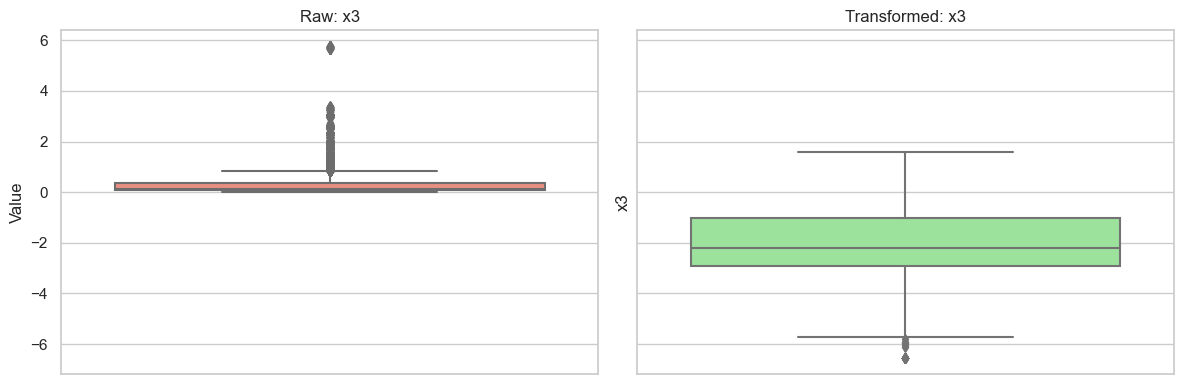

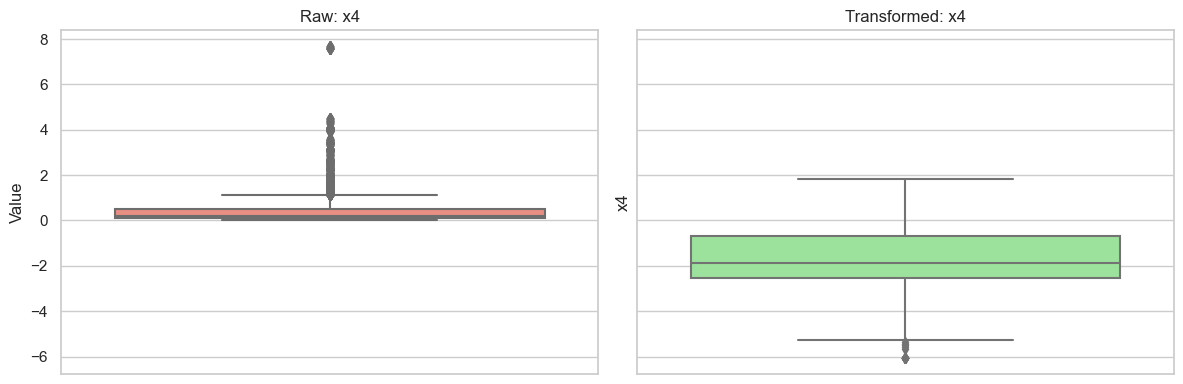

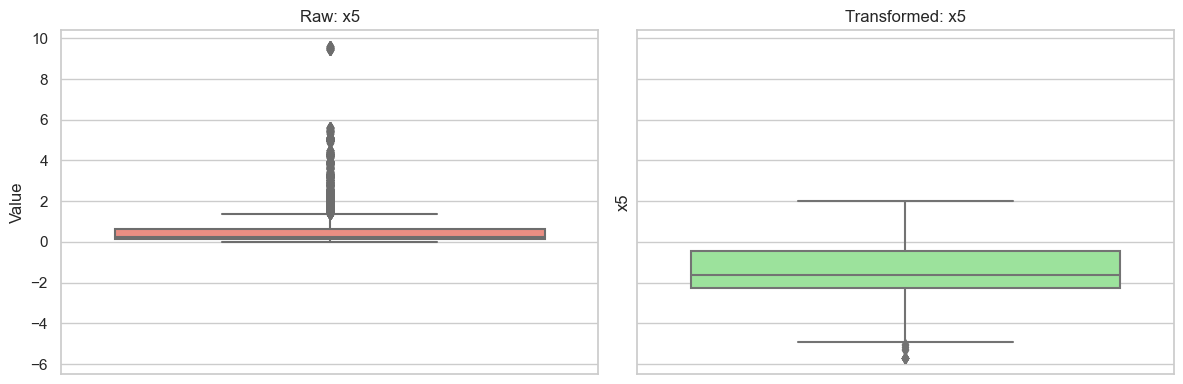

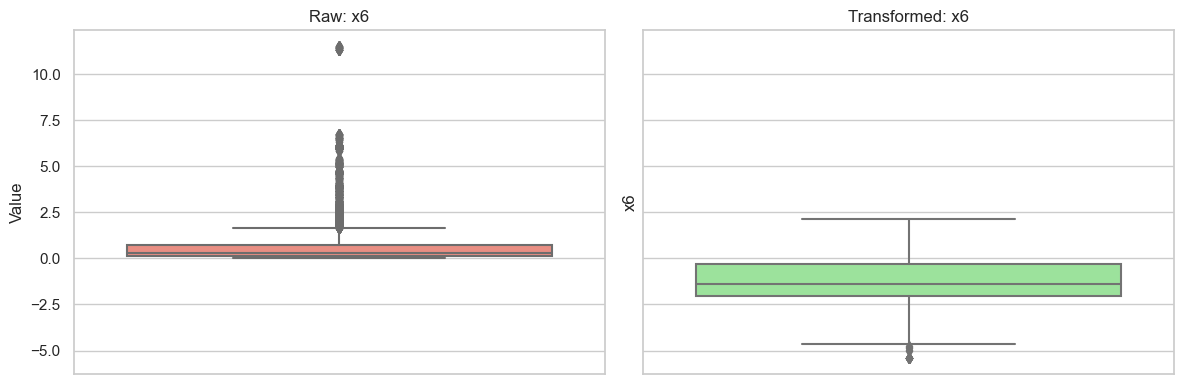

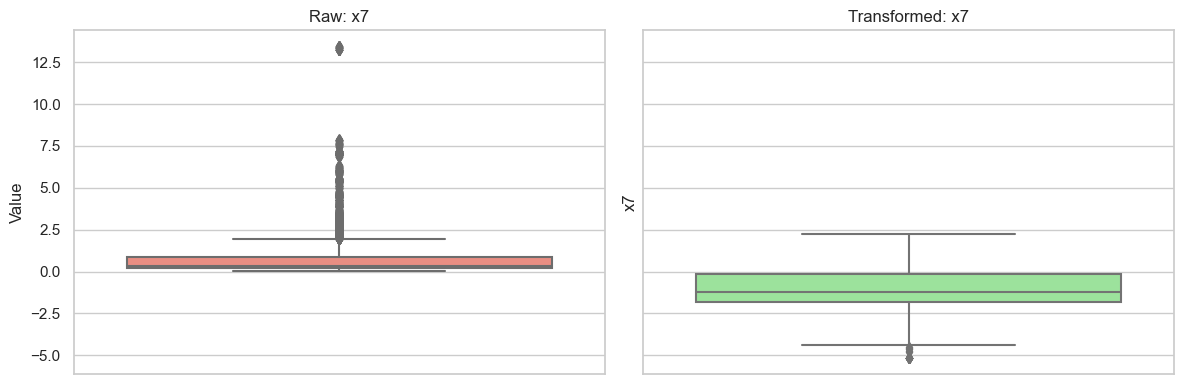

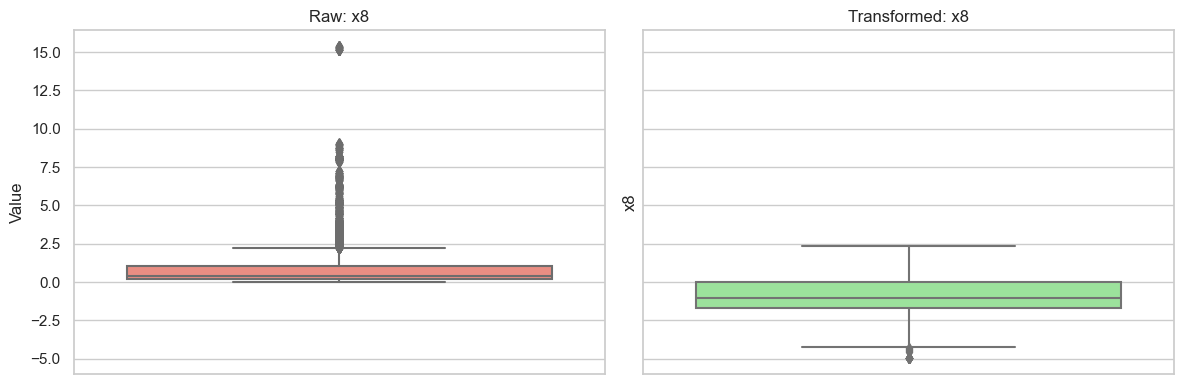

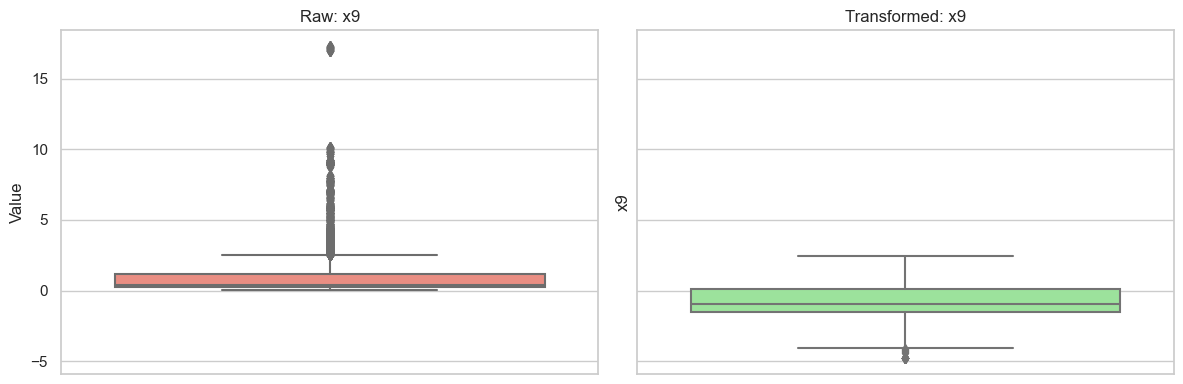

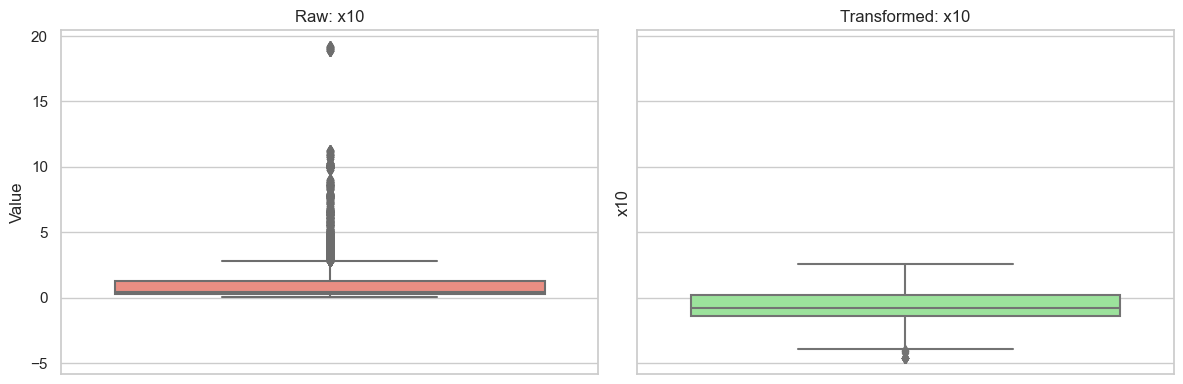

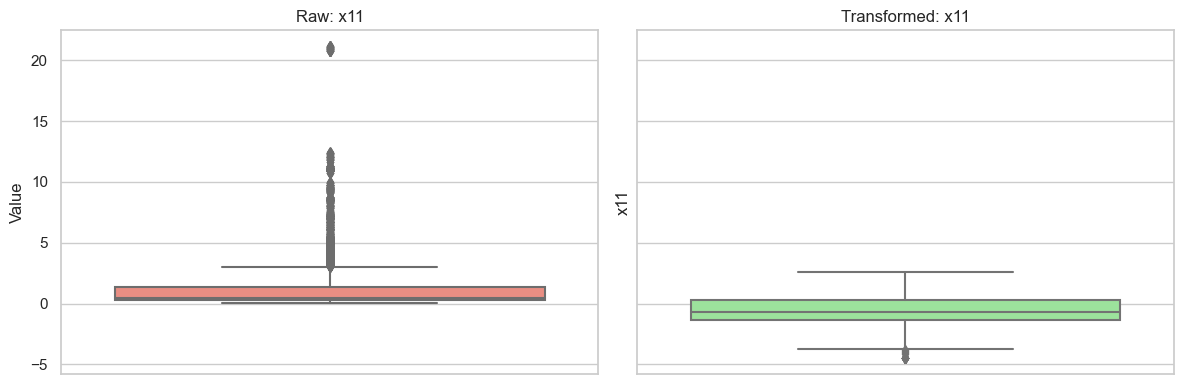

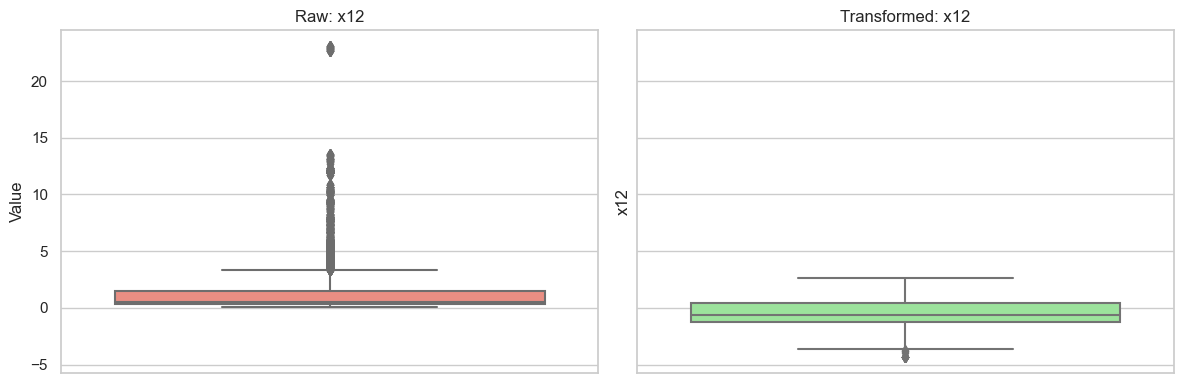

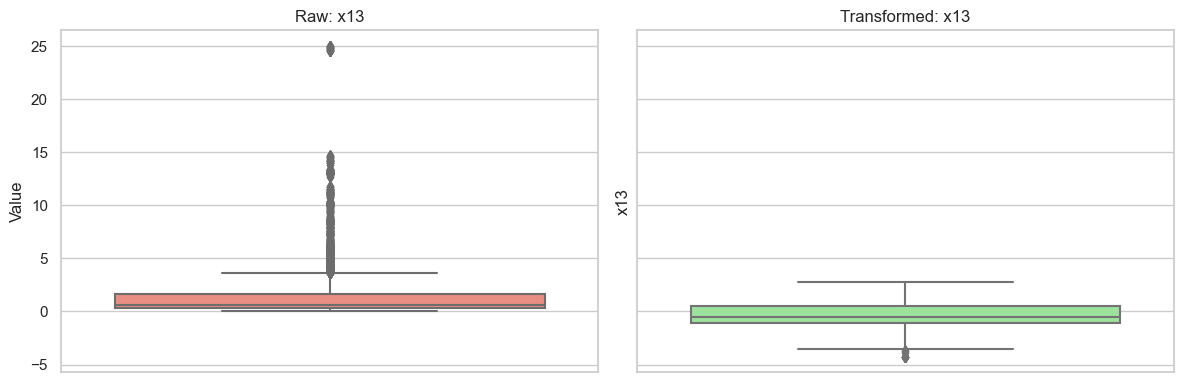

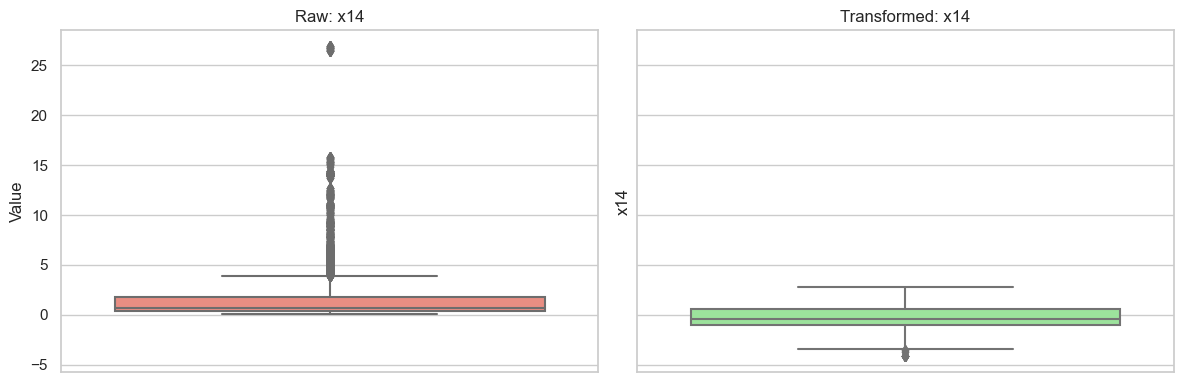

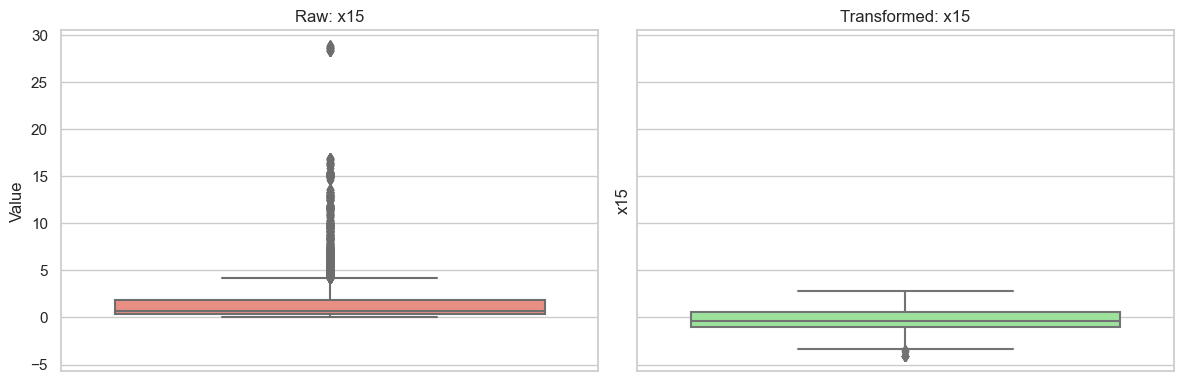

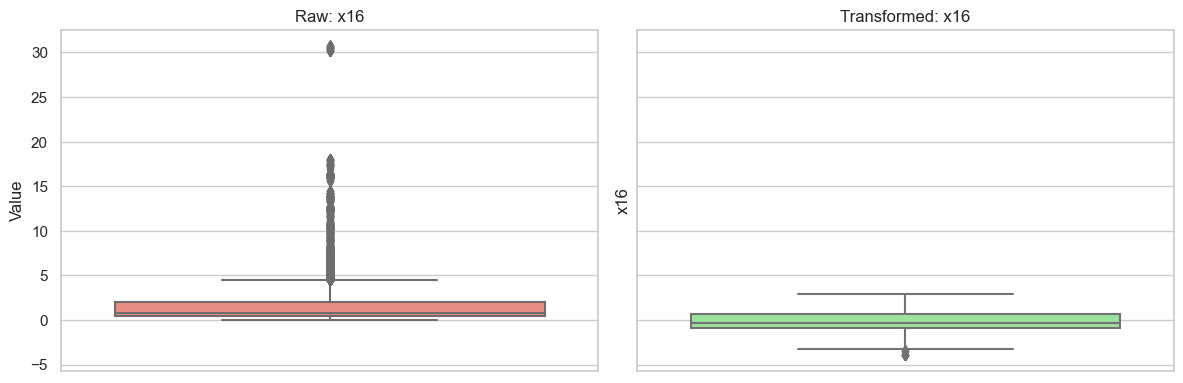

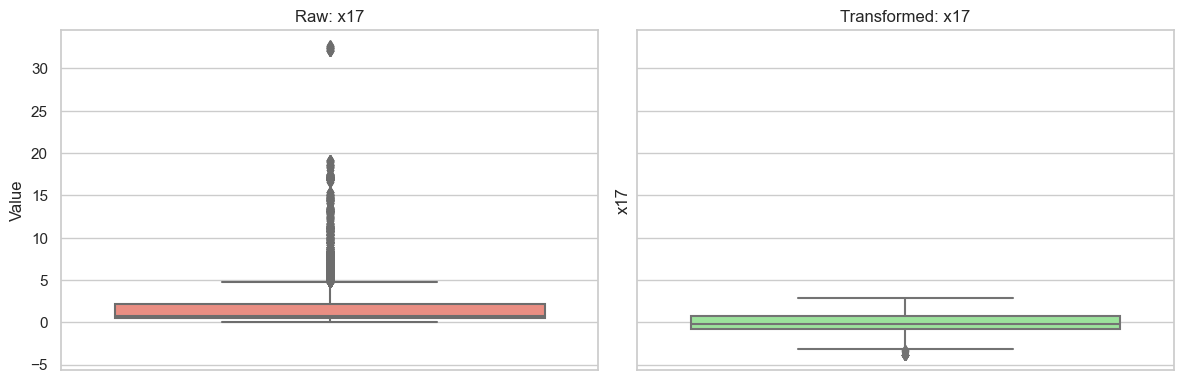

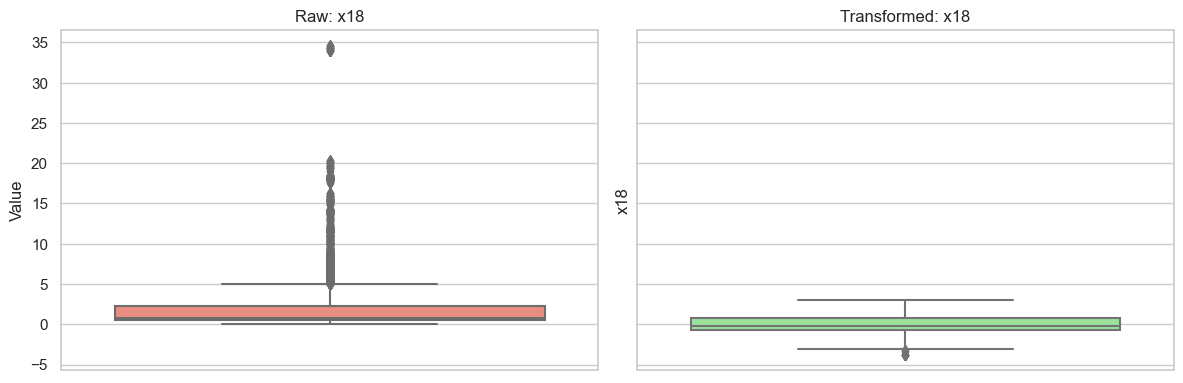

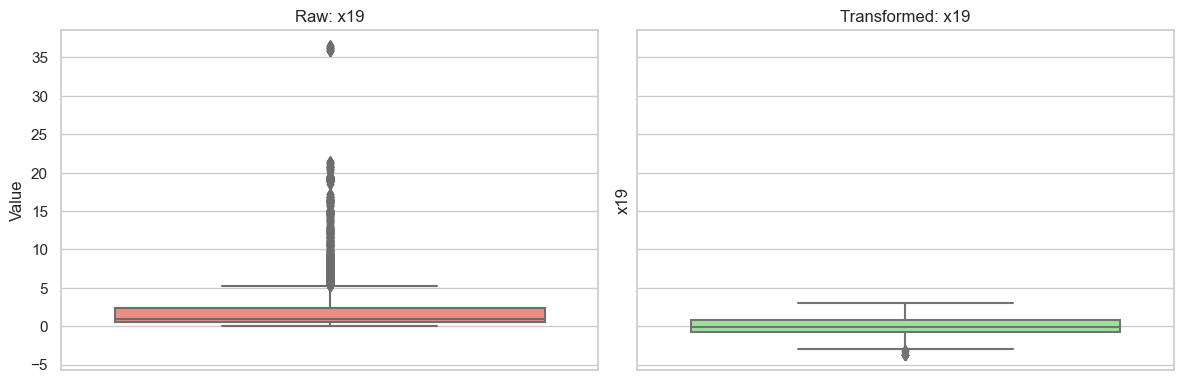

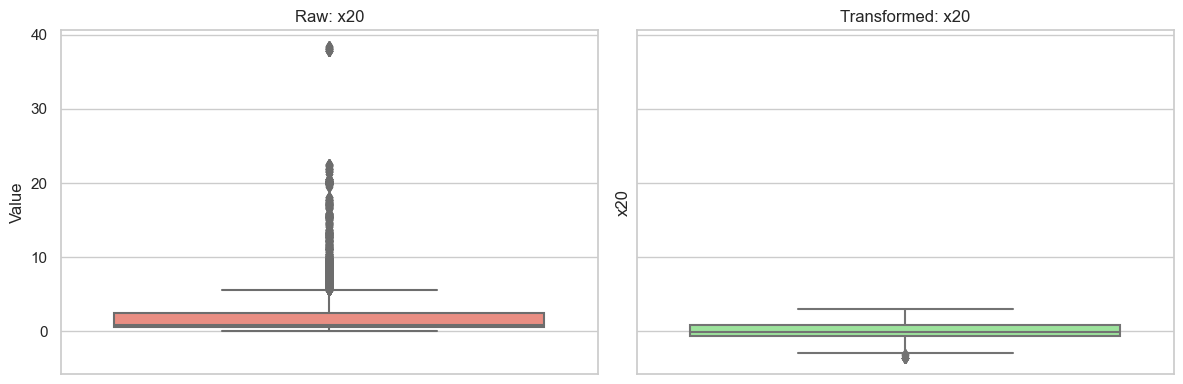

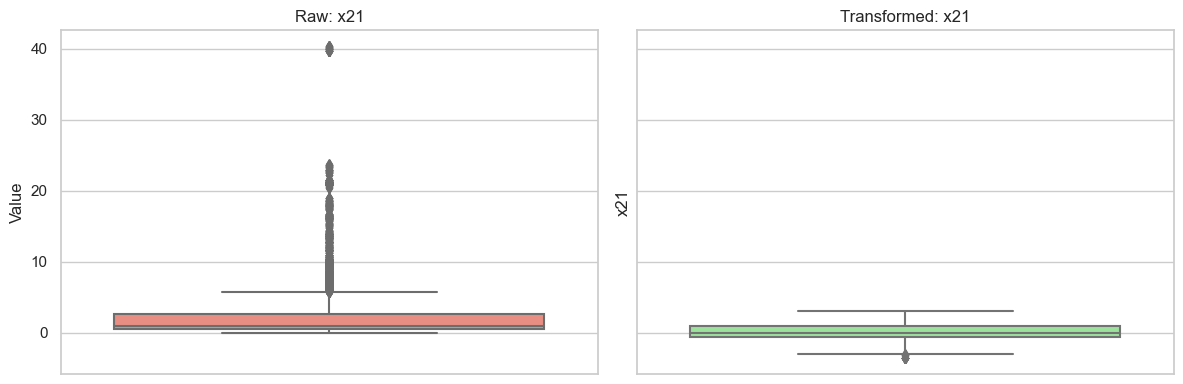

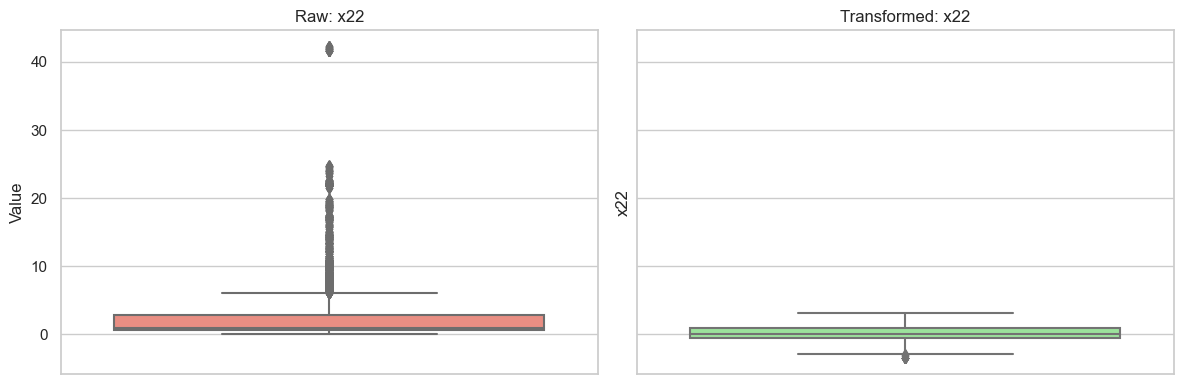

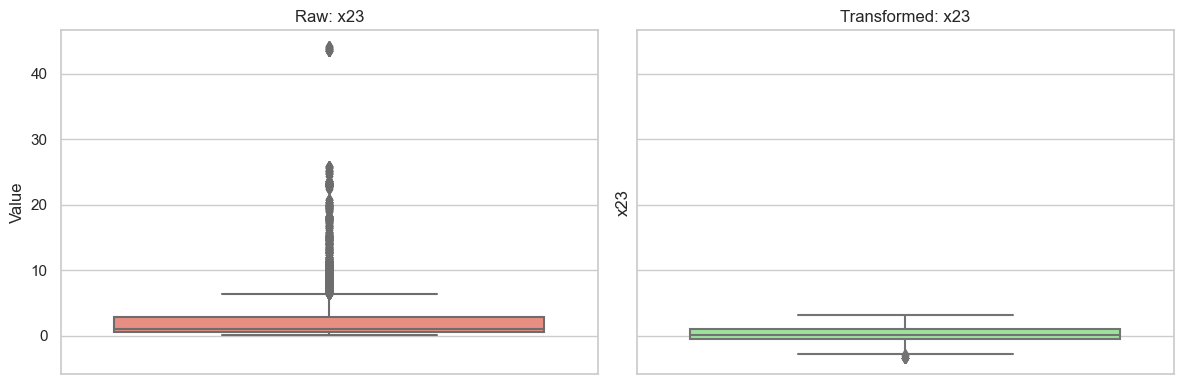

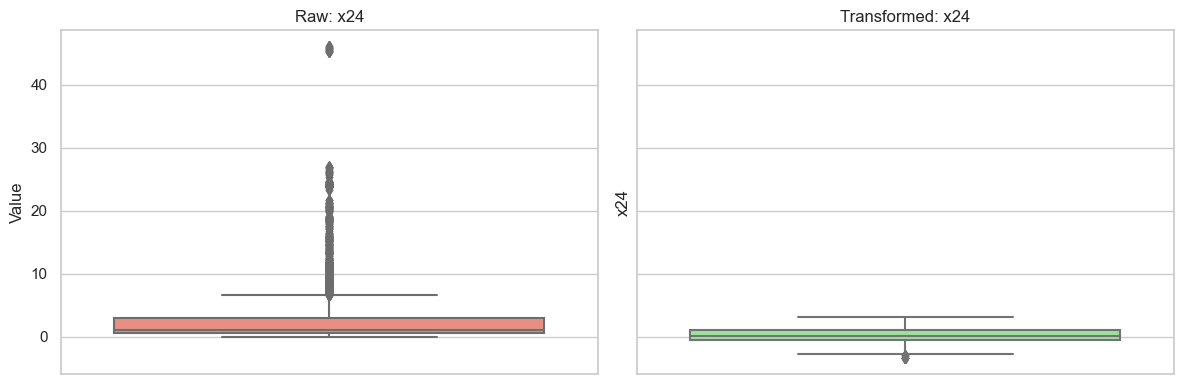

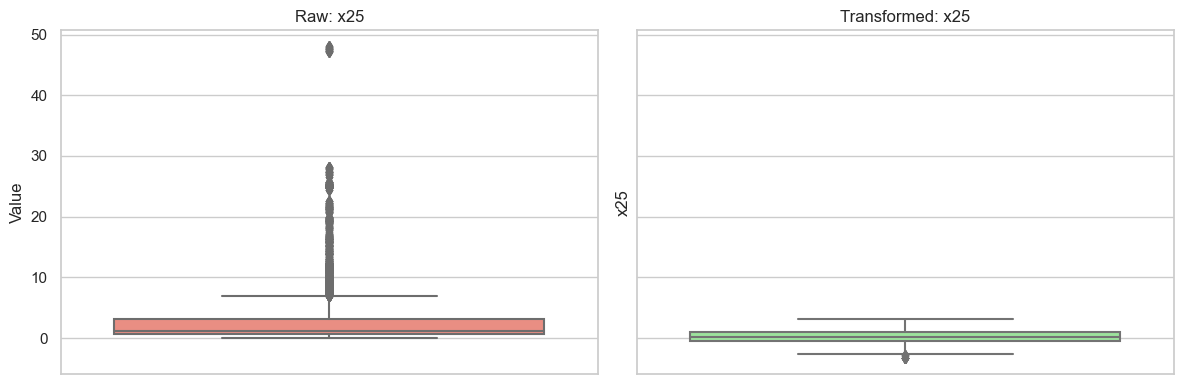

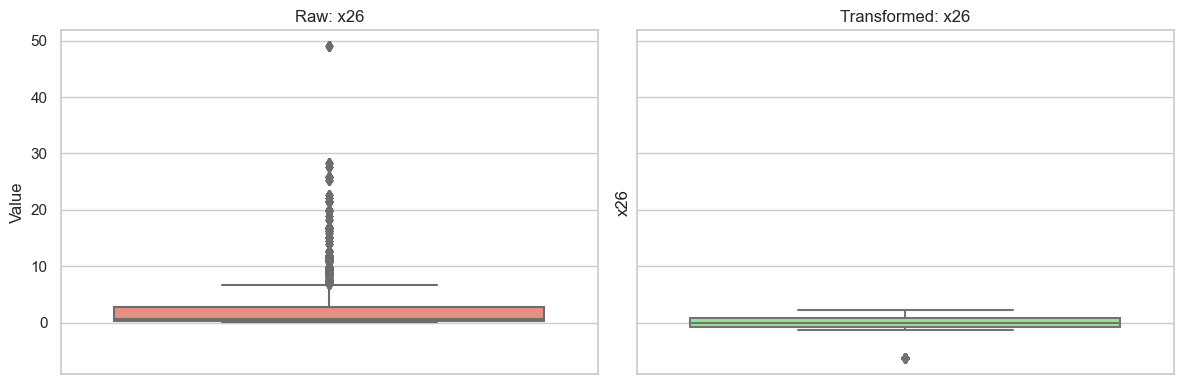

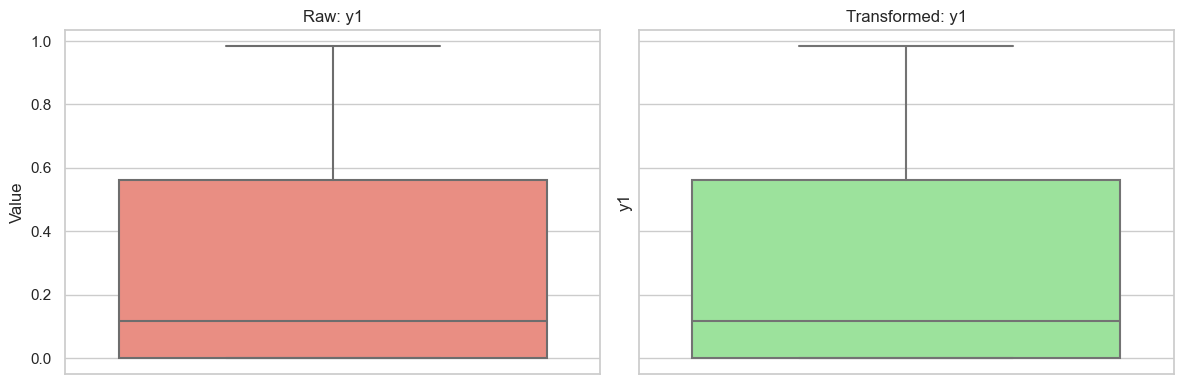

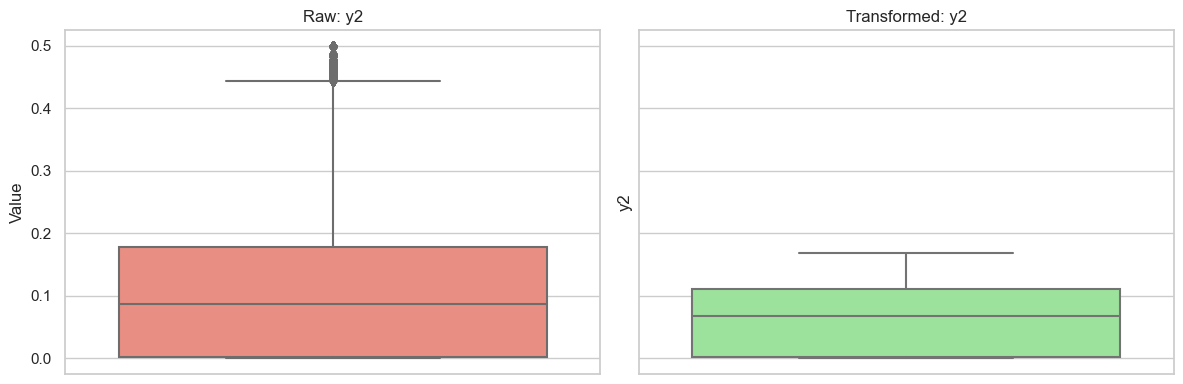

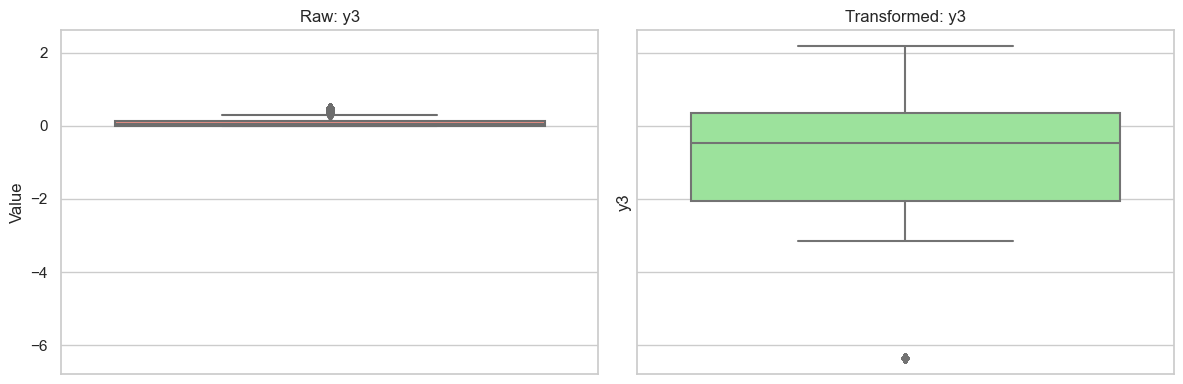

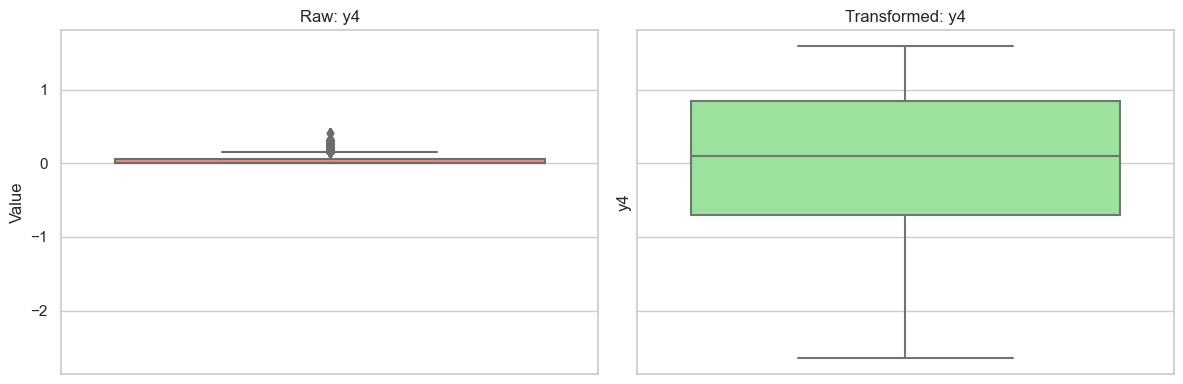

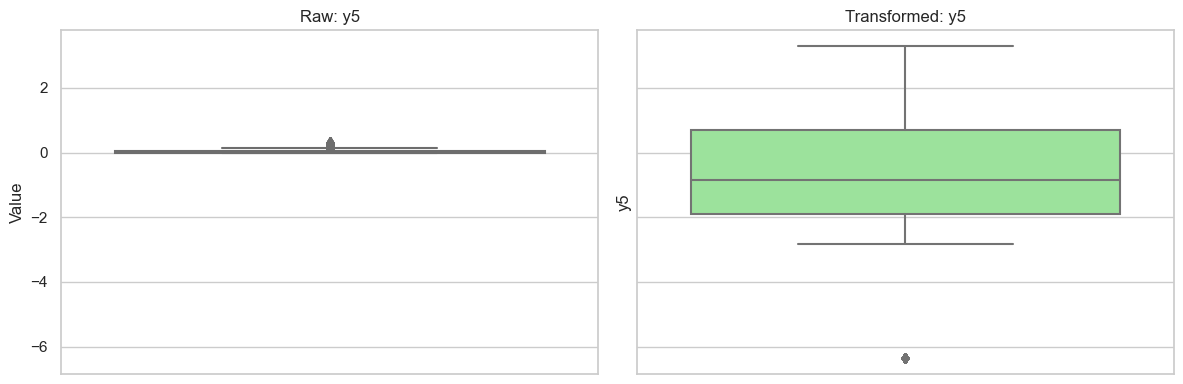

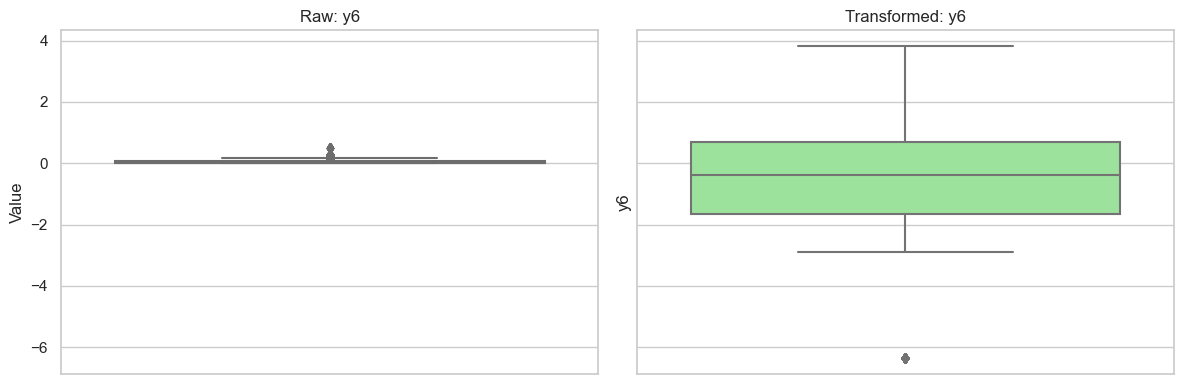

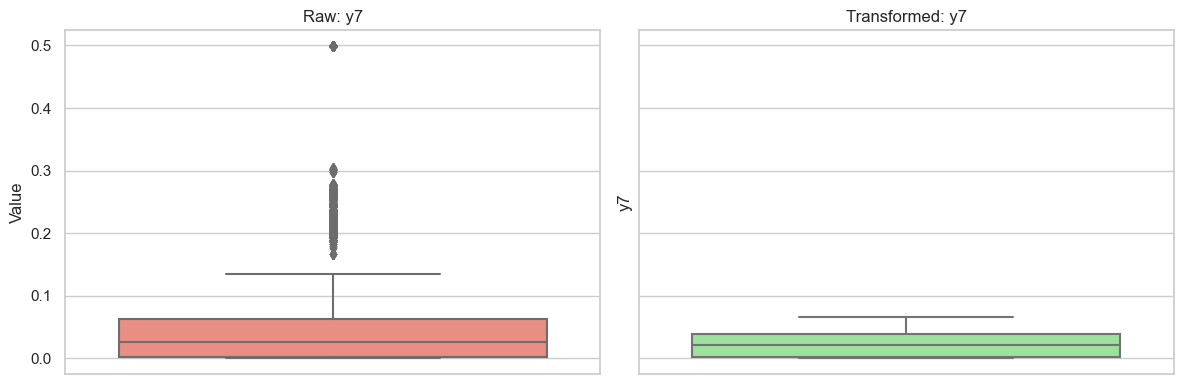

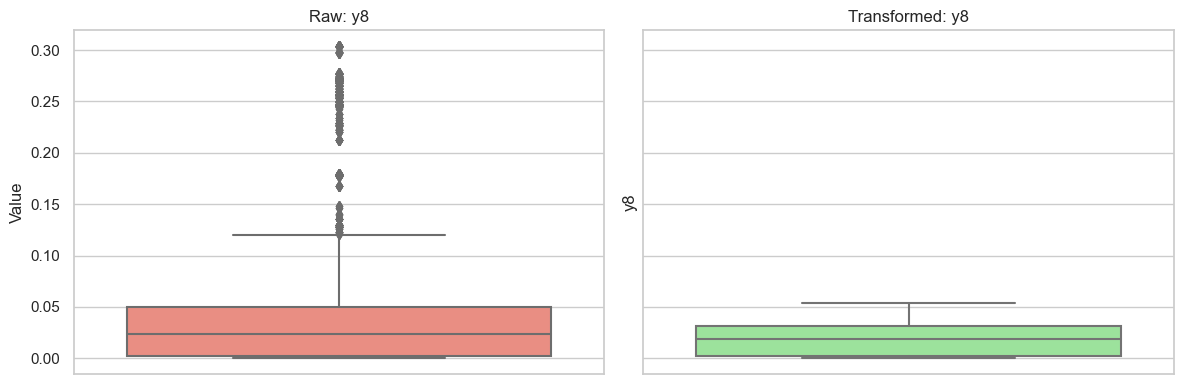

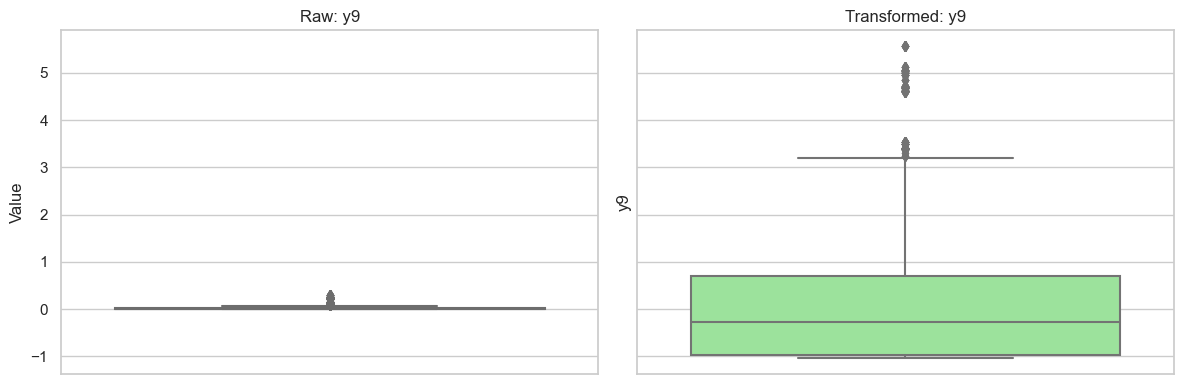

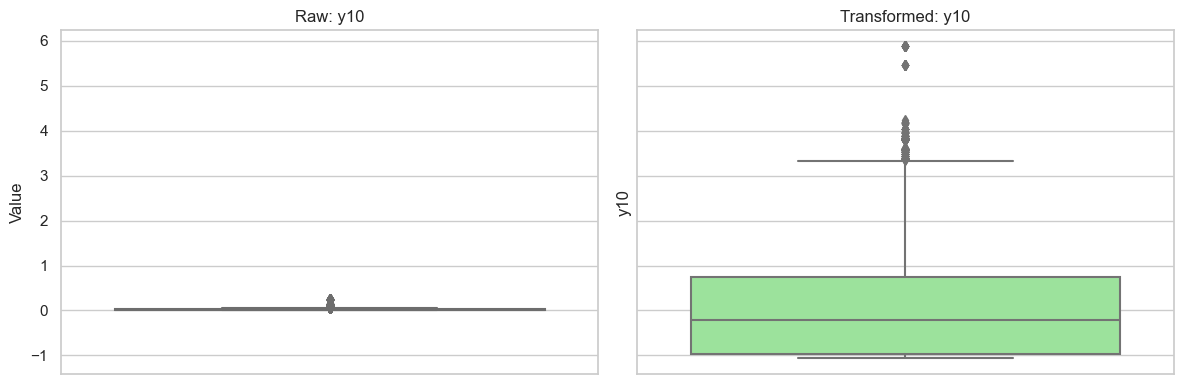

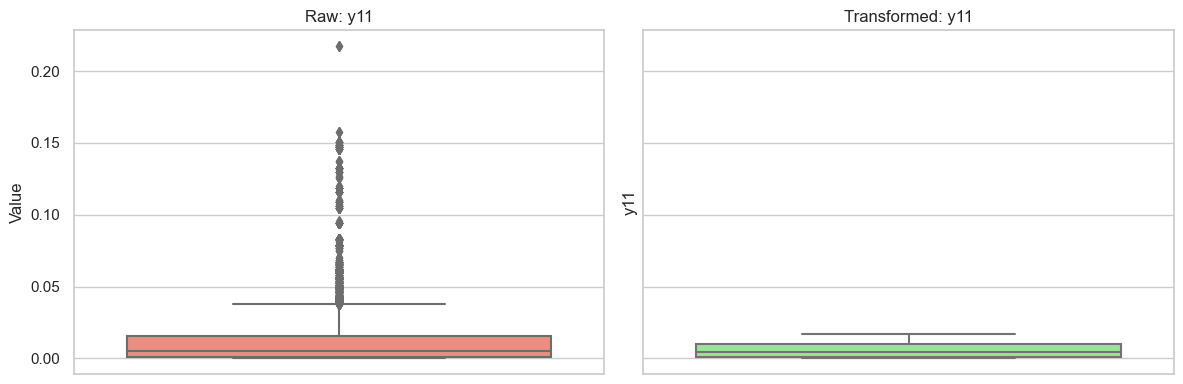

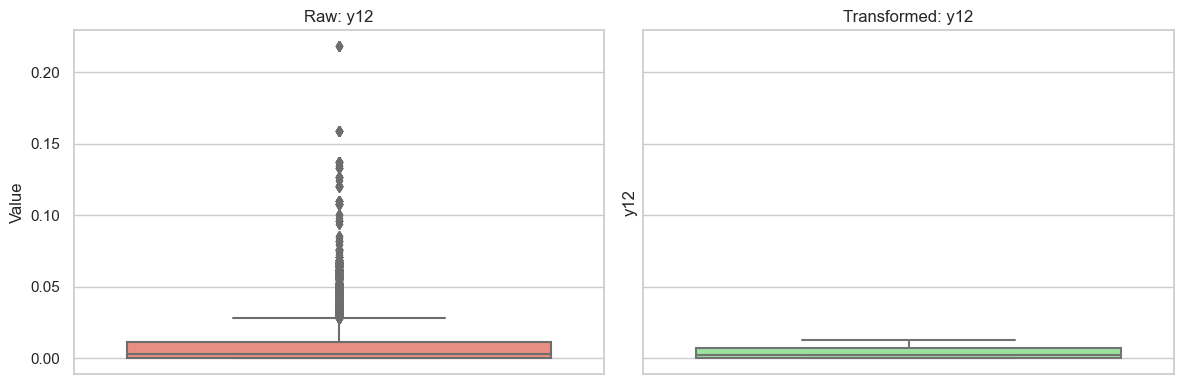

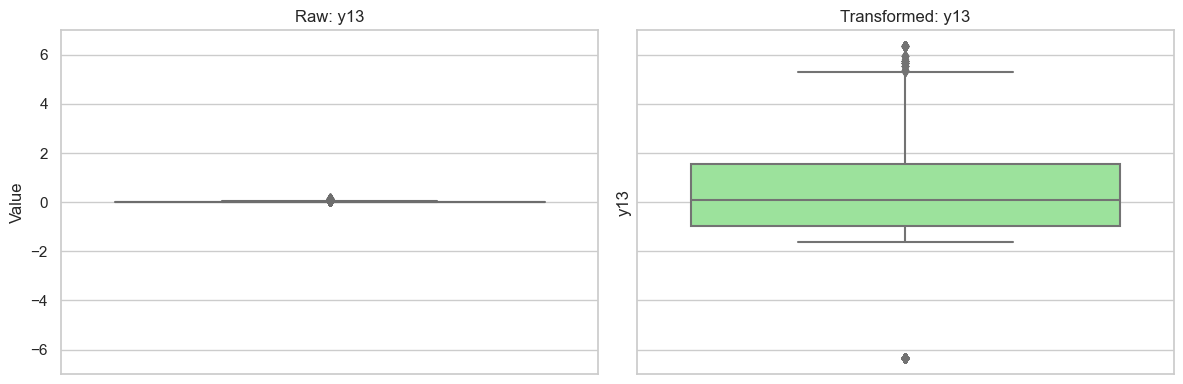

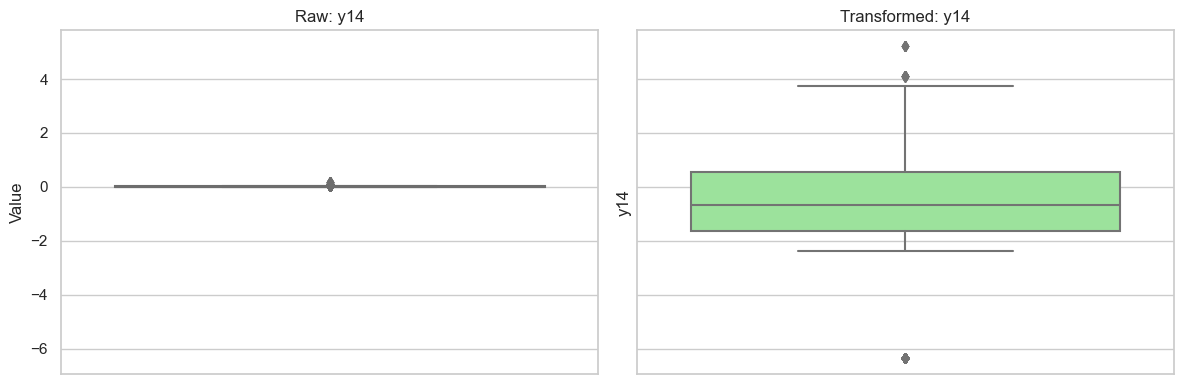

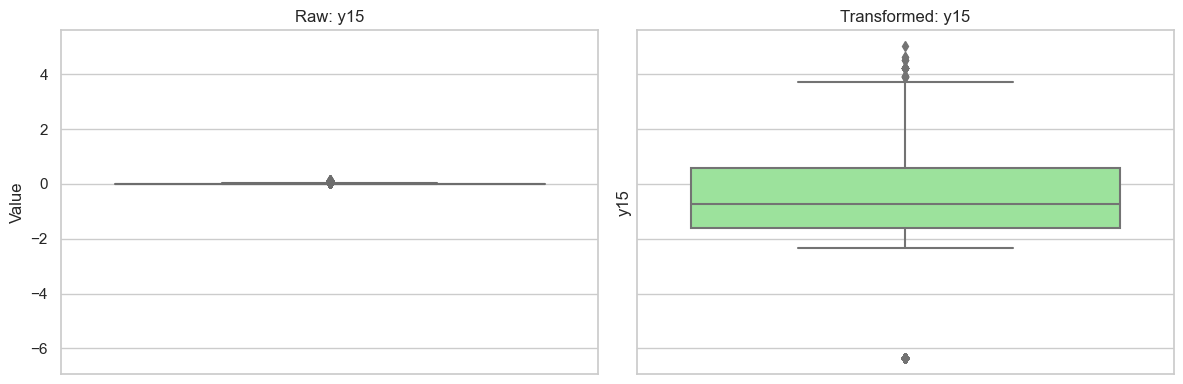

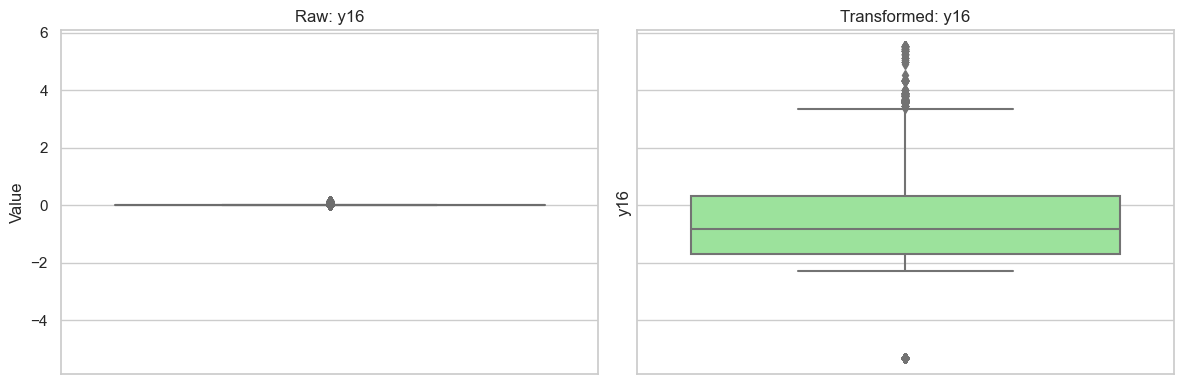

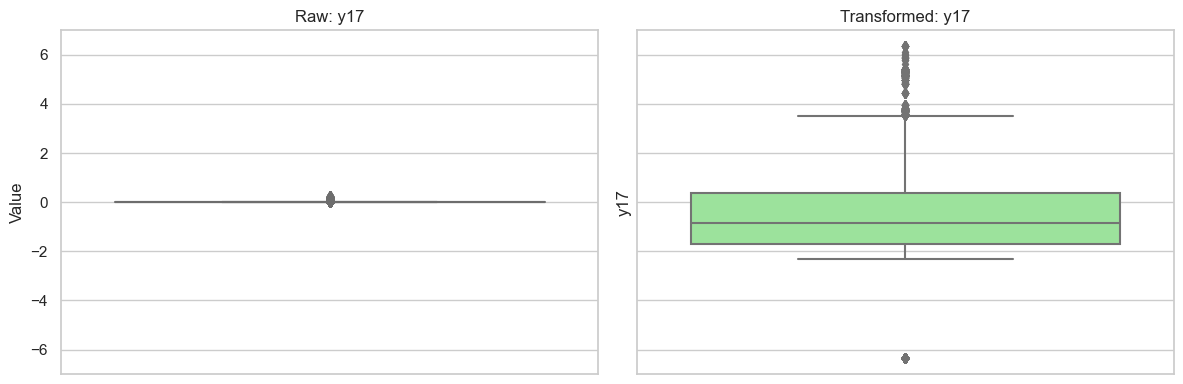

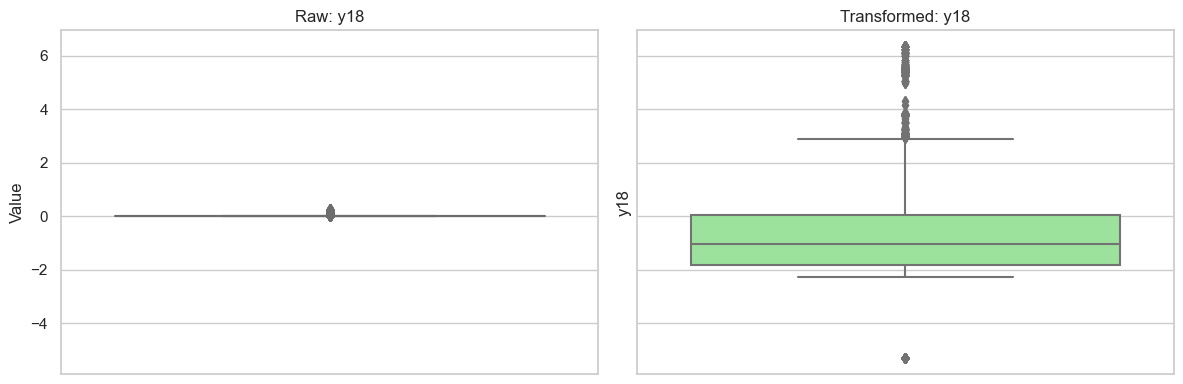

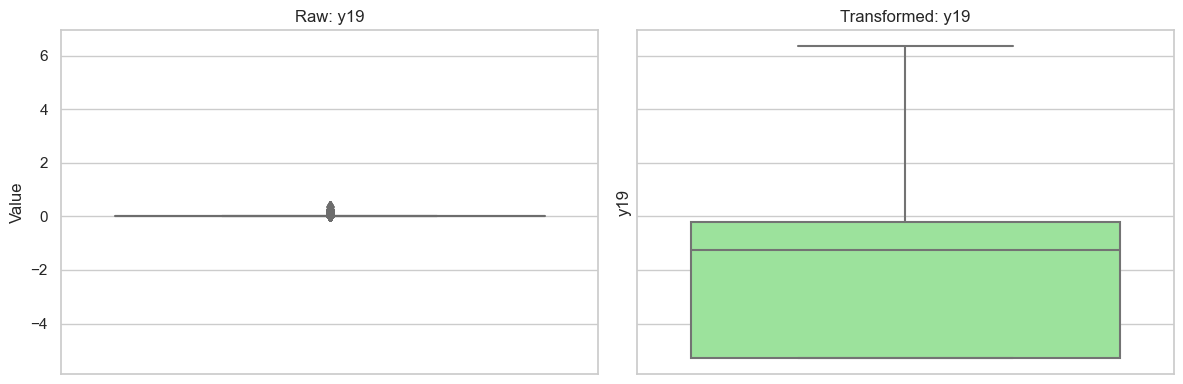

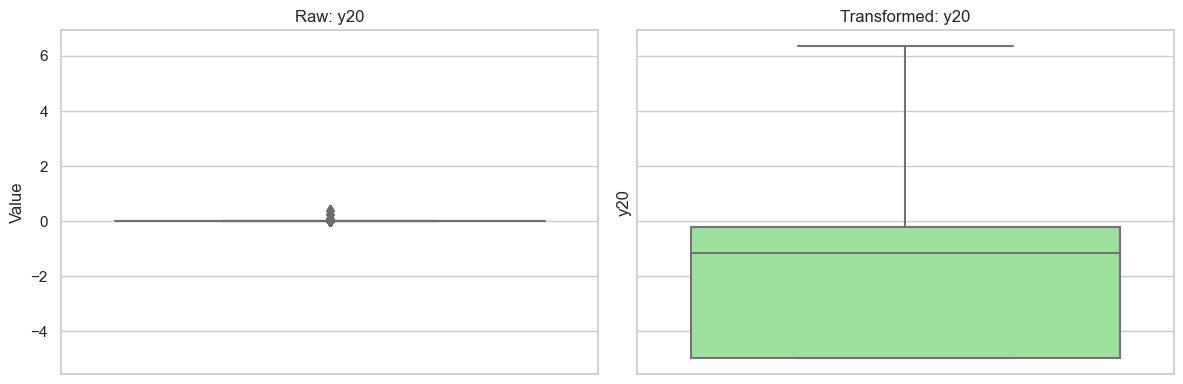

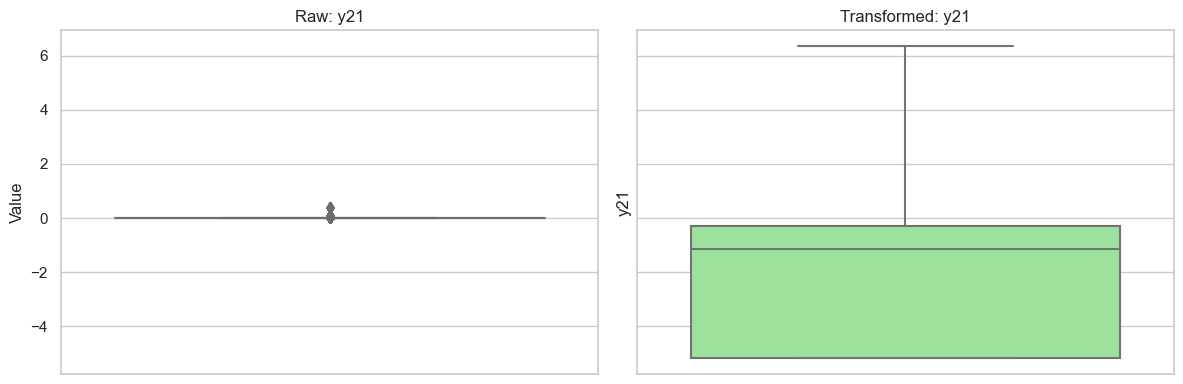

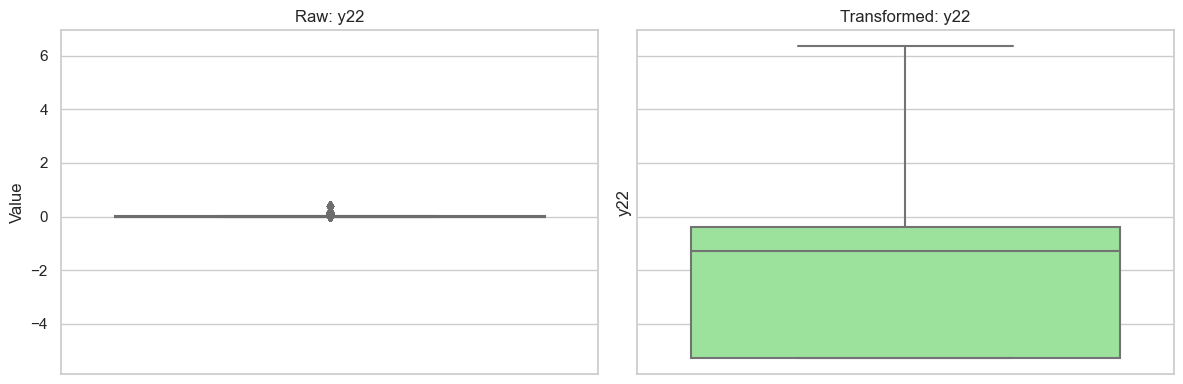

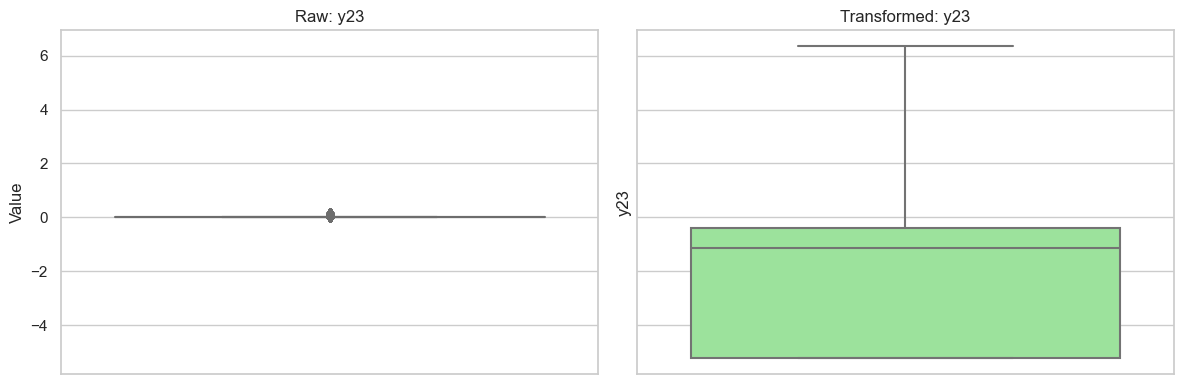

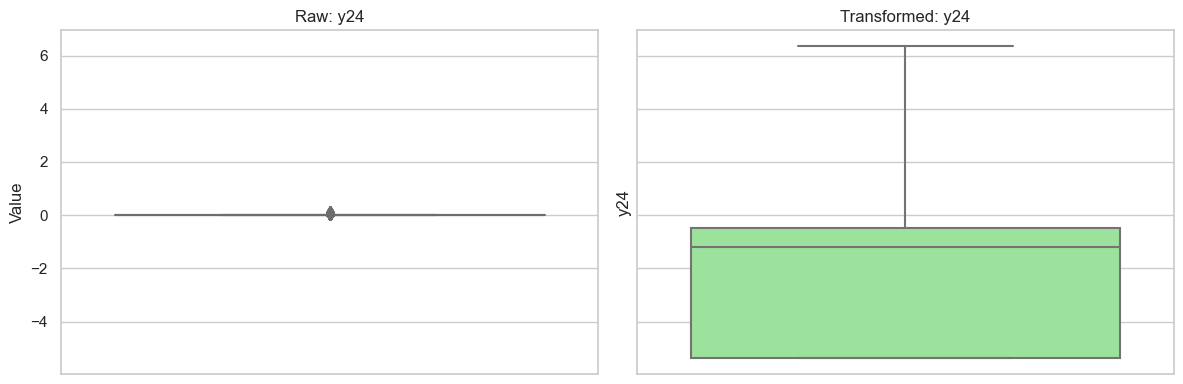

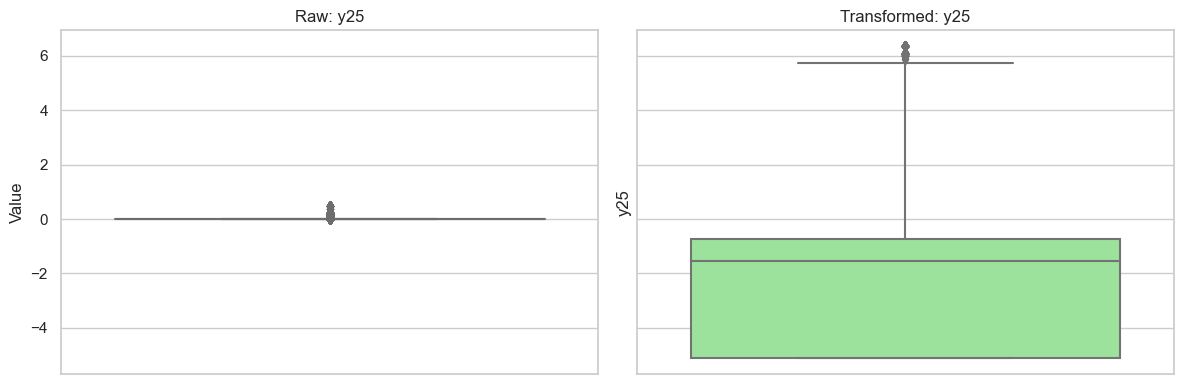

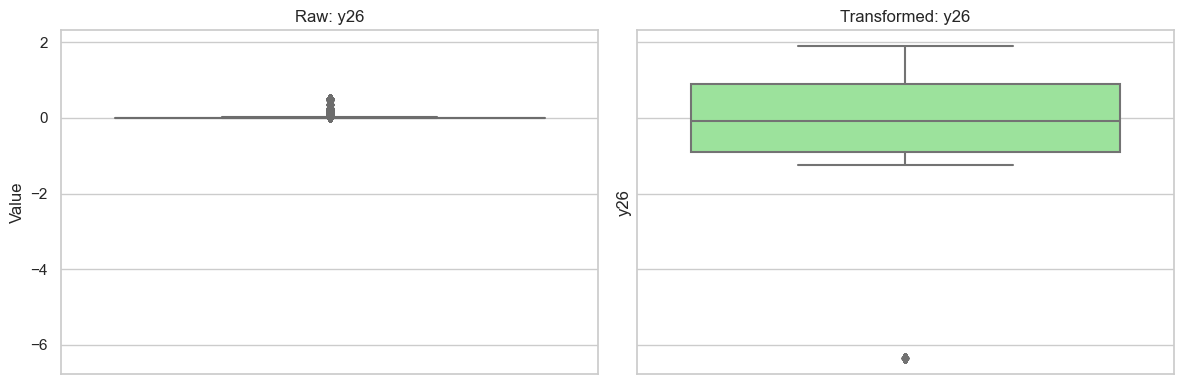

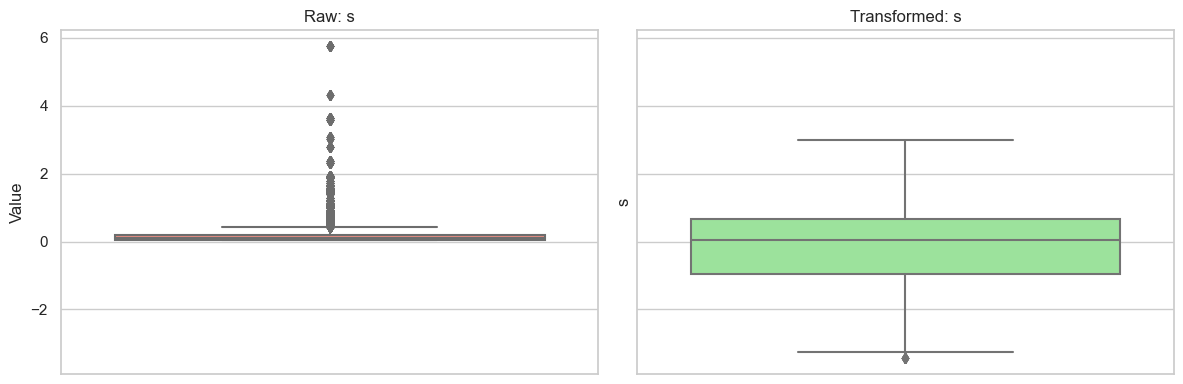

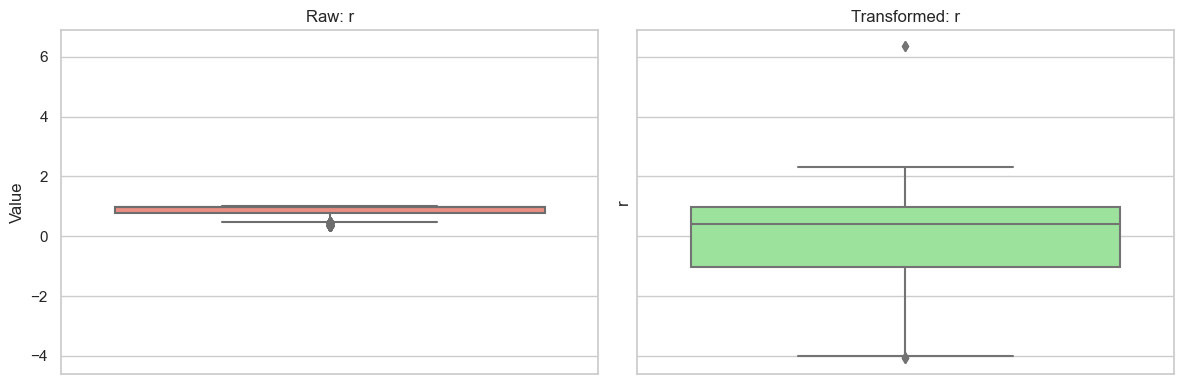

In [12]:
# === List of features to analyze (excluding label column) ===
features = df.drop(columns="l").columns

# Set seaborn style for consistent clean visuals
sns.set(style="whitegrid")

# Plot raw and transformed boxplots side by side for each feature
for feature in features:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Left: Raw feature
    sns.boxplot(y=df[feature], ax=axs[0], color='salmon')
    axs[0].set_title(f"Raw: {feature}")
    axs[0].set_ylabel("Value")

    # Right: Transformed or selected feature from df_final_prefilter
    sns.boxplot(y=df_final_prefilter[feature], ax=axs[1], color='lightgreen')
    axs[1].set_title(f"Transformed: {feature}")

    plt.tight_layout()
    plt.show()



## 🧹 Outlier Removal: Univariate (IQR) + Multivariate (Isolation Forest)

This step removes anomalous rows from the datasets by combining two strategies:

### 1️⃣ Univariate Filtering:
- Based on the **Interquartile Range (IQR)** rule.
- Flags a row as outlier if **any** feature is outside 1.5 × IQR bounds.
- Using this methods because data is not univariate normal.

### 2️⃣ Multivariate Filtering:
- Uses an **Isolation Forest**, tested over a range of contamination levels.
- Best contamination level is chosen using the **Silhouette Score** as quality metric.
- Using this methods because data is not multivariate normal.

### ✅ Final Filtering:
We only remove rows that are flagged by **both methods simultaneously**, to reduce over-pruning.

The process is applied separately to:
- `df` (raw)
- `df_final_prefilter` (partially transformed)


In [13]:
# === Univariate IQR Filtering ===
def get_iqr_removal_mask(df_features):
    mask = np.zeros(len(df_features), dtype=bool)
    for col in df_features.columns:
        q1 = df_features[col].quantile(0.25)
        q3 = df_features[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        # Flag any point outside IQR range
        mask |= (df_features[col] < lower) | (df_features[col] > upper)
    return mask  # True where outlier

# === Multivariate Filtering using Isolation Forest ===
def try_isolation_forest_auto(df_features, contamination_vals):
    best_score = -np.inf
    best_mask = None
    best_cont = None

    X_scaled = StandardScaler().fit_transform(df_features)

    for cont in contamination_vals:
        iso = IsolationForest(contamination=cont, random_state=42)
        preds = iso.fit_predict(X_scaled)

        try:
            sample_limit = min(10000, len(df_features))
            sample_idx = np.random.choice(len(df_features), size=sample_limit, replace=False)
            sil = silhouette_score(X_scaled[sample_idx], preds[sample_idx])
        except:
            sil = -np.inf

        if sil > best_score:
            best_score = sil
            best_mask = preds == -1  # True = outlier
            best_cont = cont

    return best_mask, best_cont, best_score

# === Apply both IQR and Isolation Forest ===
def filter_dataset(df_input, name="Dataset"):
    X = df_input.drop(columns="l")
    y = df_input["l"]

    # Univariate mask via IQR rule
    mask_univ = get_iqr_removal_mask(X)

    # Multivariate mask via best Isolation Forest
    contaminations = np.concatenate([
        np.linspace(0.0001, 0.001, 10),
        np.linspace(0.001, 0.01, 10),
        np.linspace(0.01, 0.15, 15)
    ])
    mask_mv, best_cont, best_score = try_isolation_forest_auto(X, contaminations)

    # Keep only rows that are NOT outliers in both methods
    mask_combined = mask_univ & mask_mv
    df_filtered = df_input.loc[~mask_combined].reset_index(drop=True)

    # Reporting
    before = len(df_input)
    after = len(df_filtered)
    lost = before - after
    pct_lost = 100 * lost / before

    print(f"\n📊 {name} — Outlier Filtering Summary")
    print(f"- Best Isolation Forest contamination: {best_cont:.4f}")
    print(f"- Best silhouette score: {best_score:.4f}")
    print(f"- Rows before: {before}")
    print(f"- Rows after:  {after}")
    print(f"- Removed:     {lost} ({pct_lost:.2f}%)")

    return df_filtered

# === Apply outlier filtering to both versions ===
df_raw_filtered = filter_dataset(df, name="Raw")
df_final_filtered = filter_dataset(df_final_prefilter, name="Transformed (final_prefilter)")



📊 Raw — Outlier Filtering Summary
- Best Isolation Forest contamination: 0.0007
- Best silhouette score: 0.8436
- Rows before: 20000
- Rows after:  19988
- Removed:     12 (0.06%)

📊 Transformed (final_prefilter) — Outlier Filtering Summary
- Best Isolation Forest contamination: 0.0008
- Best silhouette score: 0.5215
- Rows before: 20000
- Rows after:  19984
- Removed:     16 (0.08%)


## 🔍 Feature Value Ranges (Min / Max) After Outlier Removal

Before scaling the features, it’s useful to inspect their **minimum and maximum values** across each dataset.

This allows us to:
- Understand feature magnitudes
- Identify remaining anomalies
- Choose appropriate scalers (e.g., `RobustScaler` for skewed data)

We apply this to both:
- `df_raw_filtered`
- `df_final_filtered` (transformed and cleaned)


In [14]:
# Utility: Summarize min and max per feature
def summarize_min_max(df, name=""):
    summary = df.drop(columns="l").agg(["min", "max"]).T  # Aggregate across rows
    summary = summary.rename(columns={"min": "Min", "max": "Max"})
    summary = summary.sort_index()
    print(f"\n📊 Min/Max Summary — {name}")
    display(summary.T)

# Run summary on both cleaned datasets
summarize_min_max(df_raw_filtered, name="Raw Filtered")
summarize_min_max(df_final_filtered, name="Final Filtered (Transformed)")




📊 Min/Max Summary — Raw Filtered


r       s      x1     x10      x11      x12      x13      x14  \
Min  0.3307  0.0332  0.0023   0.023   0.0253   0.0276   0.0299   0.0322   
Max  1.0000  5.7652  1.9195  19.195  21.1140  23.0340  24.9540  26.8730   

         x15      x16      x17      x18      x19      x2     x20      x21  \
Min   0.0345   0.0368   0.0391   0.0414   0.0437  0.0046   0.046   0.0483   
Max  28.7930  30.7120  32.6320  34.5510  36.4710  3.8390  38.390  40.3100   

         x22      x23      x24      x25      x26      x3      x4      x5  \
Min   0.0506   0.0529   0.0552   0.0575   0.0611  0.0069  0.0092  0.0115   
Max  42.2290  44.1490  46.0680  47.9880  49.0830  5.7585  7.6780  9.5975   

          x6       x7       x8       x9      y1     y10     y11     y12  \
Min   0.0138   0.0161   0.0184   0.0207  0.0000  0.0000  0.0000  0.0000   
Max  11.5170  13.4370  15.3560  17.2760  0.9844  0.2583  0.2175  0.2183   

        y13     y14    y15     y16     y17     y18     y19      y2     y20  \
Min  0.0000  0.0000  0.000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000   
Max  0.1805  0.1808  0.159  0.1595  0.2701  0.2712  0.3985  0.4995  0.3988   

        y21     y22    y23     y24    y25     y26      y3      y4      y5  \
Min  0.0000  0.0000  0.000  0.0000  0.000  0.0002  0.0000  0.0000  0.0000   
Max  0.4074  0.4076  0.162  0.1748  0.494  0.4940  0.4994  0.4072  0.3203   

         y6      y7     y8     y9  
Min  0.0000  0.0000  0.000  0.000  
Max  0.4991  0.4992  0.304  0.306


📊 Min/Max Summary — Final Filtered (Transformed)


r         s        x1       x10       x11       x12       x13  \
Min -4.085453 -3.441525 -8.042355 -4.246416 -4.109123 -3.984965 -3.871735   
Max  6.361341  2.981095  0.632410  2.536775  2.605959  2.668537  2.725562   

          x14       x15       x16       x17       x18       x19        x2  \
Min -3.767716 -3.671604 -3.582330 -3.499003 -3.420936 -3.347503 -6.801767   
Max  2.777967  2.826378  2.871311  2.913271  2.952551  2.989520  1.255556   

          x20       x21       x22       x23       x24       x25       x26  \
Min -3.278224 -3.212675 -3.148471 -3.089427 -3.033144 -2.979394 -6.361341   
Max  3.024375  3.057366  3.088643  3.118403  3.146772  3.173845  2.174990   

           x3        x4        x5        x6        x7        x8        x9  \
Min -6.117577 -5.649627 -5.296392 -5.013961 -4.779407 -4.573153 -4.399742   
Max  1.599313  1.834366  2.011785  2.153627  2.271472  2.371941  2.459442   

         y1       y10       y11      y12       y13       y14       y15  \
Min  0.0000 -1.066915 -0.000000 -0.00000 -6.361341 -6.361341 -6.361341   
Max  0.9844  5.887182  0.016649  0.01298  6.361341  5.226084  5.032819   

          y16       y17       y18       y19        y2       y20       y21  \
Min -5.317897 -6.361341 -5.312288 -5.300675 -0.000000 -4.980372 -5.184292   
Max  5.534910  6.361341  6.361341  6.361341  0.168282  6.361341  6.361341   

          y22       y23       y24       y25       y26        y3        y4  \
Min -5.290221 -5.236404 -5.383143 -5.123099 -6.361341 -6.361341 -2.650492   
Max  6.361341  6.361341  6.361341  6.361341  1.906579  2.185277  1.595722   

           y5        y6        y7        y8        y9  
Min -6.361341 -6.361341 -0.000000 -0.000000 -1.040840  
Max  3.295868  3.824450  0.065878  0.053564  5.568141

## 🔧 Scaling Features with RobustScaler

We apply **`RobustScaler`** to all features (excluding the label `l`) to reduce the impact of outliers and skewed distributions.

### Why RobustScaler?
- Uses the **median** and **IQR** instead of mean and standard deviation.
- More robust to **non-normal data** and **extreme values**.

This cell performs:
1. Descriptive statistics **before scaling**
2. Scaling using `RobustScaler`
3. Descriptive statistics **after scaling**
4. Returns the scaled DataFrame and the scaler object

We apply this to:
- `df_raw_filtered`
- `df_final_filtered`


In [15]:
def describe_and_scale(df, name=""):
    print(f"\n📊 {name} — BEFORE scaling:")
    display(df.describe(include="all"))  # Summary before scaling

    # Split into features and label
    features = df.drop(columns="l")
    labels = df["l"]

    # Apply RobustScaler
    scaler = RobustScaler()
    scaled_values = scaler.fit_transform(features)

    # Rebuild DataFrame with scaled values + label
    df_scaled = pd.DataFrame(scaled_values, columns=features.columns, index=df.index)
    df_scaled["l"] = labels.values

    print(f"\n📊 {name} — AFTER RobustScaler:")
    display(df_scaled.describe(include="all"))

    return df_scaled, scaler

# Apply to both datasets
df_raw_scaled, scaler_raw = describe_and_scale(df_raw_filtered, name="Raw Filtered")
df_final_scaled, scaler_final = describe_and_scale(df_final_filtered, name="Final Filtered")




📊 Raw Filtered — BEFORE scaling:


x1            x2            x3            x4            x5  \
count  19988.000000  19988.000000  19988.000000  19988.000000  19988.000000   
mean       0.108004      0.216007      0.324010      0.432013      0.540017   
std        0.159789      0.319578      0.479367      0.639155      0.798944   
min        0.002300      0.004600      0.006900      0.009200      0.011500   
25%        0.026400      0.052800      0.079300      0.105700      0.132100   
50%        0.045400      0.090750      0.136100      0.181500      0.226900   
75%        0.126300      0.252625      0.378925      0.505250      0.631550   
max        1.919500      3.839000      5.758500      7.678000      9.597500   

                 x6            x7            x8            x9           x10  \
count  19988.000000  19988.000000  19988.000000  19988.000000  19988.000000   
mean       0.648020      0.756024      0.864027      0.972030      1.080033   
std        0.958734      1.118523      1.278309      1.438099      1.597888   
min        0.013800      0.016100      0.018400      0.020700      0.023000   
25%        0.158500      0.185000      0.211400      0.237800      0.264200   
50%        0.272250      0.317650      0.363000      0.408350      0.453750   
75%        0.757875      0.884175      1.010500      1.136800      1.263100   
max       11.517000     13.437000     15.356000     17.276000     19.195000   

                x11           x12           x13           x14           x15  \
count  19988.000000  19988.000000  19988.000000  19988.000000  19988.000000   
mean       1.188037      1.296040      1.404044      1.512047      1.620050   
std        1.757680      1.917467      2.077256      2.237043      2.396832   
min        0.025300      0.027600      0.029900      0.032200      0.034500   
25%        0.290600      0.317100      0.343500      0.369900      0.396300   
50%        0.499150      0.544450      0.589850      0.635250      0.680650   
75%        1.389425      1.515725      1.642050      1.768350      1.894675   
max       21.114000     23.034000     24.954000     26.873000     28.793000   

                x16           x17           x18           x19           x20  \
count  19988.000000  19988.000000  19988.000000  19988.000000  19988.000000   
mean       1.728054      1.836057      1.944060      2.052064      2.160068   
std        2.556624      2.716406      2.876199      3.035989      3.195778   
min        0.036800      0.039100      0.041400      0.043700      0.046000   
25%        0.422775      0.449200      0.475600      0.502000      0.528400   
50%        0.726000      0.771350      0.816750      0.862100      0.907500   
75%        2.020975      2.147275      2.273600      2.399900      2.526225   
max       30.712000     32.632000     34.551000     36.471000     38.390000   

                x21           x22           x23           x24           x25  \
count  19988.000000  19988.000000  19988.000000  19988.000000  19988.000000   
mean       2.268071      2.376074      2.484077      2.592081      2.700085   
std        3.355568      3.515356      3.675145      3.834932      3.994724   
min        0.048300      0.050600      0.052900      0.055200      0.057500   
25%        0.554900      0.581300      0.607700      0.634100      0.660575   
50%        0.952900      0.998250      1.043600      1.089000      1.134400   
75%        2.652525      2.778850      2.905150      3.031475      3.157775   
max       40.310000     42.229000     44.149000     46.068000     47.988000   

                x26            y1            y2            y3            y4  \
count  19988.000000  19988.000000  19988.000000  19988.000000  19988.000000   
mean       2.358128      0.289335      0.145978      0.117875      0.041938   
std        4.141940      0.302247      0.170855      0.159734      0.061828   
min        0.061100      0.000000      0.000000      0.000000      0.000000   
25%        0.208100      0.000000      0.001800      0.002400 


📊 Raw Filtered — AFTER RobustScaler:


x1            x2            x3            x4            x5  \
count  19988.000000  1.998800e+04  19988.000000  19988.000000  19988.000000   
mean       0.626662  6.268314e-01      0.627152      0.626989      0.626924   
std        1.599486  1.599288e+00      1.599889      1.599688      1.599648   
min       -0.431431 -4.311272e-01     -0.431206     -0.431235     -0.431274   
25%       -0.190190 -1.899162e-01     -0.189570     -0.189713     -0.189809   
50%        0.000000  3.469447e-17      0.000000      0.000000      0.000000   
75%        0.809810  8.100838e-01      0.810430      0.810287      0.810191   
max       18.759760  1.875766e+01     18.764789     18.762358     18.761838   

                 x6            x7            x8            x9           x10  \
count  19988.000000  19988.000000  19988.000000  19988.000000  19988.000000   
mean       0.626937      0.626987      0.626989      0.627008      0.626973   
std        1.599556      1.599776      1.599686      1.599665      1.599647   
min       -0.431199     -0.431294     -0.431235     -0.431201     -0.431224   
25%       -0.189781     -0.189724     -0.189713     -0.189711     -0.189759   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.810219      0.810276      0.810287      0.810289      0.810241   
max       18.760792     18.764043     18.762358     18.762681     18.761888   

                x11           x12           x13           x14           x15  \
count  19988.000000  19988.000000  19988.000000  19988.000000  19988.000000   
mean       0.626931      0.627044      0.627002      0.626978      0.626946   
std        1.599600      1.599722      1.599674      1.599659      1.599621   
min       -0.431233     -0.431202     -0.431212     -0.431227     -0.431234   
25%       -0.189794     -0.189676     -0.189712     -0.189746     -0.189772   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.810206      0.810324      0.810288      0.810254      0.810228   
max       18.760813     18.762791     18.762581     18.762022     18.761892   

                x16           x17           x18           x19           x20  \
count  19988.000000  19988.000000  19988.000000  19988.000000  19988.000000   
mean       0.626989      0.627008      0.626980      0.626990      0.626966   
std        1.599690      1.599697      1.599666      1.599657      1.599629   
min       -0.431235     -0.431224     -0.431229     -0.431213     -0.431219   
25%       -0.189729     -0.189715     -0.189739     -0.189736     -0.189756   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.810271      0.810285      0.810261      0.810264      0.810244   
max       18.762358     18.762805     18.762097     18.762264     18.761653   

                x21           x22           x23           x24           x25  \
count  19988.000000  19988.000000  19988.000000  19988.000000  19988.000000   
mean       0.626981      0.626982      0.626990      0.626970      0.626976   
std        1.599699      1.599670      1.599663      1.599638      1.599681   
min       -0.431250     -0.431230     -0.431217     -0.431222     -0.431243   
25%       -0.189738     -0.189734     -0.189732     -0.189749     -0.189743   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.810262      0.810266      0.810268      0.810251      0.810257   
max       18.762696     18.762144     18.762280     18.761771     18.762454   

                x26            y1            y2            y3            y4  \
count  19988.000000  1.998800e+04  19988.000000  19988.000000  19988.000000   
mean       0.667990  3.029921e-01      0.333020      0.615046      0.551731   
std        1.583432  5.368502e-01      0.968017      1.353680      1.035638   
min       -0.210146 -2.109236e-01     -0.494051     -0.383898     -0.150754   
25%       -0.153949 -2.109236e-01     -0.483853     -0.363559 


📊 Final Filtered — BEFORE scaling:


x1            x2            x3            x4            x5  \
count  19984.000000  19984.000000  19984.000000  19984.000000  19984.000000   
mean      -3.457204     -2.542974     -2.038669     -1.693822     -1.433520   
std        1.503789      1.396763      1.337736      1.297361      1.266886   
min       -8.042355     -6.801767     -6.117577     -5.649627     -5.296392   
25%       -4.432596     -3.448935     -2.906355     -2.535320     -2.255251   
50%       -3.662336     -2.732078     -2.220237     -1.869800     -1.605300   
75%       -2.310878     -1.478115     -1.018843     -0.704793     -0.467694   
max        0.632410      1.255556      1.599313      1.834366      2.011785   

                 x6            x7            x8            x9           x10  \
count  19984.000000  19984.000000  19984.000000  19984.000000  19984.000000   
mean      -1.225387     -1.052538     -0.905089     -0.776753     -0.663315   
std        1.242519      1.222284      1.205022      1.189995      1.176715   
min       -5.013961     -4.779407     -4.573153     -4.399742     -4.246416   
25%       -2.031310     -1.845335     -1.686689     -1.548242     -1.426229   
50%       -1.394029     -1.218196     -1.068537     -0.938132     -0.822864   
75%       -0.278149     -0.120737      0.013499      0.130378      0.233694   
max        2.153627      2.271472      2.371941      2.459442      2.536775   

                x11           x12           x13           x14           x15  \
count  19984.000000  19984.000000  19984.000000  19984.000000  19984.000000   
mean      -0.561785     -0.469993     -0.386300     -0.309447     -0.238440   
std        1.164828      1.154080      1.144281      1.135285      1.126972   
min       -4.109123     -3.984965     -3.871735     -3.767716     -3.671604   
25%       -1.317022     -1.218286     -1.128261     -1.045589     -0.969207   
50%       -0.719810     -0.626533     -0.541489     -0.463395     -0.391246   
75%        0.326178      0.409777      0.485999      0.556006      0.620673   
max        2.605959      2.668537      2.725562      2.777967      2.826378   

                x16           x17           x18           x19           x20  \
count  19984.000000  19984.000000  19984.000000  19984.000000  19984.000000   
mean      -0.172489     -0.110949     -0.053292      0.000927      0.052075   
std        1.119250      1.112044      1.105294      1.098946      1.092959   
min       -3.582330     -3.499003     -3.420936     -3.347503     -3.278224   
25%       -0.898263     -0.832062     -0.770037     -0.711765     -0.656738   
50%       -0.324305     -0.261771     -0.203183     -0.148091     -0.096175   
75%        0.680736      0.736793      0.789302      0.838680      0.885271   
max        2.871311      2.913271      2.952551      2.989520      3.024375   

                x21           x22           x23           x24           x25  \
count  19984.000000  19984.000000  19984.000000  19984.000000  19984.000000   
mean       0.100468      0.146376      0.190032      0.231636      0.271364   
std        1.087293      1.081917      1.076805      1.071935      1.067284   
min       -3.212675     -3.148471     -3.089427     -3.033144     -2.979394   
25%       -0.604675     -0.555285     -0.508320     -0.463560     -0.420701   
50%       -0.046999     -0.000350      0.043961      0.086283      0.126608   
75%        0.929344      0.971161      1.010894      1.048785      1.084974   
max        3.057366      3.088643      3.118403      3.146772      3.173845   

                x26            y1            y2            y3            y4  \
count  19984.000000  19984.000000  19984.000000  19984.000000  19984.000000   
mean       0.000650      0.289682      0.069752     -0.742355      0.002125   
std        1.066569      0.302258      0.061061      2.084961      0.997596   
min       -6.361341      0.000000     -0.000000     -6.361341     -2.650492   
25%       -0.863303      0.000000      0.001889     -2.050424 


📊 Final Filtered — AFTER RobustScaler:


x1            x2            x3            x4            x5  \
count  19984.000000  19984.000000  19984.000000  19984.000000  19984.000000   
mean       0.096682      0.095952      0.096194      0.096135      0.096097   
std        0.708760      0.708722      0.708730      0.708736      0.708725   
min       -2.064374     -2.064972     -2.064804     -2.064884     -2.064881   
25%       -0.363036     -0.363736     -0.363504     -0.363568     -0.363597   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.636964      0.636264      0.636496      0.636432      0.636403   
max        2.024184      2.023337      2.023590      2.023552      2.023480   

                 x6            x7            x8            x9           x10  \
count  19984.000000  19984.000000  19984.000000  19984.000000  19984.000000   
mean       0.096193      0.096056      0.096136      0.096138      0.096119   
std        0.708731      0.708735      0.708758      0.708913      0.708897   
min       -2.064802     -2.064951     -2.061312     -2.062177     -2.062477   
25%       -0.363504     -0.363643     -0.363578     -0.363459     -0.363489   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.636496      0.636357      0.636422      0.636541      0.636511   
max        2.023577      2.023467      2.023588      2.024029      2.023974   

                x11           x12           x13           x14           x15  \
count  19984.000000  1.998400e+04  19984.000000  19984.000000  19984.000000   
mean       0.096169  9.615105e-02      0.096136      0.096122      0.096112   
std        0.708877  7.088669e-01      0.708858      0.708847      0.708841   
min       -2.062629 -2.062839e+00     -2.063017     -2.063144     -2.063274   
25%       -0.363444 -3.634707e-01     -0.363493     -0.363509     -0.363525   
50%        0.000000 -3.409816e-17      0.000000      0.000000      0.000000   
75%        0.636556  6.365293e-01      0.636507      0.636491      0.636475   
max        2.023958  2.023920e+00      2.023870      2.023834      2.023815   

                x16           x17           x18           x19           x20  \
count  19984.000000  19984.000000  19984.000000  19984.000000  19984.000000   
mean       0.096147      0.096136      0.096125      0.096113      0.096140   
std        0.708835      0.708825      0.708822      0.708794      0.708789   
min       -2.063349     -2.063436     -2.063535     -2.063544     -2.063574   
25%       -0.363495     -0.363508     -0.363522     -0.363556     -0.363528   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.636505      0.636492      0.636478      0.636444      0.636472   
max        2.023824      2.023796      2.023763      2.023684      2.023691   

                x21           x22           x23           x24           x25  \
count  19984.000000  19984.000000  19984.000000  1.998400e+04  1.998400e+04   
mean       0.096132      0.096123      0.096149  9.611066e-02  9.614051e-02   
std        0.708787      0.708782      0.708791  7.087900e-01  7.088412e-01   
min       -2.063649     -2.062386     -2.062506 -2.062642e+00 -2.062864e+00   
25%       -0.363539     -0.363547     -0.363531 -3.635701e-01 -3.634971e-01   
50%        0.000000      0.000000      0.000000  4.590919e-18  9.219107e-18   
75%        0.636461      0.636453      0.636469  6.364299e-01  6.365029e-01   
max        2.023681      2.023650      2.023705  2.023671e+00  2.023835e+00   

                x26            y1            y2            y3            y4  \
count  19984.000000  19984.000000  19984.000000  19984.000000  19984.000000   
mean       0.041870      0.301815      0.018676     -0.113035     -0.062309   
std        0.611884      0.536679      0.563972      0.865415      0.645801   
min       -3.607965     -0.212536     -0.625566     -2.445335     -1.779501   
25%       -0.453774     -0.212536     -0.608120     -0.655982 

## 🔗 Feature Correlation: Pearson Heatmaps

This step computes and visualizes the **Pearson correlation matrix** for both datasets.

### Why Pearson?
- Measures **linear correlation** between features (range: -1 to 1)
- Values near ±1 indicate **strong linear relationships**
- Highly correlated features may be **redundant** and good candidates for **PCA**

We use heatmaps to identify **blocks of correlated features**, which can help guide:
- Dimensionality reduction (e.g., block-wise PCA)
- Feature engineering or removal


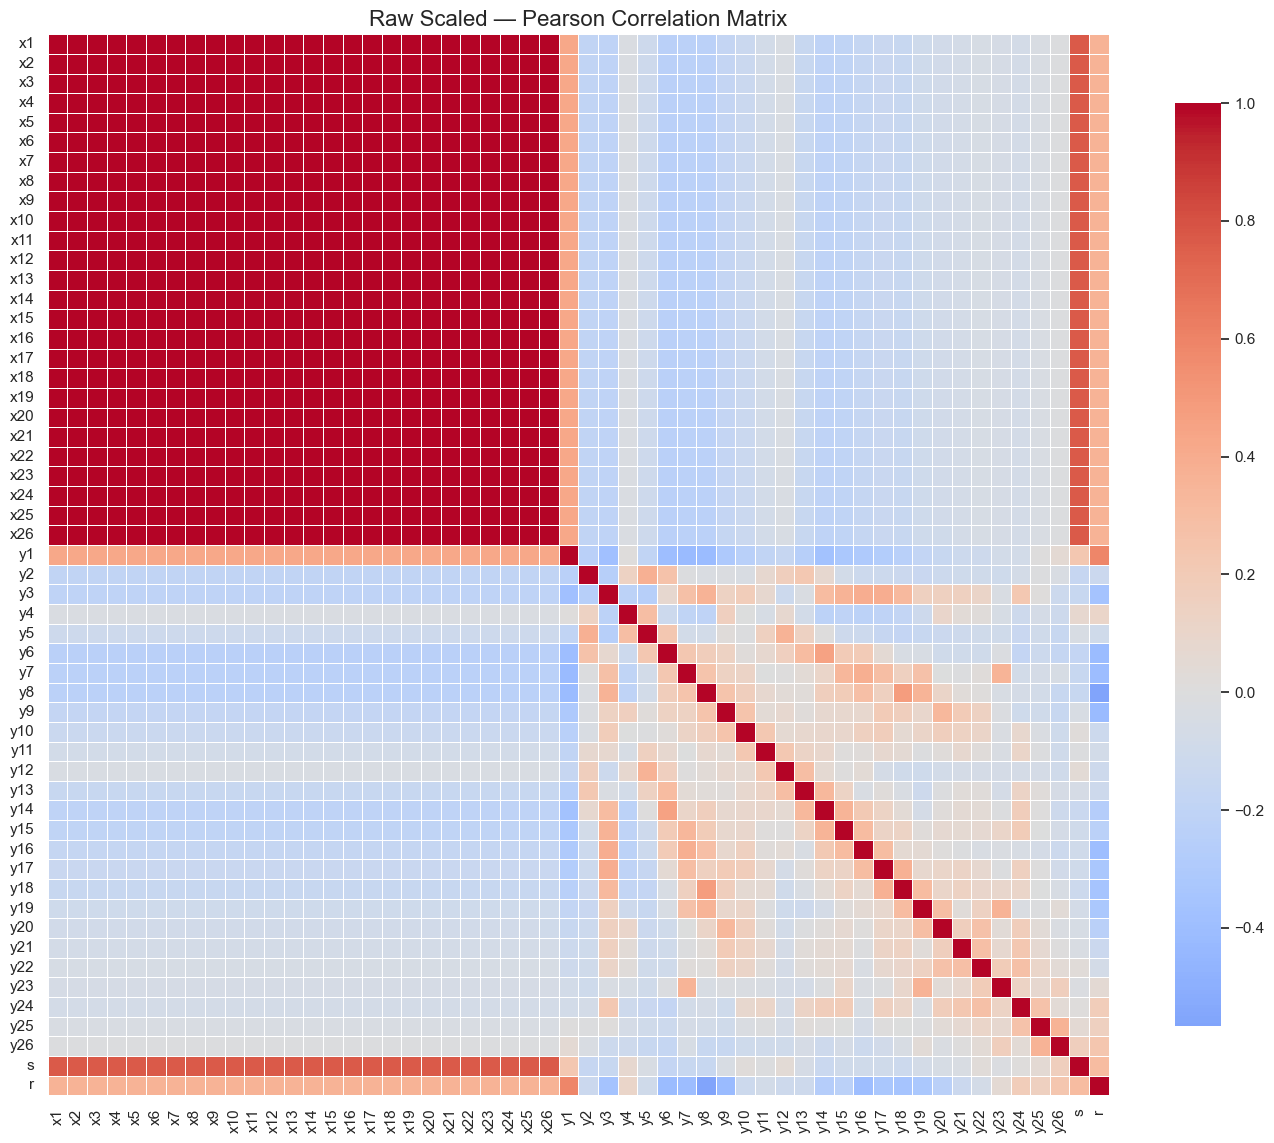

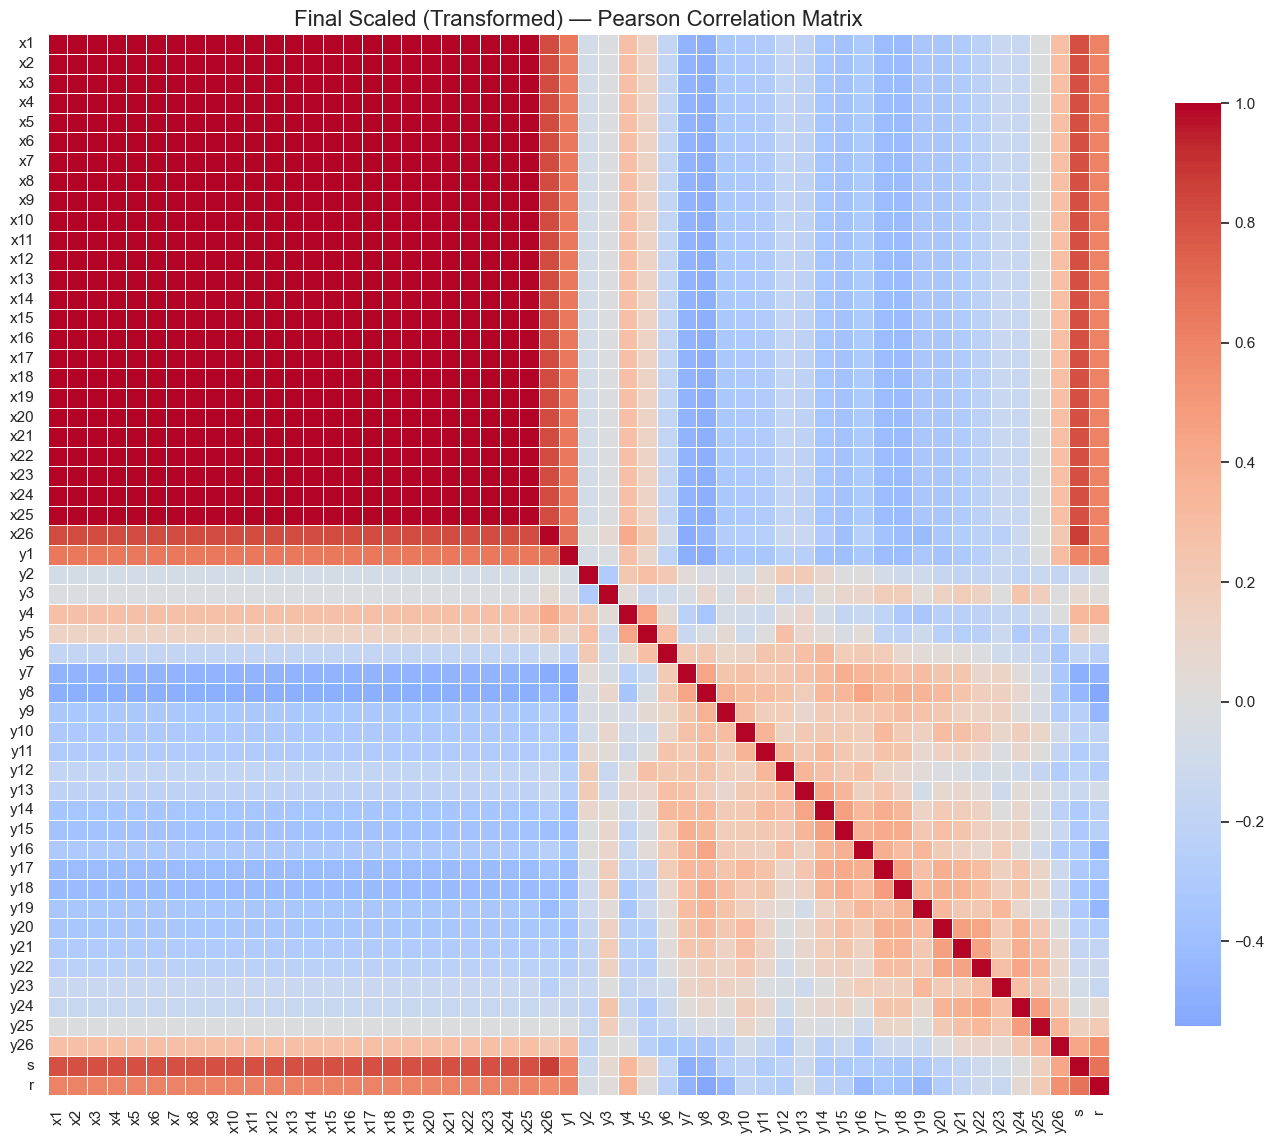

In [16]:
def plot_pearson_correlation_heatmap(df, name=""):
    # Remove the label for correlation
    features_only = df.drop(columns="l")

    # Pearson correlation matrix
    corr = features_only.corr(method="pearson")

    # Heatmap
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        corr,
        cmap="coolwarm",             # Blue → Red color scale
        center=0,                    # Centered around zero
        square=True,
        annot=False,                 # Turn on if you want exact values
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    plt.title(f"{name} — Pearson Correlation Matrix", fontsize=16)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Apply to both datasets
plot_pearson_correlation_heatmap(df_raw_scaled, name="Raw Scaled")
plot_pearson_correlation_heatmap(df_final_scaled, name="Final Scaled (Transformed)")




## 🧠 Identifying Highly Correlated Feature Sets (≥ 0.9)

This step clusters features into **correlated blocks** using a Pearson correlation threshold (default = 0.9).

### Why do this?
- Highly correlated features often carry redundant information.
- Instead of applying global PCA (which reduces interpretability), we perform **block-wise PCA** within each correlated set.
- This preserves interpretability and captures localized variance.

### Method:
- Use **graph expansion**: starting from each feature, grow a set by including all features correlated ≥ threshold.
- Refine sets to avoid:
  - Duplicates
  - Nested subsets (keep only the most distinct, non-overlapping blocks)


In [17]:
def find_correlated_feature_sets(df, threshold=0.9):
    # Compute absolute Pearson correlation matrix
    corr = df.corr().abs()
    np.fill_diagonal(corr.values, 0)  # Exclude self-correlation
    features = list(df.columns)

    # Expand feature set from a single starting feature
    def expand_feature_set(start_feature):
        visited = set()
        queue = [start_feature]
        while queue:
            current = queue.pop()
            if current not in visited:
                visited.add(current)
                new_features = corr.columns[(corr.loc[current] > threshold)].tolist()
                queue.extend([f for f in new_features if f not in visited])
        return visited

    # Step 1: Build initial raw sets (including possible overlap)
    all_sets = []
    for f in features:
        all_sets.append(expand_feature_set(f))
    sets = [s for s in all_sets if len(s) > 1]

    # Step 2: Deduplicate exact matches
    unique_sets = []
    for s in sets:
        if not any(s == other for other in unique_sets):
            unique_sets.append(s)

    # Step 3: Remove nested or overlapping subsets
    changed = True
    while changed:
        changed = False
        new_sets = []

        for i, A in enumerate(unique_sets):
            keep_A = True
            for j, B in enumerate(unique_sets):
                if i == j:
                    continue
                if A == B:
                    keep_A = False
                    break
                elif A.issubset(B):
                    keep_A = False
                    break
                elif len(A & B) > 0:
                    # Resolve partial overlaps by trimming the larger set
                    if len(A) < len(B):
                        B -= A
                        changed = True
                    else:
                        A -= B
                        changed = True
            if keep_A and len(A) > 1:
                new_sets.append(A)

        # Final deduplication
        deduped = []
        for s in new_sets:
            if not any(s == other for other in deduped):
                deduped.append(s)

        if len(deduped) != len(unique_sets):
            changed = True

        unique_sets = deduped

    # Sort for consistency
    return [sorted(s) for s in unique_sets]


## 📉 PCA Optimization (Block-wise)

For each **correlated feature block**, we apply PCA and find the **optimal number of components** using a balance between:

- 🎯 **Model Performance** (via 5-fold cross-validated Logistic Regression)
- 📊 **Explained Variance** (≥ 95%)

### How it works:
1. Tries 1 to 10 PCA components (or max if fewer features), but we try up to 10 because we know we will only have blocks up to 26, from the correlation matrix for x.
2. Evaluates model accuracy using cross-validation.
3. Plots:
   - CV accuracy vs number of components
   - Cumulative variance retained
4. Selects the best number of components that:
   - Retains **≥ 95% variance**
   - Achieves the **highest accuracy**

Returns a DataFrame of the **projected PCA components** for that block.


In [18]:
def optimize_pca_block(df_block, labels, name="block", score_metric='accuracy'):
    X = df_block.values
    y = labels.values

    max_components = min(10, X.shape[1])  # Limit PCA to 10 components max
    scores = []
    variances = []

    # Try 1 to max_components
    for n in range(1, max_components + 1):
        pca = PCA(n_components=n)
        X_pca = pca.fit_transform(X)

        # Evaluate via Logistic Regression + CV
        model = LogisticRegression(max_iter=500)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        score = cross_val_score(model, X_pca, y, cv=cv, scoring=score_metric).mean()

        scores.append(score)
        variances.append(np.sum(pca.explained_variance_ratio_))

    # === Plot ===
    plt.figure(figsize=(10, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, max_components + 1), scores, marker='o')
    plt.title(f"{name} — CV Score")
    plt.xlabel("n_components")
    plt.ylabel(score_metric)

    # Variance plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, max_components + 1), variances, marker='s', color='orange')
    plt.axhline(0.95, color='red', linestyle='--')  # 95% line
    plt.title(f"{name} — Variance Retained")
    plt.xlabel("n_components")
    plt.ylabel("Cumulative Variance")
    plt.tight_layout()
    plt.show()

    # Select best config that retains ≥ 95% variance
    best_idx = np.argmax([v if r >= 0.95 else -1 for v, r in zip(scores, variances)])
    best_n = range(1, max_components + 1)[best_idx]

    # Fit final PCA
    best_pca = PCA(n_components=best_n).fit(X)
    X_best = best_pca.transform(X)

    print(f"✅ {name}: Selected {best_n} components (score={scores[best_idx]:.4f}, variance={variances[best_idx]:.4f})")

    # Return PCA-projected DataFrame
    return pd.DataFrame(X_best, columns=[f"{name}_pca{i+1}" for i in range(best_n)], index=df_block.index)


## 🧬 Block-Wise PCA Application (Dimensionality Reduction)

This step applies **PCA to each group of highly correlated features** (identified via Pearson correlation ≥ 0.9).

### 🔍 Strategy:
1. Detect correlated feature blocks via `find_correlated_feature_sets`.
2. For each block:
   - Apply PCA using `optimize_pca_block`.
   - Retain enough components to preserve ≥ 95% variance.
   - Replace the original block with the PCA components.
3. Merge PCA components with untouched features.
4. Reattach the label column `l`.

### ✅ Output:
- A new reduced dataset with redundant features replaced by lower-dimensional representations.


In [19]:
def apply_pca_blocks(df_scaled, name="Dataset", corr_threshold=0.9):
    print(f"\n📦 Processing {name}...")

    # Split features and label
    X = df_scaled.drop(columns="l")
    y = df_scaled["l"]

    # Step 1: Find blocks of correlated features
    blocks = find_correlated_feature_sets(X, threshold=corr_threshold)
    print(f"🔍 Found {len(blocks)} correlated blocks in total with correlation threshold = {corr_threshold}.")

    # Start with full feature set
    df_reduced = X.copy()

    # Step 2: Apply PCA to each block
    for i, block in enumerate(blocks, 1):
        print(f"\n🔧 Block {i}: {block}")
        block_df = df_reduced[block]
        pca_df = optimize_pca_block(block_df, y, name=f"block{i}")

        # Replace original block with its PCA components
        df_reduced = df_reduced.drop(columns=block)
        df_reduced = pd.concat([df_reduced, pca_df], axis=1)

    # Step 3: Reattach the label column
    df_reduced["l"] = y.values

    # Report final result
    print(f"\n✅ {name} — Final shape: {df_reduced.shape}")
    print(f"📄 Preview of reduced dataset:")
    display(df_reduced.head())

    return df_reduced





📦 Processing Raw Scaled...
🔍 Found 1 correlated blocks in total with correlation threshold = 0.9.

🔧 Block 1: ['x1', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x2', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']


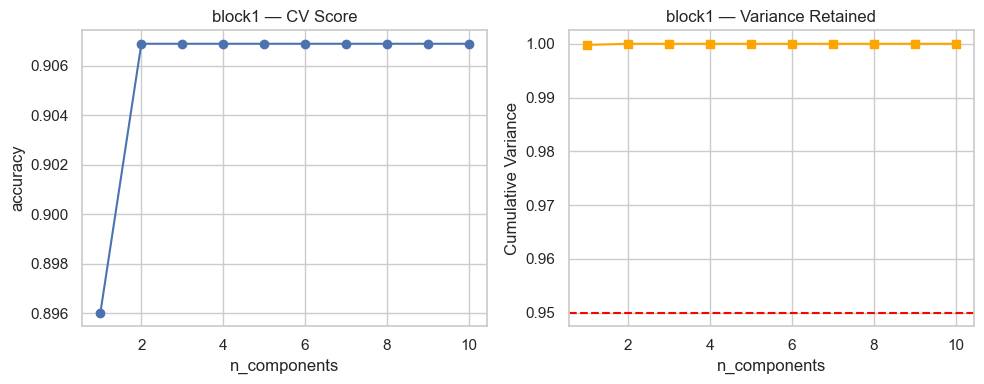

✅ block1: Selected 2 components (score=0.9069, variance=1.0000)

✅ Raw Scaled — Final shape: (19988, 31)
📄 Preview of reduced dataset:


y1        y2        y3        y4        y5        y6        y7  \
0 -0.210924 -0.494051  3.846610 -0.117253 -0.158192 -0.293909  0.179229   
1 -0.210746 -0.494051 -0.373729 -0.140704 -0.158192 -0.293909  0.179229   
2 -0.210924 -0.494051  3.846610 -0.117253 -0.158192 -0.293909  0.179229   
3 -0.210924 -0.494051  3.846610 -0.117253 -0.158192 -0.293909  0.179229   
4 -0.210924 -0.494051 -0.372881 -0.117253 -0.144285 -0.293909  0.179229   

         y8        y9       y10       y11       y12       y13       y14  \
0  0.355932 -0.380328  0.874486  1.574324 -0.261261  2.062016  2.584615   
1  0.355932 -0.380328  0.734568  1.574324 -0.261261  2.062016  2.584615   
2  0.355932 -0.380328  0.746914  1.574324 -0.261261  2.062016  2.584615   
3  0.355932  0.619672  0.874486  1.574324 -0.261261  2.062016  2.361538   
4  0.355932 -0.380328  0.730453 -0.344595 -0.261261  2.062016  2.584615   

        y15       y16       y17       y18       y19    y20        y21    y22  \
0  2.507937 -0.238095  3.173913  4.754098 -0.204545  9.625  17.238095  19.25   
1  2.507937 -0.238095  3.173913  4.754098 -0.204545  9.625  17.238095  19.25   
2  2.507937  3.428571  3.173913  4.754098  6.772727  9.625  17.238095  19.25   
3  2.507937 -0.238095  3.173913  4.754098 -0.204545  9.625  14.333333  19.25   
4  2.507937 -0.238095  3.173913  4.754098 -0.204545  9.625  17.238095  19.25   

         y23        y24      y25       y26         s         r  block1_pca1  \
0  -0.333333  26.000000  22.5000  2.654545 -0.215581  0.169203    -5.146639   
1  -0.333333  26.000000  22.5000  2.654545 -0.215581  0.169203    -4.173796   
2  25.666667  26.000000  18.4375  2.654545 -0.215581  0.167765    -4.601061   
3  -0.333333  29.666667  22.5000  2.654545 -0.215581  0.140443    -4.375744   
4  -0.333333  26.000000  22.5000  2.654545 -0.215581  0.122229    -4.535479   

   block1_pca2  l  
0     0.163194  1  
1    -0.028893  1  
2     0.055470  1  
3     0.010981  1  
4     0.042521  1


📦 Processing Final Scaled...
🔍 Found 1 correlated blocks in total with correlation threshold = 0.9.

🔧 Block 1: ['x1', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x2', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']


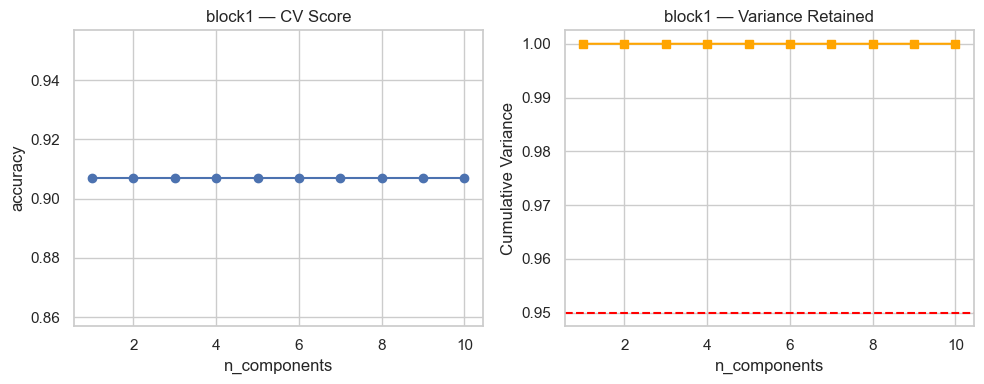

✅ block1: Selected 1 components (score=0.9069, variance=1.0000)

✅ Final Scaled — Final shape: (19984, 31)
📄 Preview of reduced dataset:


x26        y1        y2        y3        y4        y5        y6  \
0 -0.551957 -0.212536 -0.625566  1.101874 -0.385629 -2.121174 -0.682918   
1 -0.551957 -0.212358 -0.625566 -0.768465 -0.690225 -2.121174 -0.682918   
2 -0.551957 -0.212536 -0.625566  1.101874 -0.385629 -2.121174 -0.682918   
3 -0.551957 -0.212536 -0.625566  1.101874 -0.385629 -2.121174 -0.682918   
4 -0.551957 -0.212536 -0.625566 -0.755981 -0.385629 -0.469394 -0.682918   

         y7        y8        y9       y10       y11      y12       y13  \
0  0.178089  0.307992 -0.461349  0.726685  0.986170 -0.36013  1.054571   
1  0.178089  0.307992 -0.461349  0.630624  0.986170 -0.36013  1.054571   
2  0.178089  0.307992 -0.461349  0.639346  0.986170 -0.36013  1.054571   
3  0.178089  0.307992  0.560177  0.726685  0.986170 -0.36013  1.054571   
4  0.178089  0.307992 -0.461349  0.627706 -0.471439 -0.36013  1.054571   

        y14       y15       y16       y17       y18      y19      y20  \
0  1.141133  1.157538 -2.203198  1.279593  1.554726 -0.79420  0.78337   
1  1.141133  1.157538 -2.203198  1.279593  1.554726 -0.79420  0.78337   
2  1.141133  1.157538  1.327219  1.279593  1.554726  0.63915  0.78337   
3  1.084690  1.157538 -2.203198  1.279593  1.554726 -0.79420  0.78337   
4  1.141133  1.157538 -2.203198  1.279593  1.554726 -0.79420  0.78337   

        y21       y22       y23       y24       y25       y26         s  \
0  0.955410  0.969271 -0.851148  1.037340  0.983265  0.718831 -0.309641   
1  0.955410  0.969271 -0.851148  1.037340  0.983265  0.718831 -0.309641   
2  0.955410  0.969271  1.088396  1.037340  0.900718  0.718831 -0.309641   
3  0.875219  0.969271 -0.851148  1.103268  0.983265  0.718831 -0.309641   
4  0.955410  0.969271 -0.851148  1.037340  0.983265  0.718831 -0.309641   

          r  block1_pca1  l  
0  0.513570     7.558387  1  
1  0.513570     2.323605  1  
2  0.500517     3.747933  1  
3  0.336035     2.919101  1  
4  0.266210     3.484061  1

In [20]:
df_raw_reduced = apply_pca_blocks(df_raw_scaled, name="Raw Scaled")
df_final_reduced = apply_pca_blocks(df_final_scaled, name="Final Scaled")


## 🔄 Autoencoder for Dimensionality Reduction

This cell trains an autoencoder to compress features into a low-dimensional representation while minimizing reconstruction loss.

### 🔧 Key Features:
- **Architecture**: 64 → 32 → bottleneck → 32 → 64
- **Customizable loss**: Default is `MSE`, but any loss can be passed.
- **Callbacks**:
  - `EarlyStopping`: Stops if validation loss doesn't improve.
  - `ReduceLROnPlateau`: Adapts learning rate.
  - `ProgressLogger`: Logs loss every 10% of total epochs.

### 📉 Metrics:
- **MSE**: Mean squared reconstruction error
- **RMSE**: Root MSE
- **RRMSE**: Relative RMSE (scale-aware)

### 📦 Output:
- Trained encoder representation (`DataFrame`)
- RRMSE value for filtering out underperforming AEs


In [21]:
# Train autoencoder and return encoded df
def train_autoencoder(df, bottleneck_dim=20, name="Autoencoder", loss='mse'):

    # Custom logger for printing every 10% of epochs
    class ProgressLogger(tf.keras.callbacks.Callback):
        def __init__(self, total_epochs, interval_ratio=0.1):
            super().__init__()
            self.total_epochs = total_epochs
            self.interval = max(1, int(total_epochs * interval_ratio))

        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % self.interval == 0 or (epoch + 1) == self.total_epochs:
                logs = logs or {}
                loss = logs.get("loss", 0)
                val_loss = logs.get("val_loss", 0)
                print(f"🧪 Epoch {epoch + 1}/{self.total_epochs} — loss: {loss:.4f}, val_loss: {val_loss:.4f}")

    X = df.drop(columns='l').values
    y = df['l'].values
    X_train, X_val = train_test_split(X, test_size=0.1, random_state=42)

    input_dim = X.shape[1]

    # Build model
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    bottleneck = Dense(bottleneck_dim, activation='linear', name='bottleneck')(encoded)
    decoded = Dense(32, activation='relu')(bottleneck)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    encoder = Model(inputs=input_layer, outputs=bottleneck)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=loss)

    # Callbacks
    total_epochs = 300
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-5, verbose=1)
    progress_logger = ProgressLogger(total_epochs)

    print(f"\n🚀 Training {name}...")
    print(f"\n🚀 Going from {input_dim} to {bottleneck_dim} features!")
    autoencoder.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=total_epochs,
        batch_size=128,
        callbacks=[early_stop, reduce_lr, progress_logger],
        verbose=0
    )

    # Evaluate on full data
    X_reconstructed = autoencoder.predict(X)
    mse = mean_squared_error(X, X_reconstructed)
    rmse = np.sqrt(mse)
    scale = np.mean(np.abs(X))
    rrmse = rmse / scale if scale != 0 else np.inf

    print(f"\n📊 {name} — Reconstruction Evaluation:")
    print(f" - MSE:   {mse:.4f}")
    print(f" - RMSE:  {rmse:.4f}")
    print(f" - RRMSE: {rrmse:.2%}")

    # Apply encoder to full dataset
    X_encoded = encoder.predict(X)
    encoded_df = pd.DataFrame(X_encoded, columns=[f"{name}_f{i+1}" for i in range(bottleneck_dim)], index=df.index)
    encoded_df["l"] = y
    print(f"✅ {name}: Compressed shape: {encoded_df.shape}")
    display(encoded_df.head())
    return encoded_df, rrmse


## 🔄 Applying Autoencoder to All Datasets

We apply the trained autoencoder to compress each version of our dataset:

- **AE_Raw**: Original filtered + scaled dataset
- **AE_Final**: Transformed (normality-improved) + scaled dataset
- **AE_RawReduced**: Raw with PCA block-wise dimensionality reduction
- **AE_FinalReduced**: Transformed + PCA block-wise

### 🔢 Bottleneck:
- Dimension is set to **half the number of features** (excluding the label).

### 📈 Goal:
- Compress the feature space while maintaining reconstruction fidelity (low RRMSE).

Each AE returns:
- The compressed `DataFrame`
- The reconstruction **RRMSE** metric to assess quality


In [22]:
# Apply AE to all datasets
df_raw_autoencoded, rrmse_raw_autoencoded = train_autoencoder(df_raw_scaled, bottleneck_dim=(df_raw_scaled.shape[1]-1)//2, name="AE_Raw", loss='mse')
df_final_autoencoded, rrmse_final_autoencoded = train_autoencoder(df_final_scaled, bottleneck_dim=(df_final_scaled.shape[1]-1)//2, name="AE_Final", loss='mse')
df_raw_reduced_autoencoded, rrmse_raw_reduced_autoencoded = train_autoencoder(df_raw_reduced, bottleneck_dim=(df_raw_reduced.shape[1]-1)//2, name="AE_RawReduced", loss='mse')
df_final_reduced_autoencoded, rrmse_final_reduced_autoencoded = train_autoencoder(df_final_reduced, bottleneck_dim=(df_final_reduced.shape[1]-1)//2, name="AE_FinalReduced", loss='mse')



🚀 Training AE_Raw...

🚀 Going from 54 to 27 features!
🧪 Epoch 30/300 — loss: 0.1291, val_loss: 0.1408

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
🧪 Epoch 60/300 — loss: 0.0365, val_loss: 0.0395

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
🧪 Epoch 90/300 — loss: 0.0213, val_loss: 0.0168

Epoch 104: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.

Epoch 110: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.

Epoch 117: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.
🧪 Epoch 120/300 — loss: 0.0079, val_loss: 0.0088

Epoch 123: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.

Epoch 136: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.

Epoch 143: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.

Epoch 149: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.
🧪 Epoch 150/300 — loss: 0.0058, val_los

AE_Raw_f1  AE_Raw_f2  AE_Raw_f3  AE_Raw_f4  AE_Raw_f5  AE_Raw_f6  \
0   7.885375 -14.986319 -13.239056  -1.345056 -19.074383  -7.745098   
1   7.788770 -16.258936 -11.870133  -1.995570 -19.367319  -7.994154   
2   8.100800 -12.925231 -19.750624  -1.270040 -30.014914 -18.457611   
3   9.377209 -15.010431 -13.635716  -2.061206 -19.450825  -7.711159   
4   7.797464 -16.431992 -10.976085  -2.850946 -19.247385  -8.447138   

   AE_Raw_f7  AE_Raw_f8  AE_Raw_f9  AE_Raw_f10  AE_Raw_f11  AE_Raw_f12  \
0 -14.805866   0.199418  -0.579828    2.749486   -2.428711   -4.348369   
1 -15.291039  -0.468589  -1.980469    3.470817   -1.229228   -3.492375   
2 -15.625588   3.555550  -1.650714   -2.582210    3.777506   -7.608615   
3 -15.839577   1.120064   0.152180    2.534753   -2.078111   -5.283140   
4 -14.786631  -0.041606  -0.867127    3.480217   -0.812267   -3.139587   

   AE_Raw_f13  AE_Raw_f14  AE_Raw_f15  AE_Raw_f16  AE_Raw_f17  AE_Raw_f18  \
0  -15.188767   -3.135137   12.580944   -9.550952   26.616652   12.502447   
1  -15.603765   -4.895036   12.361541   -8.292319   26.916311   12.132864   
2  -20.556715   -2.314304   18.453098  -12.342899   30.917038   16.960995   
3  -15.979701   -3.846691   11.306620   -8.907448   27.689148   11.412215   
4  -15.236317   -4.975533   12.343449   -8.636437   26.788536   11.909269   

   AE_Raw_f19  AE_Raw_f20  AE_Raw_f21  AE_Raw_f22  AE_Raw_f23  AE_Raw_f24  \
0   -0.713079    3.993205   -3.193225   -0.027472   -7.879998  -16.212973   
1   -0.690439    2.705308   -3.780859    0.818752   -7.355330  -15.039699   
2   -3.627164   11.550856   -8.838791   -0.740252  -12.246380  -21.809862   
3   -1.475498    4.570417   -3.236296    1.040505   -9.156861  -16.317839   
4   -0.313119    2.217990   -3.253706    0.785231   -7.345242  -14.611267   

   AE_Raw_f25  AE_Raw_f26  AE_Raw_f27  l  
0    5.202914  -14.545773   14.725483  1  
1    3.433365  -14.021356   14.290652  1  
2    2.152194  -10.128308   13.553706  1  
3    5.112380  -15.693967   14.501472  1  
4    3.209654  -13.837175   13.615989  1


🚀 Training AE_Final...

🚀 Going from 54 to 27 features!
🧪 Epoch 30/300 — loss: 0.0098, val_loss: 0.0099
🧪 Epoch 60/300 — loss: 0.0061, val_loss: 0.0060
🧪 Epoch 90/300 — loss: 0.0030, val_loss: 0.0029

Epoch 108: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 114: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 120: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
🧪 Epoch 120/300 — loss: 0.0022, val_loss: 0.0023

Epoch 126: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.

Epoch 131: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.

Epoch 140: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.

Epoch 145: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.

Epoch 150: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.
🧪 Epoch 150/300 — loss: 0.0020, val_loss: 0.0020

Epoch 159: ReduceLROnPlateau reducing learning rate to 0.00013421

AE_Final_f1  AE_Final_f2  AE_Final_f3  AE_Final_f4  AE_Final_f5  \
0    -2.843859    -2.974081    -2.921911    -2.523501     1.483020   
1    -2.101118    -2.168576    -2.983627    -2.211484     0.944906   
2    -0.471684    -1.724043    -2.348951    -1.257251     0.510912   
3    -2.385435    -1.934692    -2.468360    -2.451269     0.778584   
4    -2.426353    -2.765479    -2.252620    -2.006295     1.435779   

   AE_Final_f6  AE_Final_f7  AE_Final_f8  AE_Final_f9  AE_Final_f10  \
0    -0.163804     1.119437    -2.013421    -0.372432     -3.219731   
1    -1.176924     1.671663    -2.268663     1.031942     -2.195072   
2    -0.439129     0.569052    -1.852865    -0.146799     -2.984105   
3    -0.333075     1.205008    -2.557337     1.020664     -2.843214   
4    -0.967157     1.294292    -1.674783     0.910060     -2.460569   

   AE_Final_f11  AE_Final_f12  AE_Final_f13  AE_Final_f14  AE_Final_f15  \
0      2.396946     -4.091188     -1.869376      0.668929      1.548377   
1      1.566142     -3.355981     -1.790558      1.781458     -0.040911   
2      0.653235     -3.053970     -2.191622      0.872628      1.272019   
3      1.492367     -3.011719     -1.410365      1.318731      0.449512   
4      2.164664     -3.235173     -1.899429      1.497153      0.015184   

   AE_Final_f16  AE_Final_f17  AE_Final_f18  AE_Final_f19  AE_Final_f20  \
0     -6.285888     -2.097637     -0.087838     -3.128215      0.076418   
1     -4.988768     -1.949171     -0.336367     -1.218081     -0.114215   
2     -3.572515     -1.296359     -0.509627     -1.221100     -0.619508   
3     -5.577803     -1.716031      0.029725     -1.888636     -0.469348   
4     -4.597371     -1.545908     -0.284058     -2.070495      0.212944   

   AE_Final_f21  AE_Final_f22  AE_Final_f23  AE_Final_f24  AE_Final_f25  \
0      2.931753     -3.576727     -0.624872      0.425008     -1.285873   
1      2.648432     -2.878445     -1.411850      0.686376     -0.885307   
2      1.233215     -2.046840      0.045778      0.224764     -0.682737   
3      2.759727     -2.427207     -0.897390      0.585496     -0.867731   
4      2.683047     -3.016652     -1.678096     -0.205760     -1.047575   

   AE_Final_f26  AE_Final_f27  l  
0      0.072886      0.348407  1  
1      0.038904      0.252614  1  
2     -0.426667     -0.338141  1  
3     -0.110310      0.475670  1  
4     -0.128222      0.688315  1


🚀 Training AE_RawReduced...

🚀 Going from 30 to 15 features!
🧪 Epoch 30/300 — loss: 0.2878, val_loss: 0.3469

Epoch 53: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
🧪 Epoch 60/300 — loss: 0.1958, val_loss: 0.2547

Epoch 62: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
🧪 Epoch 90/300 — loss: 0.1618, val_loss: 0.1779

Epoch 92: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.
🧪 Epoch 120/300 — loss: 0.1405, val_loss: 0.1634

Epoch 128: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.

Epoch 134: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.

Epoch 147: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.
🧪 Epoch 150/300 — loss: 0.1253, val_loss: 0.1414

Epoch 154: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.
🧪 Epoch 180/300 — loss: 0.1203, val_loss: 0.1338

Epoch 198: Redu

AE_RawReduced_f1  AE_RawReduced_f2  AE_RawReduced_f3  AE_RawReduced_f4  \
0         -1.211908        -12.410062         -2.556374         22.623241   
1         -1.028345        -14.043107         -1.706586         23.051613   
2         -7.142034        -22.392015         -2.307241         31.256168   
3         -1.864678        -14.653625         -2.540600         21.607174   
4          0.212213        -14.160653         -1.301384         22.340092   

   AE_RawReduced_f5  AE_RawReduced_f6  AE_RawReduced_f7  AE_RawReduced_f8  \
0         27.383270          0.909485         -9.722504          7.801140   
1         26.390564          1.409733         -8.177002          5.648367   
2         25.306219          0.878026         -6.140477          9.657286   
3         27.113304          0.590940        -11.243962          8.538577   
4         26.341185          0.916704         -8.049710          5.782032   

   AE_RawReduced_f9  AE_RawReduced_f10  AE_RawReduced_f11  AE_RawReduced_f12  \
0         18.419346         -13.516852         -37.037632         -38.481113   
1         16.475836         -14.190038         -38.194046         -39.720268   
2         26.176439         -17.821142         -37.779667         -48.698067   
3         17.441191         -12.045992         -38.233025         -39.661427   
4         17.283428         -13.656347         -38.263054         -38.690105   

   AE_RawReduced_f13  AE_RawReduced_f14  AE_RawReduced_f15  l  
0          11.992056          17.917238          -2.328863  1  
1          14.151759          18.478559          -2.217769  1  
2          11.360492          15.887735           9.248312  1  
3          13.891346          19.333958          -1.882437  1  
4          14.577940          18.754837          -2.004966  1


🚀 Training AE_FinalReduced...

🚀 Going from 30 to 15 features!
🧪 Epoch 30/300 — loss: 0.0551, val_loss: 0.0563
🧪 Epoch 60/300 — loss: 0.0497, val_loss: 0.0516

Epoch 82: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
🧪 Epoch 90/300 — loss: 0.0467, val_loss: 0.0481

Epoch 101: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 115: ReduceLROnPlateau reducing learning rate to 0.0005120000336319208.
🧪 Epoch 120/300 — loss: 0.0448, val_loss: 0.0461

Epoch 124: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.

Epoch 131: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.

Epoch 149: ReduceLROnPlateau reducing learning rate to 0.0002621440216898918.
🧪 Epoch 150/300 — loss: 0.0435, val_loss: 0.0452

Epoch 156: ReduceLROnPlateau reducing learning rate to 0.00020971521735191345.

Epoch 161: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.

Epoch 169: ReduceLROnPlateau reducing learning rate to 0.00

AE_FinalReduced_f1  AE_FinalReduced_f2  AE_FinalReduced_f3  \
0            3.336977           -1.488628            1.041804   
1            1.686843           -0.511494            1.167103   
2            0.536257           -1.848745           -1.217642   
3            1.379181           -0.978301            1.142787   
4            1.584184           -0.293081            1.503087   

   AE_FinalReduced_f4  AE_FinalReduced_f5  AE_FinalReduced_f6  \
0            1.331940            4.946091           -6.115627   
1            0.752260            4.667569           -6.593692   
2            0.610351            3.465012           -4.373461   
3            1.281334            3.274668           -5.778328   
4            1.136589            4.533519           -5.682582   

   AE_FinalReduced_f7  AE_FinalReduced_f8  AE_FinalReduced_f9  \
0            3.247065            1.386801            2.097640   
1            3.652278            0.054568            2.555492   
2            3.541641            1.797920            0.970431   
3            2.925371            0.622063            2.475935   
4            2.091868            0.319946            1.965200   

   AE_FinalReduced_f10  AE_FinalReduced_f11  AE_FinalReduced_f12  \
0             3.221935            -1.146328            -2.320573   
1             2.494644            -0.980527            -2.008609   
2             2.464422            -0.717479            -2.044513   
3             3.161894            -0.917109            -1.971522   
4             1.598240            -1.176956            -1.693790   

   AE_FinalReduced_f13  AE_FinalReduced_f14  AE_FinalReduced_f15  l  
0             3.001983            -5.209615             0.572934  1  
1             3.408509            -3.692119             1.148695  1  
2             2.485194            -4.436691             0.487630  1  
3             2.240640            -3.346196             0.627071  1  
4             3.649289            -3.648215             1.144880  1

## 🧪 Selecting Final Candidate Datasets for Modeling

Now that we’ve preprocessed the data through filtering, scaling, PCA, and Autoencoders, we choose which datasets will proceed to the modeling phase.

### ✅ Inclusion Criteria:
- All scaled and PCA-reduced datasets are included by default.
- Autoencoder-compressed datasets are only included **if RRMSE < 15%**.

This helps ensure we only keep AE-reduced datasets that preserve structure and minimize reconstruction error.

### 📦 Final Datasets:
We store all modeling candidates in the dictionary `trial_dfs_dict`, and print their names and shapes for review.


In [23]:
# 📦 Build trial_dfs_dict with all relevant datasets
trial_dfs_dict = {
    "raw_scaled": df_raw_scaled,
    "final_scaled": df_final_scaled,
    "raw_reduced": df_raw_reduced,
    "final_reduced": df_final_reduced,
}

# ✅ Add autoencoded datasets only if RRMSE < 15%
if rrmse_raw_autoencoded < 0.15:
    trial_dfs_dict["ae_raw"] = df_raw_autoencoded

if rrmse_final_autoencoded < 0.15:
    trial_dfs_dict["ae_final"] = df_final_autoencoded

if rrmse_raw_reduced_autoencoded < 0.15:
    trial_dfs_dict["ae_raw_reduced"] = df_raw_reduced_autoencoded

if rrmse_final_reduced_autoencoded < 0.15:
    trial_dfs_dict["ae_final_reduced"] = df_final_reduced_autoencoded

# 🖨️ Summary
print("✅ Candidate datasets for modeling (RRMSE < 15% where applicable when AE):")
for name in trial_dfs_dict:
    print(f" - {name} → shape: {trial_dfs_dict[name].shape}")


✅ Candidate datasets for modeling (RRMSE < 15% where applicable when AE):
 - raw_scaled → shape: (19988, 55)
 - final_scaled → shape: (19984, 55)
 - raw_reduced → shape: (19988, 31)
 - final_reduced → shape: (19984, 31)
 - ae_raw → shape: (19988, 28)
 - ae_final → shape: (19984, 28)


## EXERCISES

## 🧪 Exercise 1 — Train/Test Split Strategy

To evaluate model generalization effectively, we apply the following approach:

### ✅ Validation Strategy:
- **Stratified 80/20 Split**:
  - 80% for training (used in cross-validation and tuning)
  - 20% held out for final testing (completely unseen by model)

### 🎯 Why Stratified?
- Ensures **label balance** (saturated vs. unsaturated) is maintained across training and test sets.

### 📦 Output:
- The dictionary `data_split_dict` holds train/test splits for each dataset version in `trial_dfs_dict`.


In [24]:
# 📂 Will store splits per dataset
data_split_dict = {}

# 📌 Create consistent train/test splits for all datasets
for name, df in trial_dfs_dict.items():
    X = df.drop(columns='l')
    y = df['l']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    data_split_dict[name] = {
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
    }

# ✅ Summary of splits
print("✅ Created stratified 80/20 splits for all datasets:")
for name in data_split_dict:
    n_train = data_split_dict[name]['X_train'].shape[0]
    n_test = data_split_dict[name]['X_test'].shape[0]
    print(f" - {name}: {n_train} train / {n_test} test")


✅ Created stratified 80/20 splits for all datasets:
 - raw_scaled: 15990 train / 3998 test
 - final_scaled: 15987 train / 3997 test
 - raw_reduced: 15990 train / 3998 test
 - final_reduced: 15987 train / 3997 test
 - ae_raw: 15990 train / 3998 test
 - ae_final: 15987 train / 3997 test


## 🧠 Exercise 2 — Model Definitions

We define three different machine learning models for the binary classification task of detecting Wi-Fi congestion:

### ✅ Chosen Models:
1. **Logistic Regression** — A linear, interpretable baseline model.
2. **Random Forest** — A non-linear ensemble of decision trees, good at capturing complex patterns.
3. **XGBoost** — A powerful gradient boosting model known for high accuracy on tabular data.

All models are initialized with tunable hyperparameters and can be called for cross-validation and fitting.


In [25]:
# Logistic Regression with tunable C and penalty
def get_logreg(C=1.0, penalty='l2', solver='liblinear', max_iter=1000):
    return LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=max_iter)

# Random Forest with tunable tree depth and sample criteria
def get_random_forest(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='auto',
    bootstrap=True,
    random_state=42
):
    return RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=random_state
    )

# XGBoost with rich control over learning dynamics and tree growth
def get_xgboost(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    eval_metric='logloss',
    random_state=42
):
    return XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        eval_metric=eval_metric,
        random_state=random_state
    )


## 🔧 Exercise 3 — Hyperparameter Grids

For each model, we define a set of hyperparameters to explore during training via cross-validation:

### 📘 Logistic Regression
- `C`: Regularization strength (inverse of penalty)
- `penalty`: Type of regularization (`l1` = Lasso, `l2` = Ridge)
- `solver`: Set to `liblinear` for compatibility with both L1 and L2

### 🌲 Random Forest
- `n_estimators`: Number of decision trees in the ensemble
- `max_depth`: Maximum depth of each tree
- `min_samples_split`: Minimum number of samples required to split a node
- `min_samples_leaf`: Minimum samples per leaf
- `max_features`: Strategy for selecting features at each split

### ⚡ XGBoost
- `n_estimators`: Number of boosting rounds
- `learning_rate`: Step size shrinkage
- `max_depth`: Maximum tree depth
- `subsample`: Fraction of training samples used per tree
- `colsample_bytree`: Fraction of features used per tree
- `gamma`: Minimum loss reduction to make a split
- `reg_alpha`: L1 regularization
- `reg_lambda`: L2 regularization


In [26]:
# 🔍 Hyperparameter search spaces for each model

logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10],               # Regularization strength
    'penalty': ['l1', 'l2'],               # Lasso vs Ridge
    'solver': ['liblinear']                # Compatible with both penalties
}

rf_param_grid = {
    'n_estimators': [100, 200],            # Number of trees
    'max_depth': [None, 10, 20],           # Tree depth
    'min_samples_split': [2, 5],           # Minimum split size
    'min_samples_leaf': [1, 2],            # Minimum leaf size
    'max_features': ['sqrt', 'log2']       # Feature sampling method
}

xgb_param_grid = {
    'n_estimators': [100, 200],            # Boosting rounds
    'learning_rate': [0.05, 0.1],          # Step size
    'max_depth': [3, 6, 10],               # Tree depth
    'subsample': [0.75, 1.0],              # Row subsample
    'colsample_bytree': [0.75, 1.0],       # Feature subsample
    'gamma': [0, 1],                       # Minimum loss gain to split
    'reg_alpha': [0, 0.1],                 # L1 regularization
    'reg_lambda': [1, 10]                  # L2 regularization
}


## 🏋️  Exercise 4 — Full Model Training on All Datasets

We now train **three types of models** — Logistic Regression, Random Forest, and XGBoost — across all candidate datasets.

Each model is optimized using either **GridSearchCV** or **RandomizedSearchCV**, depending on the number of hyperparameter combinations.

- **Stratified 5-Fold CV** ensures balanced label distribution.
- **F1 Score** is used as the primary metric for model selection due to class balance and its relevance for binary classification.
- We log the best parameters and CV performance per model and dataset.

💡 The number of iterations is capped based on model complexity:
- Logistic Regression: 10 configs
- Random Forest: 10 configs
- XGBoost: 10 configs



In [27]:
def train_model_with_cv(model, param_grid, X_train, y_train, model_name="", scoring="f1", n_iter=20):
    print(f"\n🚀 Training {model_name} with Stratified 5-Fold CV...")

    # Suppress warnings
    warnings.filterwarnings("ignore")

    # Cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Compute total combinations
    total_combinations = 1
    for values in param_grid.values():
        total_combinations *= len(values)

    # Choose search strategy
    if n_iter >= total_combinations:
        print(f"🔍 Using GridSearchCV ({total_combinations} combinations)")
        search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=scoring,
            cv=cv,
            verbose=1,
            n_jobs=-1,
            return_train_score=True
        )
    else:
        print(f"🎲 Using RandomizedSearchCV (n_iter={n_iter} out of {total_combinations} combinations)")
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=n_iter,
            scoring=scoring,
            cv=cv,
            verbose=1,
            n_jobs=-1,
            return_train_score=True,
            random_state=42
        )

    # Fit the search object
    search.fit(X_train, y_train)

    # Output best results
    print(f"✅ Best Parameters for {model_name}:")
    print(search.best_params_)

    print(f"📈 Best CV {scoring.upper()} Score: {search.best_score_:.4f}")
    return search



In [28]:
model_results_dict = {}
warnings.filterwarnings("ignore")  # Suppress noisy training logs

# Loop through each dataset and train all models
for dataset_name, splits in data_split_dict.items():
    X_train, y_train = splits["X_train"], splits["y_train"]

    print(f"\n📦 Dataset: {dataset_name}")

    # Logistic Regression — fast, allow 10 fits
    logreg_grid = train_model_with_cv(
        model=get_logreg(),
        param_grid=logreg_param_grid,
        X_train=X_train,
        y_train=y_train,
        model_name=f"LogReg ({dataset_name})",
        n_iter=10
    )
    model_results_dict[(dataset_name, "logreg")] = logreg_grid

    # Random Forest — moderate cost, allow 10 fits
    rf_grid = train_model_with_cv(
        model=get_random_forest(),
        param_grid=rf_param_grid,
        X_train=X_train,
        y_train=y_train,
        model_name=f"RandomForest ({dataset_name})",
        n_iter=10
    )
    model_results_dict[(dataset_name, "rf")] = rf_grid

    # XGBoost — slower, allow 10 fits
    xgb_grid = train_model_with_cv(
        model=get_xgboost(),
        param_grid=xgb_param_grid,
        X_train=X_train,
        y_train=y_train,
        model_name=f"XGBoost ({dataset_name})",
        n_iter=10
    )
    model_results_dict[(dataset_name, "xgb")] = xgb_grid



📦 Dataset: raw_scaled

🚀 Training LogReg (raw_scaled) with Stratified 5-Fold CV...
🔍 Using GridSearchCV (8 combinations)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
✅ Best Parameters for LogReg (raw_scaled):
{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
📈 Best CV F1 Score: 0.9824

🚀 Training RandomForest (raw_scaled) with Stratified 5-Fold CV...
🎲 Using RandomizedSearchCV (n_iter=10 out of 48 combinations)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✅ Best Parameters for RandomForest (raw_scaled):
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}
📈 Best CV F1 Score: 0.9978

🚀 Training XGBoost (raw_scaled) with Stratified 5-Fold CV...
🎲 Using RandomizedSearchCV (n_iter=10 out of 384 combinations)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
✅ Best Parameters for XGBoost (raw_scaled):
{'subsample': 0.75, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 3, 'le

### 🧠 Exercise 5 — Evaluation Metrics for Binary Classification

To evaluate the performance of our models on unseen test data, we compute the following **three metrics**:

#### ✅ 1. Accuracy
- Measures the overall correctness of predictions:  
  `Accuracy = (TP + TN) / Total`.
- Works well when classes are **balanced**, but may be misleading when they are not.

#### ✅ 2. F1 Score (our **primary metric**)
- Harmonic mean of **Precision** and **Recall**:  
  `F1 = 2 × (Precision × Recall) / (Precision + Recall)`.
- More informative than accuracy when **false positives and false negatives** are important.
- We choose **F1 Score as the main metric** because:
  - It balances both kinds of error.
  - Our task is binary classification (label `l ∈ {0, 1}`).
  - Our dataset is nearly balanced, but F1 remains robust even if mild imbalance occurs.

#### ✅ 3. ROC AUC (Area Under the Receiver Operating Characteristic Curve)
- Evaluates how well the model separates the two classes across **all thresholds**.
- Useful for ranking and understanding model discrimination power.

---

📌 We use these metrics to compare performance across:
- Models: **Logistic Regression**, **Random Forest**, **XGBoost**.
- Preprocessed datasets: **raw**, **transformed**, **reduced**, **autoencoded**.

📋 Below we display a sorted table by F1 score to guide model selection, but accuracy would also be a equally useful metric.


In [29]:
# Store evaluation metrics for each model-dataset pair
metric_results = []

for (dataset_name, model_name), grid in model_results_dict.items():
    best_model = grid.best_estimator_
    X_test = data_split_dict[dataset_name]["X_test"]
    y_test = data_split_dict[dataset_name]["y_test"]
    
    # Predict class labels and probabilities
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Store metrics
    metric_results.append({
        "Dataset": dataset_name,
        "Model": model_name.upper(),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

# Create and display the DataFrame, sorted by F1 score
metrics_df = pd.DataFrame(metric_results)
metrics_df["Key"] = metrics_df["Dataset"] + " | " + metrics_df["Model"]
metrics_df = metrics_df.sort_values(by="F1 Score", ascending=False)

display(metrics_df)

Dataset   Model  Accuracy  F1 Score   ROC AUC  \
11  final_reduced     XGB  1.000000  1.000000  1.000000   
2      raw_scaled     XGB  1.000000  1.000000  1.000000   
5    final_scaled     XGB  1.000000  1.000000  1.000000   
8     raw_reduced     XGB  1.000000  1.000000  1.000000   
10  final_reduced      RF  1.000000  1.000000  1.000000   
7     raw_reduced      RF  0.999500  0.999500  1.000000   
4    final_scaled      RF  0.998749  0.998747  0.999993   
1      raw_scaled      RF  0.998249  0.998247  0.999998   
9   final_reduced  LOGREG  0.986740  0.986693  0.999360   
3    final_scaled  LOGREG  0.986740  0.986693  0.999359   
14         ae_raw     XGB  0.983492  0.983434  0.999305   
17       ae_final     XGB  0.982737  0.982607  0.999103   
13         ae_raw      RF  0.982491  0.982341  0.998784   
16       ae_final      RF  0.980485  0.980283  0.998461   
6     raw_reduced  LOGREG  0.977739  0.977621  0.996656   
0      raw_scaled  LOGREG  0.977489  0.977364  0.996626   
15       ae_final  LOGREG  0.972479  0.972138  0.992736   
12         ae_raw  LOGREG  0.971986  0.971674  0.995538   

                       Key  
11     final_reduced | XGB  
2         raw_scaled | XGB  
5       final_scaled | XGB  
8        raw_reduced | XGB  
10      final_reduced | RF  
7         raw_reduced | RF  
4        final_scaled | RF  
1          raw_scaled | RF  
9   final_reduced | LOGREG  
3    final_scaled | LOGREG  
14            ae_raw | XGB  
17          ae_final | XGB  
13             ae_raw | RF  
16           ae_final | RF  
6     raw_reduced | LOGREG  
0      raw_scaled | LOGREG  
15       ae_final | LOGREG  
12         ae_raw | LOGREG

### 📘 Exercise 6: Final Evaluation on the Test Set

In this final step, we evaluate all trained models on the **hold-out test set**, which was never seen during training or cross-validation. This gives us an **unbiased estimate of generalization performance**.

We assess each model using the following metrics:

- **Accuracy**: Proportion of correctly predicted samples.
- **F1 Score**: Harmonic mean of precision and recall. Useful for balancing false positives and false negatives.
- **ROC AUC**: Area under the ROC curve, showing the tradeoff between true and false positives across thresholds.

Although our dataset is balanced, we still use **F1 Score as the main sorting criterion** because:
- It ensures robust handling of possible **minor fluctuations in class proportions**.
- It accounts for the cost of **misclassifying a congested vs. uncongested state**, which might have different operational implications.

We then **visualize the results** for all datasets and models to easily compare and spot the best combinations.


Dataset   Model                     Key  Accuracy  F1 Score  \
11  final_reduced     XGB     final_reduced | XGB  1.000000  1.000000   
2      raw_scaled     XGB        raw_scaled | XGB  1.000000  1.000000   
5    final_scaled     XGB      final_scaled | XGB  1.000000  1.000000   
8     raw_reduced     XGB       raw_reduced | XGB  1.000000  1.000000   
10  final_reduced      RF      final_reduced | RF  1.000000  1.000000   
7     raw_reduced      RF        raw_reduced | RF  0.999500  0.999500   
4    final_scaled      RF       final_scaled | RF  0.998749  0.998747   
1      raw_scaled      RF         raw_scaled | RF  0.998249  0.998247   
9   final_reduced  LOGREG  final_reduced | LOGREG  0.986740  0.986693   
3    final_scaled  LOGREG   final_scaled | LOGREG  0.986740  0.986693   
14         ae_raw     XGB            ae_raw | XGB  0.983492  0.983434   
17       ae_final     XGB          ae_final | XGB  0.982737  0.982607   
13         ae_raw      RF             ae_raw | RF  0.982491  0.982341   
16       ae_final      RF           ae_final | RF  0.980485  0.980283   
6     raw_reduced  LOGREG    raw_reduced | LOGREG  0.977739  0.977621   
0      raw_scaled  LOGREG     raw_scaled | LOGREG  0.977489  0.977364   
15       ae_final  LOGREG       ae_final | LOGREG  0.972479  0.972138   
12         ae_raw  LOGREG         ae_raw | LOGREG  0.971986  0.971674   

     ROC AUC  
11  1.000000  
2   1.000000  
5   1.000000  
8   1.000000  
10  1.000000  
7   1.000000  
4   0.999993  
1   0.999998  
9   0.999360  
3   0.999359  
14  0.999305  
17  0.999103  
13  0.998784  
16  0.998461  
6   0.996656  
0   0.996626  
15  0.992736  
12  0.995538

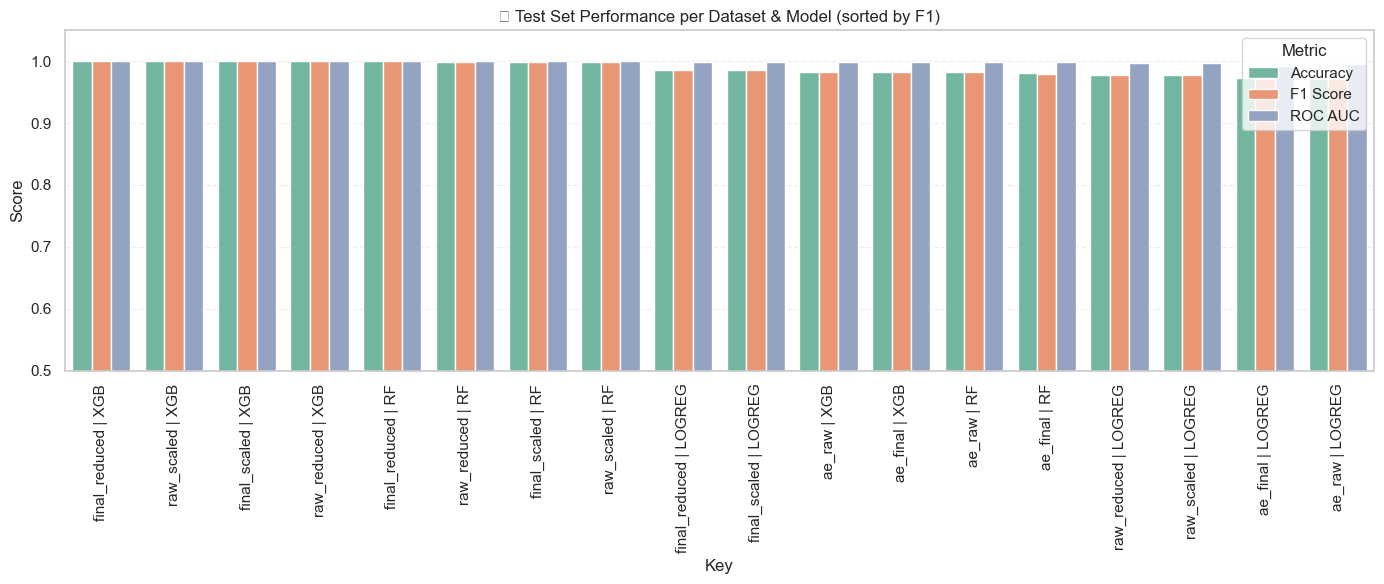

In [30]:
# === Evaluate all models on all datasets ===
all_results = []

for dataset_name in data_split_dict:
    X_test = data_split_dict[dataset_name]["X_test"]
    y_test = data_split_dict[dataset_name]["y_test"]

    for model_name in ["logreg", "rf", "xgb"]:
        grid = model_results_dict[(dataset_name, model_name)]
        model = grid.best_estimator_

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        all_results.append({
            "Dataset": dataset_name,
            "Model": model_name.upper(),
            "Key": f"{dataset_name} | {model_name.upper()}",
            "Accuracy": accuracy_score(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred),
            "ROC AUC": roc_auc_score(y_test, y_proba)
        })

# === Create and sort DataFrame ===
df_all_metrics = pd.DataFrame(all_results).sort_values(by="F1 Score", ascending=False)
display(df_all_metrics)

# === Melt and plot ===
melted = df_all_metrics.melt(id_vars=["Key"], value_vars=["Accuracy", "F1 Score", "ROC AUC"],
                             var_name="Metric", value_name="Score")

plt.figure(figsize=(14, 6))
sns.barplot(data=melted, x="Key", y="Score", hue="Metric", palette="Set2")
plt.title("📊 Test Set Performance per Dataset & Model (sorted by F1)")
plt.xticks(rotation=90)
plt.ylim(0.5, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



### ✅ Conclusions

The evaluation results across all datasets and models demonstrate exceptionally high classification performance. Here are the key takeaways:

- 🔝 **XGBoost consistently achieved perfect performance (100% Accuracy, F1, and ROC AUC)** on multiple datasets:
  - `raw_scaled`
  - `final_scaled`
  - `raw_reduced`
  - `final_reduced`
- 🌲 **Random Forest** also reached perfect or near-perfect results on the same reduced and scaled datasets, showing strong performance with less tuning.
- 📉 **Logistic Regression**, while slightly behind tree-based models, still achieved **F1 Scores above 97%**, confirming that the features extracted are highly predictive and linearly separable to a great extent.
- 🧠 **Autoencoded datasets**, despite dimensionality reduction, retained most of the predictive signal:
  - XGBoost and RF models on AE-based datasets still exceeded **98% F1** in some cases.

### 🎯 Final Recommendation

- For highest performance, **XGBoost with either the `raw_scaled` or `final_scaled` dataset** is a reliable choice.
- If computational efficiency or interpretability is important, **Random Forest or even Logistic Regression** can be considered, especially when paired with scaled or reduced datasets.
- The preprocessing pipeline—including outlier removal, normalization, and dimensionality reduction—ensured robust model behavior and generalization.

In conclusion, the problem is **highly learnable**, and even simple models can achieve excellent results with the right preprocessing.
